## Loading prems

In [ ]:
from typing import Optional

import jax.numpy
import numpy


def gaussian_mixture_energy(coord, means, sigmas, weights):
    """
        Implements an isotropic gaussian mixture energy function.
        This is a good distribution for debugging sampler implementation

        $\sum_{i=O}^{K-1}  w_i  \mathcal N (means_i, sigmas_i)$

        :param coord : [[x,y]] point of shape=(1,2) at which to compute energy.
        :param means : array of 2D means (shape=(K, 2)) for each gaussian dist in mixture
        :param sigmas: array of scalers (shape=(K,)) describing std of each gaussian dist in mixture
        :param weights: array of scalers (shape=(K,)) describing weights of each gaussian dist in mixture
        :return energy value (or -log of unnormalized density)
    """

    diff = coord - means
    numerator = jax.numpy.sum(diff ** 2, axis=1)

    mode_densities = jax.numpy.exp(- numerator / (2 * sigmas ** 2)) / sigmas
    density = jax.numpy.sum(weights * mode_densities)
    return -jax.numpy.log(density)


def gaussian_mixture_sampler(N, means, sigmas, weights, key):
    """
        Implements sampling from an isotropic gaussian mixture energy function.
        This is a good distribution for debugging sampler implementation

        $\sum_{i=O}^{K-1}  w_i  \mathcal N (means_i, sigmas_i)$

        :param N : number of samples to generate
        :param means : array of 2D means (shape=(K, 2)) for each gaussian dist in mixture
        :param sigmas: array of scalers (shape=(K,)) describing std of each gaussian dist in mixture
        :param weights: array of scalers (shape=(K,)) describing weights of each gaussian dist in mixture
        :param key: JAX needs a key for its random number generator, it is just that
        :return samples shape=(N,2)
    """

    # first sample modes
    subkey, key = jax.random.split(key)
    modes = jax.random.choice(subkey, len(weights), shape=(N,), p=weights)

    shape = (N,) + means.shape[1:]
    subkey, key = jax.random.split(key)
    std_normal_samples = jax.random.normal(subkey, shape=shape)
    return std_normal_samples * sigmas[modes].reshape(std_normal_samples.shape[0], 1) + means[modes]


def sample_from_image_density(N, density, key):
    """
        adapted from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/snf_code/snf_code/image.py#L138

        This samples a bin with probability given by density and then perturb the coordinate of bin uniformly

        :param N: number of samples
        :param density: density or value at each pixel
        :param key: JAX needs a key for its random number generator, it is just that
        :return: samples shape=(N,2)
    """
    # normalize
    density = density / density.sum()

    flat_density = density.flatten()
    subkey, key = jax.random.split(key)
    indices = jax.random.choice(subkey, a=len(flat_density), shape=(N,), p=flat_density)

    bins = jax.numpy.stack([indices // (density.shape[0]), indices % (density.shape[0])], axis=1)
    subkey, key = jax.random.split(key)
    samples = bins + jax.random.uniform(subkey, shape=bins.shape) - 0.5
    return samples


def continuous_energy_from_image(coord, xp, yp, zp, fill_value=None):
    """

    :param coord:
    :param xp: see interp2d
    :param yp: see interp2d
    :param zp: see interp2d
    :param fill_value: see interp2d (Note: you can this to enforce some trivial boundary conditions
    :return: energy (based on bilinear interpolation of zp on xp, yp grid. )
    """
    return -jax.numpy.log(interp2d(coord[0], coord[1], xp, yp, zp, fill_value))


def interp2d(
        x: jax.numpy.ndarray,
        y: jax.numpy.ndarray,
        xp: jax.numpy.ndarray,
        yp: jax.numpy.ndarray,
        zp: jax.numpy.ndarray,
        fill_value: Optional[jax.numpy.ndarray] = None,
) -> jax.numpy.ndarray:
    """
    Taken from "https://github.com/adam-coogan/jaxinterp2d/blob/master/src/jaxinterp2d/__init__.py"
    Bilinear interpolation on a grid. ``CartesianGrid`` is much faster if the data
    lies on a regular grid.
    Args:
        x, y: 1D arrays of point at which to interpolate. Any out-of-bounds
            coordinates will be clamped to lie in-bounds.
        xp, yp: 1D arrays of points specifying grid points where function values
            are provided.
        zp: 2D array of function values. For a function `f(x, y)` this must
            satisfy `zp[i, j] = f(xp[i], yp[j])`
    Returns:
        1D array `z` satisfying `z[i] = f(x[i], y[i])`.
    """
    if xp.ndim != 1 or yp.ndim != 1:
        raise ValueError("xp and yp must be 1D arrays")
    if zp.shape != (xp.shape + yp.shape):
        raise ValueError("zp must be a 2D array with shape xp.shape + yp.shape")

    ix = jax.numpy.clip(jax.numpy.searchsorted(xp, x, side="right"), 1, len(xp) - 1)
    iy = jax.numpy.clip(jax.numpy.searchsorted(yp, y, side="right"), 1, len(yp) - 1)

    # Using Wikipedia's notation (https://en.wikipedia.org/wiki/Bilinear_interpolation)
    z_11 = zp[ix - 1, iy - 1]
    z_21 = zp[ix, iy - 1]
    z_12 = zp[ix - 1, iy]
    z_22 = zp[ix, iy]

    z_xy1 = (xp[ix] - x) / (xp[ix] - xp[ix - 1]) * z_11 + (x - xp[ix - 1]) / (
            xp[ix] - xp[ix - 1]
    ) * z_21
    z_xy2 = (xp[ix] - x) / (xp[ix] - xp[ix - 1]) * z_12 + (x - xp[ix - 1]) / (
            xp[ix] - xp[ix - 1]
    ) * z_22

    z = (yp[iy] - y) / (yp[iy] - yp[iy - 1]) * z_xy1 + (y - yp[iy - 1]) / (
            yp[iy] - yp[iy - 1]
    ) * z_xy2

    if fill_value is not None:
        oob = jax.numpy.logical_or(
            x < xp[0], jax.numpy.logical_or(x > xp[-1], jax.numpy.logical_or(y < yp[0], y > yp[-1]))
        )
        z = jax.numpy.where(oob, fill_value, z)

    return z


def prepare_image(rgb, crop=None, embed=None, white_cutoff=225, gauss_sigma=3, background=0.01):
    """
    Taken from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/snf_code/snf_code/image.py
    Transforms rgb image array into 2D-density and energy
    Parameters:
        rgb: RGB image

     ----------
    density : ndarray(width, height)
        Probability density
    energy : ndarray(width, height)
        Energy
    """
    img = rgb

    # make one channel
    img = img.mean(axis=2)

    # make background white
    img = img.astype(numpy.float32)
    img[img > white_cutoff] = 255

    # normalize
    img /= img.max()

    if crop is not None:
        # crop
        img = img[crop[0]:crop[1], crop[2]:crop[3]]

    if embed is not None:
        tmp = numpy.ones((embed[0], embed[1]), dtype=numpy.float32)
        shift_x = (embed[0] - img.shape[0]) // 2
        shift_y = (embed[1] - img.shape[1]) // 2
        tmp[shift_x:img.shape[0] + shift_x, shift_y:img.shape[1] + shift_y] = img
        img = tmp

    # convolve with Gaussian
    from scipy.ndimage import gaussian_filter
    img2 = gaussian_filter(img, sigma=gauss_sigma)

    # add background
    background1 = gaussian_filter(img, sigma=10)
    background2 = gaussian_filter(img, sigma=20)
    background3 = gaussian_filter(img, sigma=50)
    density = (1.0 - img2) + background * (background1 + background2 + background3)

    U = -numpy.log(density)
    U -= U.min()

    return density, U

# see NPEET for different type of information-theoretic metrics
from typing import List, Union

import numpy


def compute_2d_histogram_from_samples(samples, density):
    """
        Compute 2D histogram from samples for samples on a 2D grid.
        This is to be used when sampling from image's density.

    :param samples: 2D samples from image density
    :param density: density derived from the image
    :return: unnormalized density with bin_size 1
    """

    x_dim, y_dim = density.shape

    sample_density, xedges, yedges = numpy.histogram2d(
        samples[:, 0], samples[:, 1], bins=[numpy.arange(0, x_dim + 1), numpy.arange(0, y_dim + 1)],
        density=False
    )

    return sample_density


def compute_coarse_discretization(density, bin_size):
    if isinstance(bin_size, int):
        bin_size = [bin_size, bin_size]

    bin_size_x, bin_size_y = bin_size

    x_dim, y_dim = density.shape

    density_new = numpy.zeros(((x_dim + 1) // bin_size_x, (y_dim + 1) // bin_size_y))
    for i in range(0, density_new.shape[0]):
        for j in range(0, density_new.shape[1]):
            density_new[i, j] = (
                density[i * bin_size_x:(i + 1) * bin_size_x][:,
                j * bin_size_y:(j + 1) * bin_size_y]).sum()

    return density_new


def get_discretized_tv_for_image_density(density, samples, bin_size: Union[int, List[int]] = 1):
    if isinstance(bin_size, int):
        bin_size = [bin_size, bin_size]

    sample_density = compute_2d_histogram_from_samples(samples, density)

    density = compute_coarse_discretization(density, bin_size)
    sample_density = compute_coarse_discretization(sample_density, bin_size)

    sample_density = sample_density / sample_density.sum()
    density = density / density.sum()
    breakpoint()
    return (numpy.abs(density - sample_density)).sum()


## Installing related packages

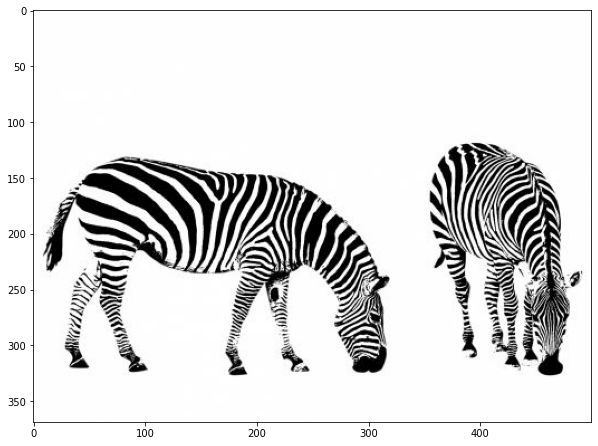

In [ ]:
import matplotlib.image
import matplotlib.pyplot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams, ticker, cm
from matplotlib import collections as mc
import numpy as onp 
rcParams['animation.html'] = 'jshtml'  # Makes the default animation an interactive video
rcParams['animation.embed_limit'] = 2**128  # Allow bigger animations

img = matplotlib.image.imread('/content/drive/MyDrive/CS699/homework #2/zebra.jpeg')

# plot and visualize
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
matplotlib.pyplot.show()

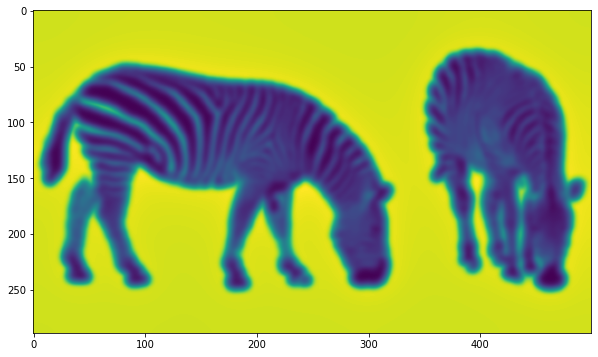

In [ ]:
import jax

density, energy = prepare_image(
    img, crop=[80, 400, 0, 500], white_cutoff=225, gauss_sigma=3, background=0.01
)

x_max, y_max = density.shape
xp = jax.numpy.arange(x_max)
yp = jax.numpy.arange(y_max)
zp = jax.numpy.array(density)

# You may use fill value to enforce some boundary conditions or some other way to enforce boundary conditions
energy_fn = lambda coord: continuous_energy_from_image(coord, xp, yp, zp, fill_value=0)
energy_fn_grad = jax.grad(energy_fn)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(energy)
matplotlib.pyplot.show()

In [ ]:
import jax.numpy as np
import jax
from jax import random

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

def hamiltonian_monte_carlo(x0, f, k, epsilon):
    """Run HMC for k steps, with step size epsilon"""
    v = onp.random.randn(*x0.shape)  # Not the correct way to get randoms in JAX
    g = jax.grad(f)  # Gradient of energy function
    x = x0  # save the original state, in case we reject the update
    for i in range(k):
        v = v - 0.5 * epsilon * g(x)  # half step in v
        x = x + epsilon * v  # full step in x
        v = v - 0.5 * epsilon * g(x)  # half step in v  
        # more efficient to combine half-steps
    if onp.random.random() > np.exp(f(x0) - f(x)):
        print("Metropolis- Hastings REJECT", f(x0), f(x))
        x = x0
    return x

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


  0%|          | 2/10000 [00:12<17:06:30,  6.16s/it]

Metropolis- Hastings REJECT 0.6309183 2.2915766


  0%|          | 3/10000 [00:18<17:13:34,  6.20s/it]

Metropolis- Hastings REJECT 0.6309183 0.65469366


  0%|          | 20/10000 [01:59<16:33:26,  5.97s/it]

Metropolis- Hastings REJECT 0.52556986 0.7470681


  0%|          | 29/10000 [02:54<16:48:08,  6.07s/it]

Metropolis- Hastings REJECT 0.36658016 0.51308775


  0%|          | 36/10000 [03:36<16:36:16,  6.00s/it]

Metropolis- Hastings REJECT 0.7426316 1.7532183


  0%|          | 43/10000 [04:18<16:38:56,  6.02s/it]

Metropolis- Hastings REJECT 0.40016097 1.181717


  0%|          | 50/10000 [04:59<16:27:55,  5.96s/it]

Metropolis- Hastings REJECT 0.64096296 1.3449376


  1%|          | 52/10000 [05:11<16:32:31,  5.99s/it]

Metropolis- Hastings REJECT 0.766958 3.2285771


  1%|          | 57/10000 [05:41<16:32:01,  5.99s/it]

Metropolis- Hastings REJECT 0.3951909 0.5547794


  1%|          | 63/10000 [06:17<16:40:45,  6.04s/it]

Metropolis- Hastings REJECT 0.39602175 0.47223866


  1%|          | 69/10000 [06:54<16:41:19,  6.05s/it]

Metropolis- Hastings REJECT 0.15994407 0.9444519


  1%|          | 72/10000 [07:12<16:41:18,  6.05s/it]

Metropolis- Hastings REJECT 0.19453041 0.80079836


  1%|          | 74/10000 [07:24<16:37:57,  6.03s/it]

Metropolis- Hastings REJECT 0.45138794 inf


  1%|          | 76/10000 [07:36<16:41:33,  6.06s/it]

Metropolis- Hastings REJECT 0.32210478 0.5278646


  1%|          | 77/10000 [07:42<16:46:48,  6.09s/it]

Metropolis- Hastings REJECT 0.32210478 1.6217655


  1%|          | 78/10000 [07:48<16:43:03,  6.07s/it]

Metropolis- Hastings REJECT 0.32210478 0.73071253


  1%|          | 79/10000 [07:54<16:53:54,  6.13s/it]

Metropolis- Hastings REJECT 0.32210478 0.43932113


  1%|          | 87/10000 [08:43<16:39:32,  6.05s/it]

Metropolis- Hastings REJECT 0.33067626 3.563613


  1%|          | 92/10000 [09:13<16:37:44,  6.04s/it]

Metropolis- Hastings REJECT 0.04341688 0.3626638


  1%|          | 95/10000 [09:32<16:50:13,  6.12s/it]

Metropolis- Hastings REJECT 0.047786176 0.63836026


  1%|          | 103/10000 [10:20<16:49:24,  6.12s/it]

Metropolis- Hastings REJECT 0.09057714 1.1851931


  1%|          | 105/10000 [10:32<16:44:01,  6.09s/it]

Metropolis- Hastings REJECT 0.29787216 1.734221


  1%|          | 107/10000 [10:45<16:49:21,  6.12s/it]

Metropolis- Hastings REJECT 0.14184944 0.33816493


  1%|          | 112/10000 [11:15<16:35:08,  6.04s/it]

Metropolis- Hastings REJECT 0.18386494 0.39553964


  1%|          | 120/10000 [12:03<16:45:15,  6.10s/it]

Metropolis- Hastings REJECT 0.28020602 0.6274452


  1%|          | 122/10000 [12:16<16:52:27,  6.15s/it]

Metropolis- Hastings REJECT 0.2571283 0.7138775


  1%|▏         | 134/10000 [13:28<16:43:05,  6.10s/it]

Metropolis- Hastings REJECT 0.4535939 1.289702


  1%|▏         | 135/10000 [13:34<16:44:46,  6.11s/it]

Metropolis- Hastings REJECT 0.4535939 0.7285552


  1%|▏         | 144/10000 [14:28<16:34:36,  6.05s/it]

Metropolis- Hastings REJECT 0.44499862 1.1218274


  1%|▏         | 145/10000 [14:34<16:46:37,  6.13s/it]

Metropolis- Hastings REJECT 0.44499862 1.9667907


  2%|▏         | 153/10000 [15:22<16:23:28,  5.99s/it]

Metropolis- Hastings REJECT 0.89766276 3.6775084


  2%|▏         | 160/10000 [16:04<16:25:13,  6.01s/it]

Metropolis- Hastings REJECT 0.60812217 3.5253448


  2%|▏         | 162/10000 [16:17<16:40:52,  6.10s/it]

Metropolis- Hastings REJECT 0.39059603 1.8474815


  2%|▏         | 167/10000 [16:47<16:24:56,  6.01s/it]

Metropolis- Hastings REJECT 0.30385026 1.0809462


  2%|▏         | 170/10000 [17:04<16:20:57,  5.99s/it]

Metropolis- Hastings REJECT 0.34095088 1.2571161


  2%|▏         | 174/10000 [17:29<16:34:40,  6.07s/it]

Metropolis- Hastings REJECT 0.14757845 1.4575145


  2%|▏         | 175/10000 [17:35<16:39:33,  6.10s/it]

Metropolis- Hastings REJECT 0.14757845 0.74728906


  2%|▏         | 179/10000 [17:59<16:22:15,  6.00s/it]

Metropolis- Hastings REJECT 0.20500249 0.89229697


  2%|▏         | 182/10000 [18:17<16:18:18,  5.98s/it]

Metropolis- Hastings REJECT 0.17083648 0.46002683


  2%|▏         | 184/10000 [18:29<16:26:25,  6.03s/it]

Metropolis- Hastings REJECT 0.1758192 2.9586911


  2%|▏         | 185/10000 [18:35<16:32:25,  6.07s/it]

Metropolis- Hastings REJECT 0.1758192 1.1469077


  2%|▏         | 203/10000 [20:22<16:13:42,  5.96s/it]

Metropolis- Hastings REJECT 0.12831359 0.37411562


  2%|▏         | 205/10000 [20:34<16:17:01,  5.98s/it]

Metropolis- Hastings REJECT 0.07375136 0.92711914


  2%|▏         | 212/10000 [21:16<16:10:23,  5.95s/it]

Metropolis- Hastings REJECT 0.52455324 0.623584


  2%|▏         | 215/10000 [21:33<16:07:05,  5.93s/it]

Metropolis- Hastings REJECT 3.5380578 inf


  2%|▏         | 216/10000 [21:39<16:04:54,  5.92s/it]

Metropolis- Hastings REJECT 3.5380578 inf


  2%|▏         | 224/10000 [22:26<16:00:22,  5.89s/it]

Metropolis- Hastings REJECT 0.38449273 0.55420005


  2%|▏         | 231/10000 [23:08<16:04:14,  5.92s/it]

Metropolis- Hastings REJECT 0.34946966 0.49342644


  2%|▏         | 242/10000 [24:14<16:27:46,  6.07s/it]

Metropolis- Hastings REJECT 0.345168 1.0276979


  2%|▏         | 244/10000 [24:26<16:22:35,  6.04s/it]

Metropolis- Hastings REJECT 0.5041304 0.6499871


  2%|▏         | 247/10000 [24:44<16:17:41,  6.01s/it]

Metropolis- Hastings REJECT 0.4220915 0.9515624


  3%|▎         | 257/10000 [25:43<16:08:24,  5.96s/it]

Metropolis- Hastings REJECT 0.48641932 inf


  3%|▎         | 261/10000 [26:07<16:13:20,  6.00s/it]

Metropolis- Hastings REJECT 0.7643575 3.6073747


  3%|▎         | 278/10000 [27:48<16:02:28,  5.94s/it]

Metropolis- Hastings REJECT 0.6058301 1.5669074


  3%|▎         | 282/10000 [28:12<16:08:10,  5.98s/it]

Metropolis- Hastings REJECT 0.89129585 2.383887


  3%|▎         | 289/10000 [28:53<16:01:04,  5.94s/it]

Metropolis- Hastings REJECT 1.1945485 1.6710796


  3%|▎         | 294/10000 [29:23<16:06:54,  5.98s/it]

Metropolis- Hastings REJECT 0.27250856 3.670044


  3%|▎         | 302/10000 [30:10<15:50:04,  5.88s/it]

Metropolis- Hastings REJECT 0.45829374 1.138863


  3%|▎         | 304/10000 [30:22<15:57:27,  5.92s/it]

Metropolis- Hastings REJECT 0.5913701 0.7591938


  3%|▎         | 305/10000 [30:28<16:11:45,  6.01s/it]

Metropolis- Hastings REJECT 0.5913701 3.562815


  3%|▎         | 322/10000 [32:10<16:07:20,  6.00s/it]

Metropolis- Hastings REJECT 0.74337375 1.170922


  3%|▎         | 326/10000 [32:34<15:58:24,  5.94s/it]

Metropolis- Hastings REJECT 0.9185135 inf


  3%|▎         | 331/10000 [33:04<16:20:43,  6.09s/it]

Metropolis- Hastings REJECT 0.2862679 1.3815475


  3%|▎         | 342/10000 [34:10<16:08:06,  6.01s/it]

Metropolis- Hastings REJECT 0.4908598 inf


  3%|▎         | 345/10000 [34:28<16:16:42,  6.07s/it]

Metropolis- Hastings REJECT 0.3622479 1.6627523


  3%|▎         | 347/10000 [34:40<16:16:20,  6.07s/it]

Metropolis- Hastings REJECT 0.49786848 0.66442186


  3%|▎         | 348/10000 [34:47<16:20:39,  6.10s/it]

Metropolis- Hastings REJECT 0.49786848 3.546059


  4%|▎         | 363/10000 [36:16<16:07:28,  6.02s/it]

Metropolis- Hastings REJECT 0.44391423 1.3308097


  4%|▍         | 387/10000 [38:39<16:00:59,  6.00s/it]

Metropolis- Hastings REJECT 0.7464952 1.0946469


  4%|▍         | 394/10000 [39:21<16:13:04,  6.08s/it]

Metropolis- Hastings REJECT 0.6326644 3.5559807


  4%|▍         | 397/10000 [39:39<16:10:15,  6.06s/it]

Metropolis- Hastings REJECT 0.55946064 2.0904174


  4%|▍         | 403/10000 [40:15<16:00:26,  6.00s/it]

Metropolis- Hastings REJECT 0.4630469 0.9765996


  4%|▍         | 420/10000 [41:57<16:06:18,  6.05s/it]

Metropolis- Hastings REJECT 0.74161875 1.0387874


  4%|▍         | 422/10000 [42:09<15:50:18,  5.95s/it]

Metropolis- Hastings REJECT 0.75075656 1.3627114


  4%|▍         | 430/10000 [42:57<15:49:46,  5.95s/it]

Metropolis- Hastings REJECT 0.057842355 0.5567716


  4%|▍         | 431/10000 [43:03<15:54:15,  5.98s/it]

Metropolis- Hastings REJECT 0.057842355 0.6338743


  4%|▍         | 436/10000 [43:32<15:54:36,  5.99s/it]

Metropolis- Hastings REJECT 0.56702554 2.8693817


  4%|▍         | 447/10000 [44:38<16:04:36,  6.06s/it]

Metropolis- Hastings REJECT 0.20421027 0.6228682


  5%|▍         | 471/10000 [47:00<15:39:55,  5.92s/it]

Metropolis- Hastings REJECT 0.2777494 2.511767


  5%|▍         | 480/10000 [47:54<15:46:36,  5.97s/it]

Metropolis- Hastings REJECT 0.40166286 0.52667844


  5%|▍         | 489/10000 [48:47<15:39:40,  5.93s/it]

Metropolis- Hastings REJECT 0.5962714 0.9146574


  5%|▍         | 490/10000 [48:53<15:39:12,  5.93s/it]

Metropolis- Hastings REJECT 0.5962714 3.6018329


  5%|▍         | 495/10000 [49:23<15:44:13,  5.96s/it]

Metropolis- Hastings REJECT 0.24730535 1.3474357


  5%|▍         | 498/10000 [49:41<15:47:00,  5.98s/it]

Metropolis- Hastings REJECT 0.4983979 1.0348126


  5%|▌         | 537/10000 [53:33<15:48:03,  6.01s/it]

Metropolis- Hastings REJECT 0.8241948 3.3342884


  5%|▌         | 541/10000 [53:57<15:30:24,  5.90s/it]

Metropolis- Hastings REJECT 0.7087455 1.5935105


  6%|▌         | 573/10000 [57:07<15:28:00,  5.91s/it]

Metropolis- Hastings REJECT 0.6928827 0.87695396


  6%|▌         | 583/10000 [58:07<15:28:13,  5.91s/it]

Metropolis- Hastings REJECT 0.25025666 1.0794524


  6%|▌         | 587/10000 [58:31<15:33:06,  5.95s/it]

Metropolis- Hastings REJECT 0.056044903 0.49047124


  6%|▌         | 595/10000 [59:18<15:31:50,  5.94s/it]

Metropolis- Hastings REJECT 1.2921717 3.5800369


  6%|▌         | 603/10000 [1:00:07<15:49:29,  6.06s/it]

Metropolis- Hastings REJECT 0.048596606 0.39171088


  6%|▌         | 606/10000 [1:00:25<15:47:02,  6.05s/it]

Metropolis- Hastings REJECT 0.06398694 0.5823088


  6%|▌         | 609/10000 [1:00:43<15:52:08,  6.08s/it]

Metropolis- Hastings REJECT 0.68141913 2.7101223


  6%|▌         | 613/10000 [1:01:07<15:31:19,  5.95s/it]

Metropolis- Hastings REJECT 0.3679812 0.99917966


  6%|▌         | 614/10000 [1:01:13<15:40:52,  6.01s/it]

Metropolis- Hastings REJECT 0.3679812 3.614722


  6%|▋         | 625/10000 [1:02:18<15:24:18,  5.92s/it]

Metropolis- Hastings REJECT 0.30035323 1.5637051


  6%|▋         | 627/10000 [1:02:30<15:30:49,  5.96s/it]

Metropolis- Hastings REJECT 0.42924404 0.6526076


  6%|▋         | 628/10000 [1:02:36<15:33:44,  5.98s/it]

Metropolis- Hastings REJECT 0.42924404 3.543772


  6%|▋         | 630/10000 [1:02:48<15:34:45,  5.99s/it]

Metropolis- Hastings REJECT 0.64559966 3.0943332


  6%|▋         | 632/10000 [1:03:00<15:30:54,  5.96s/it]

Metropolis- Hastings REJECT 0.5068807 1.0029632


  6%|▋         | 634/10000 [1:03:11<15:13:13,  5.85s/it]

Metropolis- Hastings REJECT 0.5495224 0.65468276


  6%|▋         | 641/10000 [1:03:53<15:29:50,  5.96s/it]

Metropolis- Hastings REJECT 0.020676475 0.3488191


  6%|▋         | 645/10000 [1:04:16<15:12:40,  5.85s/it]

Metropolis- Hastings REJECT 0.018916907 1.5836681


  7%|▋         | 654/10000 [1:05:09<15:09:49,  5.84s/it]

Metropolis- Hastings REJECT 0.58636165 3.4530983


  7%|▋         | 657/10000 [1:05:27<15:23:26,  5.93s/it]

Metropolis- Hastings REJECT 0.73051935 0.8227825


  7%|▋         | 658/10000 [1:05:32<15:17:46,  5.89s/it]

Metropolis- Hastings REJECT 0.73051935 1.0199717


  7%|▋         | 659/10000 [1:05:38<15:19:00,  5.90s/it]

Metropolis- Hastings REJECT 0.73051935 inf


  7%|▋         | 665/10000 [1:06:14<15:13:25,  5.87s/it]

Metropolis- Hastings REJECT 0.20895322 0.7232184


  7%|▋         | 666/10000 [1:06:19<15:12:18,  5.86s/it]

Metropolis- Hastings REJECT 0.20895322 0.65101665


  7%|▋         | 689/10000 [1:08:36<15:23:08,  5.95s/it]

Metropolis- Hastings REJECT 0.85298014 3.6469755


  7%|▋         | 697/10000 [1:09:24<15:28:33,  5.99s/it]

Metropolis- Hastings REJECT 0.30133837 3.572133


  7%|▋         | 700/10000 [1:09:42<15:22:35,  5.95s/it]

Metropolis- Hastings REJECT 0.5479348 0.9874389


  7%|▋         | 704/10000 [1:10:05<15:19:22,  5.93s/it]

Metropolis- Hastings REJECT 0.5357795 2.9886255


  7%|▋         | 723/10000 [1:11:58<15:15:17,  5.92s/it]

Metropolis- Hastings REJECT 0.31880945 0.6484337


  7%|▋         | 725/10000 [1:12:11<15:32:19,  6.03s/it]

Metropolis- Hastings REJECT 0.33748344 0.777902


  7%|▋         | 732/10000 [1:12:52<15:16:47,  5.94s/it]

Metropolis- Hastings REJECT 0.6438185 3.5536182


  7%|▋         | 739/10000 [1:13:34<15:28:34,  6.02s/it]

Metropolis- Hastings REJECT 0.34124067 1.0620408


  7%|▋         | 740/10000 [1:13:39<15:16:05,  5.94s/it]

Metropolis- Hastings REJECT 0.34124067 0.47170603


  7%|▋         | 741/10000 [1:13:45<15:15:51,  5.93s/it]

Metropolis- Hastings REJECT 0.34124067 0.73406726


  7%|▋         | 747/10000 [1:14:21<15:22:57,  5.98s/it]

Metropolis- Hastings REJECT 0.61678267 1.8651153


  8%|▊         | 757/10000 [1:15:20<15:06:34,  5.88s/it]

Metropolis- Hastings REJECT 0.33932948 0.6399812


  8%|▊         | 758/10000 [1:15:26<15:07:28,  5.89s/it]

Metropolis- Hastings REJECT 0.33932948 0.55431104


  8%|▊         | 766/10000 [1:16:14<15:22:42,  6.00s/it]

Metropolis- Hastings REJECT 0.5506564 0.8574617


  8%|▊         | 769/10000 [1:16:32<15:28:42,  6.04s/it]

Metropolis- Hastings REJECT 0.7785574 3.1163304


  8%|▊         | 778/10000 [1:17:25<15:12:22,  5.94s/it]

Metropolis- Hastings REJECT 0.5747116 3.5362074


  8%|▊         | 790/10000 [1:18:36<15:26:03,  6.03s/it]

Metropolis- Hastings REJECT 0.11728205 0.454002


  8%|▊         | 805/10000 [1:20:05<14:59:07,  5.87s/it]

Metropolis- Hastings REJECT 1.5009595 3.5298877


  8%|▊         | 808/10000 [1:20:23<15:08:15,  5.93s/it]

Metropolis- Hastings REJECT 0.39852503 0.8506383


  8%|▊         | 814/10000 [1:20:59<15:14:19,  5.97s/it]

Metropolis- Hastings REJECT 0.13533588 0.43996012


  8%|▊         | 816/10000 [1:21:11<15:17:35,  5.99s/it]

Metropolis- Hastings REJECT 0.40273207 1.0749059


  8%|▊         | 825/10000 [1:22:04<14:59:56,  5.89s/it]

Metropolis- Hastings REJECT 0.50837237 0.8565743


  8%|▊         | 829/10000 [1:22:27<14:53:06,  5.84s/it]

Metropolis- Hastings REJECT 0.2536124 1.1125894


  8%|▊         | 837/10000 [1:23:15<15:11:51,  5.97s/it]

Metropolis- Hastings REJECT 0.10631633 0.5758767


  8%|▊         | 841/10000 [1:23:39<15:15:50,  6.00s/it]

Metropolis- Hastings REJECT 0.024580304 0.3591401


  8%|▊         | 843/10000 [1:23:51<15:14:17,  5.99s/it]

Metropolis- Hastings REJECT 0.008827734 1.5576847


  8%|▊         | 845/10000 [1:24:03<15:12:11,  5.98s/it]

Metropolis- Hastings REJECT 0.028230483 2.3115761


  8%|▊         | 846/10000 [1:24:09<15:14:02,  5.99s/it]

Metropolis- Hastings REJECT 0.028230483 1.0923543


  8%|▊         | 847/10000 [1:24:15<15:16:30,  6.01s/it]

Metropolis- Hastings REJECT 0.028230483 0.46032572


  8%|▊         | 849/10000 [1:24:27<15:14:27,  6.00s/it]

Metropolis- Hastings REJECT 0.024137758 0.19269057


  9%|▊         | 855/10000 [1:25:03<15:13:10,  5.99s/it]

Metropolis- Hastings REJECT 0.18901159 0.91336745


  9%|▊         | 859/10000 [1:25:26<15:03:44,  5.93s/it]

Metropolis- Hastings REJECT 0.27561867 0.65667105


  9%|▉         | 876/10000 [1:27:08<15:22:04,  6.06s/it]

Metropolis- Hastings REJECT 0.56141007 0.88940006


  9%|▉         | 886/10000 [1:28:08<15:08:50,  5.98s/it]

Metropolis- Hastings REJECT 0.1413414 0.37365502


  9%|▉         | 887/10000 [1:28:14<15:11:40,  6.00s/it]

Metropolis- Hastings REJECT 0.1413414 0.99037516


  9%|▉         | 888/10000 [1:28:20<15:16:20,  6.03s/it]

Metropolis- Hastings REJECT 0.1413414 0.3236866


  9%|▉         | 891/10000 [1:28:38<15:06:09,  5.97s/it]

Metropolis- Hastings REJECT 0.4366334 2.3103116


  9%|▉         | 902/10000 [1:29:43<15:06:36,  5.98s/it]

Metropolis- Hastings REJECT 0.15448806 0.39318016


  9%|▉         | 903/10000 [1:29:49<15:07:22,  5.98s/it]

Metropolis- Hastings REJECT 0.15448806 0.59645134


  9%|▉         | 907/10000 [1:30:13<14:56:48,  5.92s/it]

Metropolis- Hastings REJECT 0.42786494 0.7600057


  9%|▉         | 914/10000 [1:30:54<15:01:03,  5.95s/it]

Metropolis- Hastings REJECT 0.32600376 0.5164243


  9%|▉         | 915/10000 [1:31:00<15:02:44,  5.96s/it]

Metropolis- Hastings REJECT 0.32600376 0.7278863


  9%|▉         | 918/10000 [1:31:18<15:03:58,  5.97s/it]

Metropolis- Hastings REJECT 0.20433426 1.1603221


  9%|▉         | 922/10000 [1:31:42<14:59:55,  5.95s/it]

Metropolis- Hastings REJECT 0.74251974 1.1295979


  9%|▉         | 923/10000 [1:31:48<15:00:47,  5.95s/it]

Metropolis- Hastings REJECT 0.74251974 3.674364


  9%|▉         | 937/10000 [1:33:10<14:45:31,  5.86s/it]

Metropolis- Hastings REJECT 0.26499084 0.7133814


  9%|▉         | 940/10000 [1:33:27<14:42:01,  5.84s/it]

Metropolis- Hastings REJECT 1.0378518 3.5849502


  9%|▉         | 947/10000 [1:34:08<14:50:50,  5.90s/it]

Metropolis- Hastings REJECT 0.33249804 0.40948582


 10%|▉         | 953/10000 [1:34:43<14:35:44,  5.81s/it]

Metropolis- Hastings REJECT 0.4257611 0.78534085


 10%|▉         | 958/10000 [1:35:12<14:33:54,  5.80s/it]

Metropolis- Hastings REJECT 0.5227009 0.8737614


 10%|▉         | 959/10000 [1:35:18<14:39:59,  5.84s/it]

Metropolis- Hastings REJECT 0.5227009 0.78991276


 10%|▉         | 971/10000 [1:36:28<14:47:21,  5.90s/it]

Metropolis- Hastings REJECT 0.28102696 0.645865


 10%|▉         | 974/10000 [1:36:45<14:42:30,  5.87s/it]

Metropolis- Hastings REJECT 0.5939328 2.6805456


 10%|▉         | 978/10000 [1:37:09<14:42:42,  5.87s/it]

Metropolis- Hastings REJECT 0.4995618 0.5706794


 10%|▉         | 981/10000 [1:37:26<14:52:07,  5.93s/it]

Metropolis- Hastings REJECT 0.48697323 1.034375


 10%|▉         | 985/10000 [1:37:50<14:50:06,  5.92s/it]

Metropolis- Hastings REJECT 0.5282192 0.76725954


 10%|▉         | 987/10000 [1:38:02<14:57:17,  5.97s/it]

Metropolis- Hastings REJECT 0.6408513 2.0747638


 10%|█         | 1006/10000 [1:39:54<14:49:34,  5.93s/it]

Metropolis- Hastings REJECT 0.3864771 1.962099


 10%|█         | 1007/10000 [1:40:00<14:45:14,  5.91s/it]

Metropolis- Hastings REJECT 0.3864771 1.3623211


 10%|█         | 1010/10000 [1:40:18<14:36:33,  5.85s/it]

Metropolis- Hastings REJECT 0.8500488 3.5751588


 10%|█         | 1014/10000 [1:40:41<14:46:42,  5.92s/it]

Metropolis- Hastings REJECT 0.09001675 1.0563481


 10%|█         | 1020/10000 [1:41:16<14:30:05,  5.81s/it]

Metropolis- Hastings REJECT 0.33423918 0.9447156


 10%|█         | 1021/10000 [1:41:22<14:41:55,  5.89s/it]

Metropolis- Hastings REJECT 0.33423918 0.97666764


 10%|█         | 1026/10000 [1:41:52<14:47:12,  5.93s/it]

Metropolis- Hastings REJECT 0.37202057 1.2300496


 10%|█         | 1028/10000 [1:42:03<14:51:26,  5.96s/it]

Metropolis- Hastings REJECT 0.4460085 0.81609994


 10%|█         | 1029/10000 [1:42:09<14:54:30,  5.98s/it]

Metropolis- Hastings REJECT 0.4460085 1.1148043


 10%|█         | 1032/10000 [1:42:27<14:45:46,  5.93s/it]

Metropolis- Hastings REJECT 0.39761573 1.2845763


 10%|█         | 1034/10000 [1:42:39<14:41:38,  5.90s/it]

Metropolis- Hastings REJECT 0.3342974 1.0906516


 10%|█         | 1035/10000 [1:42:45<14:40:18,  5.89s/it]

Metropolis- Hastings REJECT 0.3342974 0.735887


 10%|█         | 1036/10000 [1:42:51<14:38:04,  5.88s/it]

Metropolis- Hastings REJECT 0.3342974 1.0321023


 10%|█         | 1037/10000 [1:42:57<14:41:55,  5.90s/it]

Metropolis- Hastings REJECT 0.3342974 1.7097474


 10%|█         | 1042/10000 [1:43:26<14:31:16,  5.84s/it]

Metropolis- Hastings REJECT 0.41472307 1.5594807


 10%|█         | 1043/10000 [1:43:32<14:32:03,  5.84s/it]

Metropolis- Hastings REJECT 0.41472307 1.4036068


 10%|█         | 1044/10000 [1:43:38<14:38:58,  5.89s/it]

Metropolis- Hastings REJECT 0.41472307 1.5363122


 10%|█         | 1048/10000 [1:44:01<14:39:48,  5.90s/it]

Metropolis- Hastings REJECT 0.25220245 1.0779972


 10%|█         | 1049/10000 [1:44:07<14:44:41,  5.93s/it]

Metropolis- Hastings REJECT 0.25220245 0.8860004


 11%|█         | 1052/10000 [1:44:25<14:38:36,  5.89s/it]

Metropolis- Hastings REJECT 0.29806304 0.5122


 11%|█         | 1053/10000 [1:44:31<14:45:09,  5.94s/it]

Metropolis- Hastings REJECT 0.29806304 1.1071287


 11%|█         | 1055/10000 [1:44:42<14:26:08,  5.81s/it]

Metropolis- Hastings REJECT 0.7811309 1.4328377


 11%|█         | 1065/10000 [1:45:39<14:14:51,  5.74s/it]

Metropolis- Hastings REJECT 0.6676135 1.1712836


 11%|█         | 1072/10000 [1:46:20<14:37:30,  5.90s/it]

Metropolis- Hastings REJECT 0.4345243 0.5967794


 11%|█         | 1073/10000 [1:46:26<14:32:32,  5.86s/it]

Metropolis- Hastings REJECT 0.4345243 1.8766998


 11%|█         | 1076/10000 [1:46:44<14:47:01,  5.96s/it]

Metropolis- Hastings REJECT 0.3472594 1.0523705


 11%|█         | 1077/10000 [1:46:50<14:38:03,  5.90s/it]

Metropolis- Hastings REJECT 0.3472594 1.3592155


 11%|█         | 1084/10000 [1:47:30<14:23:46,  5.81s/it]

Metropolis- Hastings REJECT 0.27419212 0.80914944


 11%|█         | 1086/10000 [1:47:42<14:27:29,  5.84s/it]

Metropolis- Hastings REJECT 0.31474182 3.5328052


 11%|█         | 1087/10000 [1:47:48<14:22:06,  5.80s/it]

Metropolis- Hastings REJECT 0.31474182 1.0202429


 11%|█         | 1093/10000 [1:48:23<14:25:38,  5.83s/it]

Metropolis- Hastings REJECT 1.294863 3.5629973


 11%|█         | 1101/10000 [1:49:09<14:24:22,  5.83s/it]

Metropolis- Hastings REJECT 0.071568355 1.2120063


 11%|█         | 1104/10000 [1:49:27<14:35:02,  5.90s/it]

Metropolis- Hastings REJECT 0.047341183 0.43625954


 11%|█         | 1105/10000 [1:49:33<14:39:37,  5.93s/it]

Metropolis- Hastings REJECT 0.047341183 0.8319173


 11%|█         | 1107/10000 [1:49:45<14:45:25,  5.97s/it]

Metropolis- Hastings REJECT 0.07665694 0.6424335


 11%|█         | 1116/10000 [1:50:37<14:24:50,  5.84s/it]

Metropolis- Hastings REJECT 0.38672313 3.6176734


 11%|█         | 1118/10000 [1:50:49<14:31:59,  5.89s/it]

Metropolis- Hastings REJECT 0.16787739 0.55965644


 11%|█▏        | 1140/10000 [1:52:58<14:30:28,  5.89s/it]

Metropolis- Hastings REJECT 0.4292845 1.2263523


 12%|█▏        | 1162/10000 [1:55:05<14:14:11,  5.80s/it]

Metropolis- Hastings REJECT 0.2932022 0.48737025


 12%|█▏        | 1168/10000 [1:55:41<14:35:59,  5.95s/it]

Metropolis- Hastings REJECT 0.4750271 0.752959


 12%|█▏        | 1170/10000 [1:55:52<14:28:38,  5.90s/it]

Metropolis- Hastings REJECT 0.8426114 1.9779743


 12%|█▏        | 1171/10000 [1:55:58<14:28:55,  5.91s/it]

Metropolis- Hastings REJECT 0.8426114 0.9767368


 12%|█▏        | 1188/10000 [1:57:38<14:25:07,  5.89s/it]

Metropolis- Hastings REJECT 0.057543114 3.5370948


 12%|█▏        | 1191/10000 [1:57:55<14:08:34,  5.78s/it]

Metropolis- Hastings REJECT 1.0931885 3.549281


 12%|█▏        | 1194/10000 [1:58:13<14:15:46,  5.83s/it]

Metropolis- Hastings REJECT 0.80390894 1.8235995


 12%|█▏        | 1196/10000 [1:58:25<14:19:50,  5.86s/it]

Metropolis- Hastings REJECT 0.7132281 1.0384204


 12%|█▏        | 1197/10000 [1:58:31<14:21:41,  5.87s/it]

Metropolis- Hastings REJECT 0.7132281 2.796261


 12%|█▏        | 1198/10000 [1:58:37<14:23:56,  5.89s/it]

Metropolis- Hastings REJECT 0.7132281 1.2215974


 12%|█▏        | 1201/10000 [1:58:54<14:31:35,  5.94s/it]

Metropolis- Hastings REJECT 0.818468 1.4015249


 12%|█▏        | 1212/10000 [1:59:59<14:22:28,  5.89s/it]

Metropolis- Hastings REJECT 0.31872648 3.594185


 12%|█▏        | 1223/10000 [2:01:03<14:16:48,  5.86s/it]

Metropolis- Hastings REJECT 1.0233876 3.6262877


 12%|█▏        | 1234/10000 [2:02:07<14:24:13,  5.92s/it]

Metropolis- Hastings REJECT 0.3722444 0.6906311


 12%|█▏        | 1246/10000 [2:03:17<14:17:48,  5.88s/it]

Metropolis- Hastings REJECT 0.340635 0.67271054


 13%|█▎        | 1260/10000 [2:04:39<14:12:02,  5.85s/it]

Metropolis- Hastings REJECT 0.7247306 1.3213124


 13%|█▎        | 1265/10000 [2:05:08<14:19:54,  5.91s/it]

Metropolis- Hastings REJECT 0.11901069 0.61390114


 13%|█▎        | 1273/10000 [2:05:56<14:20:11,  5.91s/it]

Metropolis- Hastings REJECT 0.4090337 0.75714606


 13%|█▎        | 1278/10000 [2:06:25<14:18:57,  5.91s/it]

Metropolis- Hastings REJECT 0.8263032 3.528365


 13%|█▎        | 1279/10000 [2:06:31<14:22:42,  5.94s/it]

Metropolis- Hastings REJECT 0.8263032 2.8095024


 13%|█▎        | 1290/10000 [2:07:36<14:22:53,  5.94s/it]

Metropolis- Hastings REJECT 0.56581086 0.8767163


 13%|█▎        | 1292/10000 [2:07:47<14:10:55,  5.86s/it]

Metropolis- Hastings REJECT 0.4567669 1.7151694


 13%|█▎        | 1305/10000 [2:09:05<14:25:17,  5.97s/it]

Metropolis- Hastings REJECT 0.33018082 3.1509283


 13%|█▎        | 1314/10000 [2:09:58<14:23:14,  5.96s/it]

Metropolis- Hastings REJECT 0.4598482 0.6039395


 13%|█▎        | 1321/10000 [2:10:39<14:08:49,  5.87s/it]

Metropolis- Hastings REJECT 0.33493856 0.38360235


 13%|█▎        | 1322/10000 [2:10:45<14:10:36,  5.88s/it]

Metropolis- Hastings REJECT 0.33493856 0.670707


 13%|█▎        | 1327/10000 [2:11:14<14:14:59,  5.91s/it]

Metropolis- Hastings REJECT 0.47325617 3.535795


 13%|█▎        | 1329/10000 [2:11:26<14:25:29,  5.99s/it]

Metropolis- Hastings REJECT 0.26862094 0.5747219


 13%|█▎        | 1331/10000 [2:11:38<14:24:19,  5.98s/it]

Metropolis- Hastings REJECT 0.15551525 0.6627699


 13%|█▎        | 1333/10000 [2:11:50<14:16:46,  5.93s/it]

Metropolis- Hastings REJECT 0.39272985 1.325738


 13%|█▎        | 1335/10000 [2:12:02<14:16:57,  5.93s/it]

Metropolis- Hastings REJECT 0.40469727 0.89804894


 13%|█▎        | 1342/10000 [2:12:42<13:54:24,  5.78s/it]

Metropolis- Hastings REJECT 0.31038266 0.43355218


 13%|█▎        | 1348/10000 [2:13:16<13:46:42,  5.73s/it]

Metropolis- Hastings REJECT 0.4326313 1.18258


 14%|█▎        | 1357/10000 [2:14:08<13:49:55,  5.76s/it]

Metropolis- Hastings REJECT 0.45906627 1.0805128


 14%|█▎        | 1358/10000 [2:14:14<13:46:00,  5.73s/it]

Metropolis- Hastings REJECT 0.45906627 0.6377464


 14%|█▎        | 1361/10000 [2:14:31<13:48:52,  5.76s/it]

Metropolis- Hastings REJECT 0.25821188 0.52078557


 14%|█▎        | 1365/10000 [2:14:54<13:56:54,  5.82s/it]

Metropolis- Hastings REJECT 0.4640122 0.74955386


 14%|█▎        | 1369/10000 [2:15:16<13:31:20,  5.64s/it]

Metropolis- Hastings REJECT 0.86076427 3.6520073


 14%|█▍        | 1384/10000 [2:16:42<14:01:49,  5.86s/it]

Metropolis- Hastings REJECT 0.5288379 inf


 14%|█▍        | 1387/10000 [2:17:00<14:00:02,  5.85s/it]

Metropolis- Hastings REJECT 0.8069097 1.8034031


 14%|█▍        | 1393/10000 [2:17:35<14:05:29,  5.89s/it]

Metropolis- Hastings REJECT 0.5717026 3.590501


 14%|█▍        | 1399/10000 [2:18:08<13:17:02,  5.56s/it]

Metropolis- Hastings REJECT 0.61503273 1.0367402


 14%|█▍        | 1401/10000 [2:18:20<13:37:21,  5.70s/it]

Metropolis- Hastings REJECT 0.4099748 1.106492


 14%|█▍        | 1412/10000 [2:19:25<14:06:05,  5.91s/it]

Metropolis- Hastings REJECT 0.5294237 1.8266559


 14%|█▍        | 1418/10000 [2:19:59<13:56:15,  5.85s/it]

Metropolis- Hastings REJECT 0.05730405 1.0384705


 14%|█▍        | 1422/10000 [2:20:22<13:41:44,  5.75s/it]

Metropolis- Hastings REJECT 0.071989484 0.6098417


 14%|█▍        | 1428/10000 [2:20:57<13:57:02,  5.86s/it]

Metropolis- Hastings REJECT 0.3225387 0.9290527


 14%|█▍        | 1435/10000 [2:21:38<13:53:22,  5.84s/it]

Metropolis- Hastings REJECT 0.44594157 0.79331565


 14%|█▍        | 1437/10000 [2:21:49<13:34:09,  5.70s/it]

Metropolis- Hastings REJECT 0.39479083 0.61711705


 14%|█▍        | 1447/10000 [2:22:47<14:03:33,  5.92s/it]

Metropolis- Hastings REJECT 0.44822925 1.5717912


 14%|█▍        | 1449/10000 [2:22:59<13:58:38,  5.88s/it]

Metropolis- Hastings REJECT 0.3887356 0.8691723


 15%|█▍        | 1460/10000 [2:24:03<13:51:55,  5.84s/it]

Metropolis- Hastings REJECT 0.08915487 0.41709402


 15%|█▍        | 1461/10000 [2:24:09<13:49:50,  5.83s/it]

Metropolis- Hastings REJECT 0.08915487 0.6402815


 15%|█▍        | 1471/10000 [2:25:08<13:51:35,  5.85s/it]

Metropolis- Hastings REJECT 0.41845644 0.50392056


 15%|█▍        | 1476/10000 [2:25:38<14:01:08,  5.92s/it]

Metropolis- Hastings REJECT 0.3116579 0.44914168


 15%|█▍        | 1493/10000 [2:27:17<13:49:21,  5.85s/it]

Metropolis- Hastings REJECT 0.5996542 2.6890697


 15%|█▍        | 1497/10000 [2:27:40<13:54:53,  5.89s/it]

Metropolis- Hastings REJECT 0.5244739 0.6161903


 15%|█▌        | 1501/10000 [2:28:04<13:59:23,  5.93s/it]

Metropolis- Hastings REJECT 0.60572356 0.72324353


 15%|█▌        | 1516/10000 [2:29:31<13:54:33,  5.90s/it]

Metropolis- Hastings REJECT 0.06839032 0.6092521


 15%|█▌        | 1518/10000 [2:29:43<13:56:59,  5.92s/it]

Metropolis- Hastings REJECT 0.045624815 0.91939026


 15%|█▌        | 1519/10000 [2:29:49<13:53:12,  5.89s/it]

Metropolis- Hastings REJECT 0.045624815 1.7951312


 15%|█▌        | 1521/10000 [2:30:01<13:57:44,  5.93s/it]

Metropolis- Hastings REJECT 0.056068733 0.7487833


 15%|█▌        | 1533/10000 [2:31:14<14:13:57,  6.05s/it]

Metropolis- Hastings REJECT 0.12947853 1.5061185


 15%|█▌        | 1534/10000 [2:31:20<14:11:55,  6.04s/it]

Metropolis- Hastings REJECT 0.12947853 0.5602474


 15%|█▌        | 1538/10000 [2:31:44<14:10:50,  6.03s/it]

Metropolis- Hastings REJECT 0.74882776 1.7085238


 15%|█▌        | 1546/10000 [2:32:32<14:13:05,  6.05s/it]

Metropolis- Hastings REJECT 0.33663195 0.4594215


 16%|█▌        | 1550/10000 [2:32:56<14:04:00,  5.99s/it]

Metropolis- Hastings REJECT 0.42440236 0.5028152


 16%|█▌        | 1552/10000 [2:33:08<14:07:15,  6.02s/it]

Metropolis- Hastings REJECT 0.53152555 0.6351612


 16%|█▌        | 1556/10000 [2:33:32<14:04:43,  6.00s/it]

Metropolis- Hastings REJECT 0.4389898 1.3933158


 16%|█▌        | 1557/10000 [2:33:38<14:01:55,  5.98s/it]

Metropolis- Hastings REJECT 0.4389898 0.8100139


 16%|█▌        | 1564/10000 [2:34:19<13:50:48,  5.91s/it]

Metropolis- Hastings REJECT 0.14079021 0.53295344


 16%|█▌        | 1570/10000 [2:34:56<14:10:15,  6.05s/it]

Metropolis- Hastings REJECT 0.20564862 0.6125983


 16%|█▌        | 1571/10000 [2:35:02<14:03:22,  6.00s/it]

Metropolis- Hastings REJECT 0.20564862 0.78502405


 16%|█▌        | 1572/10000 [2:35:08<14:04:09,  6.01s/it]

Metropolis- Hastings REJECT 0.20564862 3.5915184


 16%|█▌        | 1598/10000 [2:37:42<13:32:53,  5.81s/it]

Metropolis- Hastings REJECT 0.037905645 1.0099218


 16%|█▌        | 1604/10000 [2:38:17<13:45:46,  5.90s/it]

Metropolis- Hastings REJECT 0.035146717 1.1738718


 16%|█▌        | 1606/10000 [2:38:30<13:58:19,  5.99s/it]

Metropolis- Hastings REJECT 0.2169766 1.110441


 16%|█▌        | 1609/10000 [2:38:48<13:55:29,  5.97s/it]

Metropolis- Hastings REJECT 0.27238622 1.0164013


 16%|█▌        | 1619/10000 [2:39:46<13:50:24,  5.94s/it]

Metropolis- Hastings REJECT 0.76716495 1.8133705


 16%|█▋        | 1628/10000 [2:40:39<13:41:33,  5.89s/it]

Metropolis- Hastings REJECT 0.34407246 0.63187015


 16%|█▋        | 1629/10000 [2:40:45<13:50:21,  5.95s/it]

Metropolis- Hastings REJECT 0.34407246 3.5797024


 16%|█▋        | 1640/10000 [2:41:49<13:30:00,  5.81s/it]

Metropolis- Hastings REJECT 0.25891858 1.8383341


 16%|█▋        | 1644/10000 [2:42:12<13:42:27,  5.91s/it]

Metropolis- Hastings REJECT 0.60493827 1.0724708


 16%|█▋        | 1645/10000 [2:42:18<13:49:44,  5.96s/it]

Metropolis- Hastings REJECT 0.60493827 2.2235577


 16%|█▋        | 1646/10000 [2:42:24<13:49:35,  5.96s/it]

Metropolis- Hastings REJECT 0.60493827 0.88321424


 17%|█▋        | 1655/10000 [2:43:18<13:48:21,  5.96s/it]

Metropolis- Hastings REJECT 1.7434726 3.5916948


 17%|█▋        | 1658/10000 [2:43:36<14:03:22,  6.07s/it]

Metropolis- Hastings REJECT 0.5132064 0.8168976


 17%|█▋        | 1661/10000 [2:43:54<13:50:39,  5.98s/it]

Metropolis- Hastings REJECT 0.6572112 1.0014892


 17%|█▋        | 1668/10000 [2:44:35<13:48:01,  5.96s/it]

Metropolis- Hastings REJECT 0.55422723 1.8346004


 17%|█▋        | 1675/10000 [2:45:17<13:42:26,  5.93s/it]

Metropolis- Hastings REJECT 0.03339129 0.53521454


 17%|█▋        | 1676/10000 [2:45:23<13:45:54,  5.95s/it]

Metropolis- Hastings REJECT 0.03339129 0.4627561


 17%|█▋        | 1678/10000 [2:45:35<13:58:24,  6.04s/it]

Metropolis- Hastings REJECT 0.2599142 0.5240805


 17%|█▋        | 1682/10000 [2:45:59<13:42:31,  5.93s/it]

Metropolis- Hastings REJECT 0.38827437 0.62056315


 17%|█▋        | 1685/10000 [2:46:16<13:46:02,  5.96s/it]

Metropolis- Hastings REJECT 0.42698684 1.6911594


 17%|█▋        | 1686/10000 [2:46:23<13:56:42,  6.04s/it]

Metropolis- Hastings REJECT 0.42698684 0.5047494


 17%|█▋        | 1698/10000 [2:47:33<13:40:51,  5.93s/it]

Metropolis- Hastings REJECT 0.6415642 2.0314355


 17%|█▋        | 1717/10000 [2:49:25<13:21:44,  5.81s/it]

Metropolis- Hastings REJECT 0.6707669 0.83754414


 17%|█▋        | 1728/10000 [2:50:30<13:42:27,  5.97s/it]

Metropolis- Hastings REJECT 0.21050832 0.7652824


 17%|█▋        | 1731/10000 [2:50:47<13:41:03,  5.96s/it]

Metropolis- Hastings REJECT 0.47542048 0.7412609


 17%|█▋        | 1733/10000 [2:50:59<13:43:29,  5.98s/it]

Metropolis- Hastings REJECT 0.19227012 0.32241806


 17%|█▋        | 1735/10000 [2:51:11<13:32:21,  5.90s/it]

Metropolis- Hastings REJECT 0.15132937 0.36756214


 17%|█▋        | 1737/10000 [2:51:23<13:44:17,  5.99s/it]

Metropolis- Hastings REJECT 0.2621894 1.4032536


 17%|█▋        | 1745/10000 [2:52:10<13:24:11,  5.85s/it]

Metropolis- Hastings REJECT 0.58103913 1.0753545


 18%|█▊        | 1751/10000 [2:52:46<13:42:55,  5.99s/it]

Metropolis- Hastings REJECT 0.6880084 2.590041


 18%|█▊        | 1755/10000 [2:53:09<13:32:40,  5.91s/it]

Metropolis- Hastings REJECT 0.57211804 1.1921729


 18%|█▊        | 1763/10000 [2:53:57<13:40:45,  5.98s/it]

Metropolis- Hastings REJECT 0.67052424 3.5407016


 18%|█▊        | 1771/10000 [2:54:44<13:44:06,  6.01s/it]

Metropolis- Hastings REJECT 0.5526416 0.7861707


 18%|█▊        | 1777/10000 [2:55:20<13:47:17,  6.04s/it]

Metropolis- Hastings REJECT 0.5598018 2.0071995


 18%|█▊        | 1790/10000 [2:56:38<13:35:28,  5.96s/it]

Metropolis- Hastings REJECT 0.37684345 0.6894305


 18%|█▊        | 1791/10000 [2:56:44<13:43:47,  6.02s/it]

Metropolis- Hastings REJECT 0.37684345 0.51996946


 18%|█▊        | 1796/10000 [2:57:14<13:43:24,  6.02s/it]

Metropolis- Hastings REJECT 0.84937567 3.604628


 18%|█▊        | 1811/10000 [2:58:43<13:34:23,  5.97s/it]

Metropolis- Hastings REJECT 0.341265 0.562142


 18%|█▊        | 1812/10000 [2:58:49<13:29:25,  5.93s/it]

Metropolis- Hastings REJECT 0.341265 0.85089165


 18%|█▊        | 1815/10000 [2:59:07<13:47:29,  6.07s/it]

Metropolis- Hastings REJECT 0.55018395 3.5724845


 18%|█▊        | 1822/10000 [2:59:48<13:20:04,  5.87s/it]

Metropolis- Hastings REJECT 0.27826703 0.7918705


 18%|█▊        | 1827/10000 [3:00:17<13:06:24,  5.77s/it]

Metropolis- Hastings REJECT 0.5428635 0.8292157


 18%|█▊        | 1843/10000 [3:01:51<13:25:54,  5.93s/it]

Metropolis- Hastings REJECT 0.5203057 3.3827438


 19%|█▊        | 1851/10000 [3:02:38<13:11:32,  5.83s/it]

Metropolis- Hastings REJECT 0.3060256 1.6626049


 19%|█▊        | 1855/10000 [3:03:02<13:11:59,  5.83s/it]

Metropolis- Hastings REJECT 0.59794 1.4356694


 19%|█▊        | 1864/10000 [3:03:55<13:11:44,  5.84s/it]

Metropolis- Hastings REJECT 0.5696606 1.0573318


 19%|█▊        | 1872/10000 [3:04:42<13:12:22,  5.85s/it]

Metropolis- Hastings REJECT 0.6406311 1.7818469


 19%|█▉        | 1889/10000 [3:06:20<13:02:25,  5.79s/it]

Metropolis- Hastings REJECT 0.6649139 0.9336774


 19%|█▉        | 1896/10000 [3:07:00<13:10:52,  5.86s/it]

Metropolis- Hastings REJECT 1.3521208 3.6766548


 19%|█▉        | 1900/10000 [3:07:24<13:02:19,  5.80s/it]

Metropolis- Hastings REJECT 0.54232913 0.88078475


 19%|█▉        | 1902/10000 [3:07:35<13:02:25,  5.80s/it]

Metropolis- Hastings REJECT 0.55396485 3.6027164


 19%|█▉        | 1905/10000 [3:07:53<13:04:28,  5.81s/it]

Metropolis- Hastings REJECT 0.72911704 1.452379


 19%|█▉        | 1909/10000 [3:08:16<13:14:06,  5.89s/it]

Metropolis- Hastings REJECT 0.4328101 1.327022


 19%|█▉        | 1920/10000 [3:09:20<13:14:51,  5.90s/it]

Metropolis- Hastings REJECT 0.59306884 1.3961844


 19%|█▉        | 1929/10000 [3:10:12<12:58:31,  5.79s/it]

Metropolis- Hastings REJECT 0.63705415 0.9618515


 19%|█▉        | 1930/10000 [3:10:18<12:56:04,  5.77s/it]

Metropolis- Hastings REJECT 0.63705415 2.4014297


 19%|█▉        | 1940/10000 [3:11:16<12:59:38,  5.80s/it]

Metropolis- Hastings REJECT 0.56652945 1.1292859


 19%|█▉        | 1944/10000 [3:11:40<13:23:14,  5.98s/it]

Metropolis- Hastings REJECT 0.29892415 1.1508954


 20%|█▉        | 1955/10000 [3:12:45<13:14:35,  5.93s/it]

Metropolis- Hastings REJECT 0.48758084 0.7304034


 20%|█▉        | 1971/10000 [3:14:16<12:49:46,  5.75s/it]

Metropolis- Hastings REJECT 0.31533897 0.9631468


 20%|█▉        | 1972/10000 [3:14:22<12:58:04,  5.82s/it]

Metropolis- Hastings REJECT 0.31533897 0.4930939


 20%|█▉        | 1973/10000 [3:14:28<13:08:59,  5.90s/it]

Metropolis- Hastings REJECT 0.31533897 0.7077747


 20%|█▉        | 1975/10000 [3:14:40<13:17:20,  5.96s/it]

Metropolis- Hastings REJECT 0.38994503 3.5428755


 20%|█▉        | 1981/10000 [3:15:16<13:06:41,  5.89s/it]

Metropolis- Hastings REJECT 0.30692247 2.8475358


 20%|█▉        | 1986/10000 [3:15:46<13:21:59,  6.00s/it]

Metropolis- Hastings REJECT 0.6547774 0.74672854


 20%|█▉        | 1998/10000 [3:16:54<12:44:45,  5.73s/it]

Metropolis- Hastings REJECT 0.64242685 inf


 20%|██        | 2004/10000 [3:17:29<13:00:08,  5.85s/it]

Metropolis- Hastings REJECT 0.1452378 0.7085778


 20%|██        | 2007/10000 [3:17:47<13:00:47,  5.86s/it]

Metropolis- Hastings REJECT 0.004501685 0.7562735


 20%|██        | 2016/10000 [3:18:39<12:55:34,  5.83s/it]

Metropolis- Hastings REJECT 0.61234313 1.3315805


 20%|██        | 2022/10000 [3:19:14<12:59:42,  5.86s/it]

Metropolis- Hastings REJECT 0.4991219 1.0461342


 20%|██        | 2029/10000 [3:19:55<12:59:04,  5.86s/it]

Metropolis- Hastings REJECT 0.50091827 1.8372068


 20%|██        | 2046/10000 [3:21:33<12:44:33,  5.77s/it]

Metropolis- Hastings REJECT 0.36047158 1.1404346


 20%|██        | 2047/10000 [3:21:39<12:46:05,  5.78s/it]

Metropolis- Hastings REJECT 0.36047158 0.5964497


 20%|██        | 2048/10000 [3:21:45<12:51:41,  5.82s/it]

Metropolis- Hastings REJECT 0.36047158 3.621539


 21%|██        | 2060/10000 [3:22:55<12:48:15,  5.81s/it]

Metropolis- Hastings REJECT 0.8322787 1.3587774


 21%|██        | 2062/10000 [3:23:06<12:48:53,  5.81s/it]

Metropolis- Hastings REJECT 0.5221295 0.5825735


 21%|██        | 2066/10000 [3:23:30<12:51:10,  5.83s/it]

Metropolis- Hastings REJECT 0.0076406286 0.29526633


 21%|██        | 2068/10000 [3:23:42<12:59:03,  5.89s/it]

Metropolis- Hastings REJECT -0.002699305 0.18616085


 21%|██        | 2070/10000 [3:23:53<13:00:02,  5.90s/it]

Metropolis- Hastings REJECT -0.0039609796 0.20912762


 21%|██        | 2082/10000 [3:25:04<13:15:58,  6.03s/it]

Metropolis- Hastings REJECT 0.28114697 1.2382025


 21%|██        | 2084/10000 [3:25:16<13:02:30,  5.93s/it]

Metropolis- Hastings REJECT 0.5560235 1.5426129


 21%|██        | 2091/10000 [3:25:56<12:46:41,  5.82s/it]

Metropolis- Hastings REJECT -0.0011904304 0.7436487


 21%|██        | 2103/10000 [3:27:06<12:44:25,  5.81s/it]

Metropolis- Hastings REJECT 0.5498538 1.0364546


 21%|██        | 2107/10000 [3:27:30<12:47:11,  5.83s/it]

Metropolis- Hastings REJECT 0.44392717 0.5871285


 21%|██        | 2118/10000 [3:28:34<12:45:25,  5.83s/it]

Metropolis- Hastings REJECT 0.765697 3.478589


 21%|██        | 2121/10000 [3:28:51<12:40:51,  5.79s/it]

Metropolis- Hastings REJECT 0.48980594 1.059397


 21%|██        | 2124/10000 [3:29:09<12:51:11,  5.87s/it]

Metropolis- Hastings REJECT 0.5063928 1.140596


 21%|██▏       | 2126/10000 [3:29:20<12:52:17,  5.88s/it]

Metropolis- Hastings REJECT 0.5474247 2.2535532


 21%|██▏       | 2127/10000 [3:29:26<12:57:34,  5.93s/it]

Metropolis- Hastings REJECT 0.5474247 0.744492


 21%|██▏       | 2129/10000 [3:29:38<12:52:10,  5.89s/it]

Metropolis- Hastings REJECT 0.5145332 1.1929806


 21%|██▏       | 2147/10000 [3:31:24<12:58:41,  5.95s/it]

Metropolis- Hastings REJECT 0.4367464 0.78788704


 22%|██▏       | 2162/10000 [3:32:52<12:40:57,  5.83s/it]

Metropolis- Hastings REJECT 0.25817028 1.2085072


 22%|██▏       | 2168/10000 [3:33:27<12:42:34,  5.84s/it]

Metropolis- Hastings REJECT 0.5046936 1.8408203


 22%|██▏       | 2172/10000 [3:33:51<12:47:36,  5.88s/it]

Metropolis- Hastings REJECT 0.29881212 0.48081452


 22%|██▏       | 2194/10000 [3:36:00<12:41:51,  5.86s/it]

Metropolis- Hastings REJECT 0.23852251 3.0655587


 22%|██▏       | 2202/10000 [3:36:47<12:38:19,  5.83s/it]

Metropolis- Hastings REJECT 0.5610835 1.0022163


 22%|██▏       | 2204/10000 [3:36:58<12:29:28,  5.77s/it]

Metropolis- Hastings REJECT 0.51499796 0.6588932


 22%|██▏       | 2209/10000 [3:37:27<12:38:05,  5.84s/it]

Metropolis- Hastings REJECT 0.7209494 1.2286316


 22%|██▏       | 2216/10000 [3:38:08<12:38:36,  5.85s/it]

Metropolis- Hastings REJECT 0.46387923 0.82454497


 22%|██▏       | 2218/10000 [3:38:19<12:36:53,  5.84s/it]

Metropolis- Hastings REJECT 0.3174915 0.8444339


 22%|██▏       | 2220/10000 [3:38:31<12:37:14,  5.84s/it]

Metropolis- Hastings REJECT 0.4492023 2.6727042


 22%|██▏       | 2243/10000 [3:40:45<12:32:11,  5.82s/it]

Metropolis- Hastings REJECT 0.38392538 inf


 23%|██▎       | 2251/10000 [3:41:31<12:38:55,  5.88s/it]

Metropolis- Hastings REJECT 2.1477659 3.5760558


 23%|██▎       | 2259/10000 [3:42:18<12:32:50,  5.84s/it]

Metropolis- Hastings REJECT 0.3070414 3.3284824


 23%|██▎       | 2260/10000 [3:42:24<12:40:00,  5.89s/it]

Metropolis- Hastings REJECT 0.3070414 0.6438263


 23%|██▎       | 2267/10000 [3:43:05<12:38:05,  5.88s/it]

Metropolis- Hastings REJECT 0.4965703 0.78612196


 23%|██▎       | 2278/10000 [3:44:09<12:36:46,  5.88s/it]

Metropolis- Hastings REJECT 0.54980904 3.6050334


 23%|██▎       | 2291/10000 [3:45:24<12:34:21,  5.87s/it]

Metropolis- Hastings REJECT 0.9149398 1.564106


 23%|██▎       | 2292/10000 [3:45:30<12:41:45,  5.93s/it]

Metropolis- Hastings REJECT 0.9149398 1.3887985


 23%|██▎       | 2294/10000 [3:45:42<12:40:17,  5.92s/it]

Metropolis- Hastings REJECT 0.32603547 0.70218796


 23%|██▎       | 2299/10000 [3:46:11<12:27:21,  5.82s/it]

Metropolis- Hastings REJECT 0.46632105 0.75763506


 23%|██▎       | 2301/10000 [3:46:23<12:24:41,  5.80s/it]

Metropolis- Hastings REJECT 0.77976996 2.8810456


 23%|██▎       | 2339/10000 [3:50:03<12:27:10,  5.85s/it]

Metropolis- Hastings REJECT 0.5602631 0.83531904


 24%|██▎       | 2351/10000 [3:51:13<12:25:16,  5.85s/it]

Metropolis- Hastings REJECT 0.61345994 3.6612482


 24%|██▎       | 2353/10000 [3:51:24<12:20:26,  5.81s/it]

Metropolis- Hastings REJECT 0.2617073 0.62322265


 24%|██▎       | 2367/10000 [3:52:45<12:07:10,  5.72s/it]

Metropolis- Hastings REJECT 0.63607574 3.585641


 24%|██▎       | 2371/10000 [3:53:08<12:11:43,  5.75s/it]

Metropolis- Hastings REJECT 0.5708104 inf


 24%|██▎       | 2374/10000 [3:53:25<12:14:55,  5.78s/it]

Metropolis- Hastings REJECT 0.5613586 0.60898614


 24%|██▍       | 2393/10000 [3:55:14<12:02:08,  5.70s/it]

Metropolis- Hastings REJECT 0.2769419 0.41036952


 24%|██▍       | 2398/10000 [3:55:43<12:23:34,  5.87s/it]

Metropolis- Hastings REJECT 0.24021928 0.6287175


 24%|██▍       | 2399/10000 [3:55:49<12:23:31,  5.87s/it]

Metropolis- Hastings REJECT 0.24021928 0.5770599


 24%|██▍       | 2401/10000 [3:56:01<12:30:57,  5.93s/it]

Metropolis- Hastings REJECT 0.5670769 3.5995162


 24%|██▍       | 2406/10000 [3:56:30<12:13:54,  5.80s/it]

Metropolis- Hastings REJECT 0.60261273 0.93959844


 24%|██▍       | 2411/10000 [3:56:59<12:21:22,  5.86s/it]

Metropolis- Hastings REJECT 0.3041287 0.6325632


 24%|██▍       | 2412/10000 [3:57:05<12:09:15,  5.77s/it]

Metropolis- Hastings REJECT 0.3041287 0.5058918


 24%|██▍       | 2415/10000 [3:57:22<12:10:49,  5.78s/it]

Metropolis- Hastings REJECT 0.1567638 0.73873574


 24%|██▍       | 2425/10000 [3:58:20<12:14:53,  5.82s/it]

Metropolis- Hastings REJECT 0.60527384 0.8458859


 24%|██▍       | 2432/10000 [3:59:00<12:07:45,  5.77s/it]

Metropolis- Hastings REJECT 0.30256727 0.5561433


 24%|██▍       | 2444/10000 [4:00:10<12:32:57,  5.98s/it]

Metropolis- Hastings REJECT 0.7045749 0.82541835


 24%|██▍       | 2445/10000 [4:00:16<12:39:35,  6.03s/it]

Metropolis- Hastings REJECT 0.7045749 1.729331


 25%|██▍       | 2490/10000 [4:04:39<12:03:04,  5.78s/it]

Metropolis- Hastings REJECT 0.40476197 3.546682


 25%|██▌       | 2501/10000 [4:05:44<12:16:01,  5.89s/it]

Metropolis- Hastings REJECT 0.4743136 0.6536873


 25%|██▌       | 2502/10000 [4:05:50<12:26:26,  5.97s/it]

Metropolis- Hastings REJECT 0.4743136 0.5513441


 25%|██▌       | 2509/10000 [4:06:31<12:20:29,  5.93s/it]

Metropolis- Hastings REJECT 0.3742612 0.68473476


 25%|██▌       | 2513/10000 [4:06:54<12:06:17,  5.82s/it]

Metropolis- Hastings REJECT 0.6056645 1.2792206


 25%|██▌       | 2515/10000 [4:07:06<12:08:46,  5.84s/it]

Metropolis- Hastings REJECT 0.6413041 3.57188


 25%|██▌       | 2526/10000 [4:08:10<12:10:34,  5.86s/it]

Metropolis- Hastings REJECT 0.54386586 0.6201105


 25%|██▌       | 2530/10000 [4:08:33<12:07:40,  5.84s/it]

Metropolis- Hastings REJECT 0.42243627 0.9522241


 26%|██▌       | 2551/10000 [4:10:35<12:04:13,  5.83s/it]

Metropolis- Hastings REJECT 0.23228692 0.71143603


 26%|██▌       | 2552/10000 [4:10:41<12:14:38,  5.92s/it]

Metropolis- Hastings REJECT 0.23228692 0.56187963


 26%|██▌       | 2559/10000 [4:11:22<12:04:30,  5.84s/it]

Metropolis- Hastings REJECT 0.7875095 2.613348


 26%|██▌       | 2572/10000 [4:12:39<12:25:01,  6.02s/it]

Metropolis- Hastings REJECT 0.5223885 0.69377226


 26%|██▌       | 2575/10000 [4:12:56<12:14:23,  5.93s/it]

Metropolis- Hastings REJECT 0.43656746 1.2282767


 26%|██▌       | 2590/10000 [4:14:24<11:59:52,  5.83s/it]

Metropolis- Hastings REJECT 0.022775747 inf


 26%|██▌       | 2592/10000 [4:14:36<12:06:00,  5.88s/it]

Metropolis- Hastings REJECT 0.11657241 3.0888536


 26%|██▌       | 2594/10000 [4:14:47<11:58:36,  5.82s/it]

Metropolis- Hastings REJECT 0.41814896 0.6361816


 26%|██▌       | 2602/10000 [4:15:33<11:47:05,  5.73s/it]

Metropolis- Hastings REJECT 0.5834781 1.0725343


 26%|██▌       | 2604/10000 [4:15:45<11:58:01,  5.82s/it]

Metropolis- Hastings REJECT 0.01997427 0.17255646


 26%|██▌       | 2610/10000 [4:16:20<11:44:00,  5.72s/it]

Metropolis- Hastings REJECT 0.76673377 1.1893997


 26%|██▌       | 2624/10000 [4:17:41<11:54:08,  5.81s/it]

Metropolis- Hastings REJECT 0.39233923 0.80953354


 26%|██▋       | 2628/10000 [4:18:05<12:04:11,  5.89s/it]

Metropolis- Hastings REJECT 0.73976314 1.0413188


 26%|██▋       | 2634/10000 [4:18:41<12:20:15,  6.03s/it]

Metropolis- Hastings REJECT 0.34982046 2.118391


 26%|██▋       | 2635/10000 [4:18:47<12:31:56,  6.13s/it]

Metropolis- Hastings REJECT 0.34982046 1.6238629


 26%|██▋       | 2637/10000 [4:18:59<12:11:15,  5.96s/it]

Metropolis- Hastings REJECT 0.57860893 0.87487656


 26%|██▋       | 2644/10000 [4:19:40<11:55:37,  5.84s/it]

Metropolis- Hastings REJECT 0.44447625 0.6620475


 27%|██▋       | 2657/10000 [4:20:55<12:01:31,  5.90s/it]

Metropolis- Hastings REJECT 0.7761544 3.0781193


 27%|██▋       | 2665/10000 [4:21:42<11:51:09,  5.82s/it]

Metropolis- Hastings REJECT 0.33228207 0.5173111


 27%|██▋       | 2667/10000 [4:21:54<11:59:22,  5.89s/it]

Metropolis- Hastings REJECT 0.42052507 0.9054431


 27%|██▋       | 2668/10000 [4:22:00<12:01:44,  5.91s/it]

Metropolis- Hastings REJECT 0.42052507 0.7377101


 27%|██▋       | 2675/10000 [4:22:40<11:47:39,  5.80s/it]

Metropolis- Hastings REJECT 0.53512347 1.1230037


 27%|██▋       | 2677/10000 [4:22:52<11:49:18,  5.81s/it]

Metropolis- Hastings REJECT 0.4512112 1.914861


 27%|██▋       | 2678/10000 [4:22:58<11:49:51,  5.82s/it]

Metropolis- Hastings REJECT 0.4512112 0.51058877


 27%|██▋       | 2679/10000 [4:23:04<11:57:52,  5.88s/it]

Metropolis- Hastings REJECT 0.4512112 0.52673084


 27%|██▋       | 2688/10000 [4:23:56<11:46:24,  5.80s/it]

Metropolis- Hastings REJECT 0.81652397 1.7870007


 27%|██▋       | 2700/10000 [4:25:07<11:57:10,  5.89s/it]

Metropolis- Hastings REJECT 1.1692507 2.5652916


 27%|██▋       | 2702/10000 [4:25:19<11:52:04,  5.85s/it]

Metropolis- Hastings REJECT 0.5183487 0.95475054


 27%|██▋       | 2708/10000 [4:25:53<11:49:02,  5.83s/it]

Metropolis- Hastings REJECT 0.098652996 0.13198538


 28%|██▊       | 2751/10000 [4:30:03<11:36:41,  5.77s/it]

Metropolis- Hastings REJECT 0.6184467 1.4231778


 28%|██▊       | 2752/10000 [4:30:09<11:44:35,  5.83s/it]

Metropolis- Hastings REJECT 0.6184467 3.1172805


 28%|██▊       | 2753/10000 [4:30:15<11:43:10,  5.82s/it]

Metropolis- Hastings REJECT 0.6184467 2.6300285


 28%|██▊       | 2759/10000 [4:30:49<11:36:34,  5.77s/it]

Metropolis- Hastings REJECT 0.7395399 1.1826813


 28%|██▊       | 2769/10000 [4:31:48<11:47:32,  5.87s/it]

Metropolis- Hastings REJECT 0.373498 0.4380362


 28%|██▊       | 2777/10000 [4:32:35<11:57:43,  5.96s/it]

Metropolis- Hastings REJECT 0.24690433 1.8332716


 28%|██▊       | 2782/10000 [4:33:05<11:50:14,  5.90s/it]

Metropolis- Hastings REJECT 0.76084214 1.0784551


 28%|██▊       | 2783/10000 [4:33:11<11:52:02,  5.92s/it]

Metropolis- Hastings REJECT 0.76084214 1.7548203


 28%|██▊       | 2784/10000 [4:33:17<11:49:27,  5.90s/it]

Metropolis- Hastings REJECT 0.76084214 1.0656509


 28%|██▊       | 2785/10000 [4:33:23<11:51:12,  5.91s/it]

Metropolis- Hastings REJECT 0.76084214 0.9749823


 28%|██▊       | 2786/10000 [4:33:29<11:51:32,  5.92s/it]

Metropolis- Hastings REJECT 0.76084214 2.351315


 28%|██▊       | 2793/10000 [4:34:10<11:47:12,  5.89s/it]

Metropolis- Hastings REJECT 0.8426419 2.7321973


 28%|██▊       | 2796/10000 [4:34:27<11:39:19,  5.82s/it]

Metropolis- Hastings REJECT 0.37647545 1.2966628


 28%|██▊       | 2797/10000 [4:34:33<11:42:35,  5.85s/it]

Metropolis- Hastings REJECT 0.37647545 0.74583477


 28%|██▊       | 2803/10000 [4:35:08<11:31:01,  5.76s/it]

Metropolis- Hastings REJECT 0.022972662 0.13091066


 28%|██▊       | 2809/10000 [4:35:43<11:47:59,  5.91s/it]

Metropolis- Hastings REJECT 0.44051453 0.904392


 28%|██▊       | 2811/10000 [4:35:54<11:38:58,  5.83s/it]

Metropolis- Hastings REJECT 0.6068558 1.3159077


 28%|██▊       | 2816/10000 [4:36:24<11:42:21,  5.87s/it]

Metropolis- Hastings REJECT 1.2726274 3.6137524


 28%|██▊       | 2820/10000 [4:36:47<11:51:26,  5.95s/it]

Metropolis- Hastings REJECT 0.64037657 2.756815


 28%|██▊       | 2826/10000 [4:37:23<11:48:03,  5.92s/it]

Metropolis- Hastings REJECT 0.27141055 1.3986213


 28%|██▊       | 2829/10000 [4:37:40<11:39:17,  5.85s/it]

Metropolis- Hastings REJECT 0.4655779 3.5524879


 28%|██▊       | 2843/10000 [4:39:02<11:38:45,  5.86s/it]

Metropolis- Hastings REJECT 0.96943474 1.0845649


 28%|██▊       | 2850/10000 [4:39:42<11:35:30,  5.84s/it]

Metropolis- Hastings REJECT 0.216535 0.7241984


 29%|██▊       | 2854/10000 [4:40:06<11:36:22,  5.85s/it]

Metropolis- Hastings REJECT 0.21007207 2.2519794


 29%|██▊       | 2868/10000 [4:41:29<11:49:48,  5.97s/it]

Metropolis- Hastings REJECT 0.3588309 1.326906


 29%|██▊       | 2870/10000 [4:41:40<11:36:06,  5.86s/it]

Metropolis- Hastings REJECT 0.4240866 0.69070995


 29%|██▊       | 2871/10000 [4:41:46<11:43:20,  5.92s/it]

Metropolis- Hastings REJECT 0.4240866 0.7489919


 29%|██▊       | 2873/10000 [4:41:58<11:34:21,  5.85s/it]

Metropolis- Hastings REJECT 0.2526195 0.84117836


 29%|██▉       | 2876/10000 [4:42:15<11:28:24,  5.80s/it]

Metropolis- Hastings REJECT 0.013310107 0.6752863


 29%|██▉       | 2877/10000 [4:42:21<11:29:04,  5.80s/it]

Metropolis- Hastings REJECT 0.013310107 0.043001886


 29%|██▉       | 2878/10000 [4:42:27<11:38:27,  5.88s/it]

Metropolis- Hastings REJECT 0.013310107 0.66992784


 29%|██▉       | 2904/10000 [4:44:57<11:28:25,  5.82s/it]

Metropolis- Hastings REJECT 0.20740846 0.633867


 29%|██▉       | 2916/10000 [4:46:06<11:28:27,  5.83s/it]

Metropolis- Hastings REJECT 0.07590648 0.41358003


 29%|██▉       | 2930/10000 [4:47:28<11:27:19,  5.83s/it]

Metropolis- Hastings REJECT 0.034526084 1.2611364


 29%|██▉       | 2933/10000 [4:47:46<11:36:40,  5.91s/it]

Metropolis- Hastings REJECT 0.29244453 0.5747783


 29%|██▉       | 2936/10000 [4:48:03<11:26:55,  5.83s/it]

Metropolis- Hastings REJECT 0.11521302 0.7526387


 30%|██▉       | 2953/10000 [4:49:41<11:13:02,  5.73s/it]

Metropolis- Hastings REJECT 0.11015855 0.17149357


 30%|██▉       | 2958/10000 [4:50:10<11:24:37,  5.83s/it]

Metropolis- Hastings REJECT 0.3869217 0.9578712


 30%|██▉       | 2969/10000 [4:51:14<11:23:04,  5.83s/it]

Metropolis- Hastings REJECT 0.14132144 1.2092052


 30%|██▉       | 2970/10000 [4:51:20<11:31:46,  5.90s/it]

Metropolis- Hastings REJECT 0.14132144 0.56373036


 30%|██▉       | 2971/10000 [4:51:26<11:34:40,  5.93s/it]

Metropolis- Hastings REJECT 0.14132144 0.5901879


 30%|██▉       | 2973/10000 [4:51:38<11:37:09,  5.95s/it]

Metropolis- Hastings REJECT 0.12824202 0.23921557


 30%|██▉       | 2983/10000 [4:52:37<11:27:28,  5.88s/it]

Metropolis- Hastings REJECT 0.6024592 0.74046135


 30%|██▉       | 2986/10000 [4:52:55<11:47:20,  6.05s/it]

Metropolis- Hastings REJECT 1.132035 3.5581486


 30%|██▉       | 2987/10000 [4:53:01<11:47:34,  6.05s/it]

Metropolis- Hastings REJECT 1.132035 3.458154


 30%|██▉       | 2990/10000 [4:53:20<11:51:45,  6.09s/it]

Metropolis- Hastings REJECT 0.3240377 1.6543064


 30%|██▉       | 2996/10000 [4:53:55<11:28:53,  5.90s/it]

Metropolis- Hastings REJECT 0.38725096 1.2243022


 30%|██▉       | 2998/10000 [4:54:07<11:22:04,  5.84s/it]

Metropolis- Hastings REJECT 0.3985229 1.7282481


 30%|███       | 3001/10000 [4:54:24<11:19:15,  5.82s/it]

Metropolis- Hastings REJECT 0.4509663 0.6547417


 30%|███       | 3008/10000 [4:55:05<11:31:04,  5.93s/it]

Metropolis- Hastings REJECT 0.31009012 0.6178955


 30%|███       | 3016/10000 [4:55:53<11:21:38,  5.86s/it]

Metropolis- Hastings REJECT 0.36080122 1.3661926


 30%|███       | 3027/10000 [4:56:56<11:09:21,  5.76s/it]

Metropolis- Hastings REJECT 0.49943784 0.9954573


 30%|███       | 3031/10000 [4:57:20<11:16:44,  5.83s/it]

Metropolis- Hastings REJECT 0.9086576 inf


 30%|███       | 3036/10000 [4:57:49<11:19:14,  5.85s/it]

Metropolis- Hastings REJECT 0.25215682 1.3611597


 30%|███       | 3039/10000 [4:58:07<11:25:03,  5.90s/it]

Metropolis- Hastings REJECT 0.41615888 1.1422638


 31%|███       | 3085/10000 [5:02:35<11:11:36,  5.83s/it]

Metropolis- Hastings REJECT 0.0049648546 0.112430945


 31%|███       | 3090/10000 [5:03:04<11:19:28,  5.90s/it]

Metropolis- Hastings REJECT 0.26233247 0.82694024


 31%|███       | 3123/10000 [5:06:17<11:11:33,  5.86s/it]

Metropolis- Hastings REJECT 0.66274714 3.5407596


 31%|███▏      | 3125/10000 [5:06:28<11:09:20,  5.84s/it]

Metropolis- Hastings REJECT 0.41826215 3.2273245


 31%|███▏      | 3146/10000 [5:08:28<10:53:41,  5.72s/it]

Metropolis- Hastings REJECT 0.33563468 0.5894398


 31%|███▏      | 3148/10000 [5:08:40<10:56:45,  5.75s/it]

Metropolis- Hastings REJECT 0.34934556 0.55897427


 31%|███▏      | 3149/10000 [5:08:46<10:57:08,  5.76s/it]

Metropolis- Hastings REJECT 0.34934556 0.62353915


 32%|███▏      | 3151/10000 [5:08:57<10:54:38,  5.73s/it]

Metropolis- Hastings REJECT 0.38997725 0.6385256


 32%|███▏      | 3152/10000 [5:09:03<10:57:13,  5.76s/it]

Metropolis- Hastings REJECT 0.38997725 1.5794004


 32%|███▏      | 3153/10000 [5:09:09<10:57:06,  5.76s/it]

Metropolis- Hastings REJECT 0.38997725 1.2666001


 32%|███▏      | 3158/10000 [5:09:38<11:09:38,  5.87s/it]

Metropolis- Hastings REJECT 0.5655353 2.7774801


 32%|███▏      | 3160/10000 [5:09:50<11:10:49,  5.88s/it]

Metropolis- Hastings REJECT 0.27097675 1.4009422


 32%|███▏      | 3161/10000 [5:09:56<11:08:06,  5.86s/it]

Metropolis- Hastings REJECT 0.27097675 1.0478702


 32%|███▏      | 3177/10000 [5:11:28<11:00:45,  5.81s/it]

Metropolis- Hastings REJECT 0.45796236 3.6747246


 32%|███▏      | 3179/10000 [5:11:40<11:11:01,  5.90s/it]

Metropolis- Hastings REJECT 0.44590265 0.62680256


 32%|███▏      | 3180/10000 [5:11:46<11:10:05,  5.90s/it]

Metropolis- Hastings REJECT 0.44590265 3.548359


 32%|███▏      | 3202/10000 [5:13:53<10:53:44,  5.77s/it]

Metropolis- Hastings REJECT 0.29136765 1.6121242


 32%|███▏      | 3203/10000 [5:13:59<10:59:49,  5.82s/it]

Metropolis- Hastings REJECT 0.29136765 0.56401163


 32%|███▏      | 3220/10000 [5:15:36<10:39:47,  5.66s/it]

Metropolis- Hastings REJECT 0.40205377 1.2576094


 32%|███▏      | 3223/10000 [5:15:53<10:54:40,  5.80s/it]

Metropolis- Hastings REJECT 0.35991067 0.72452307


 32%|███▏      | 3227/10000 [5:16:16<10:55:39,  5.81s/it]

Metropolis- Hastings REJECT 0.12544946 1.3185935


 32%|███▏      | 3228/10000 [5:16:22<10:56:54,  5.82s/it]

Metropolis- Hastings REJECT 0.12544946 0.8294829


 32%|███▏      | 3229/10000 [5:16:28<10:58:34,  5.84s/it]

Metropolis- Hastings REJECT 0.12544946 0.90885925


 32%|███▏      | 3230/10000 [5:16:34<10:59:05,  5.84s/it]

Metropolis- Hastings REJECT 0.12544946 1.300612


 32%|███▏      | 3242/10000 [5:17:44<10:57:57,  5.84s/it]

Metropolis- Hastings REJECT 0.5190025 1.8472048


 32%|███▏      | 3248/10000 [5:18:19<11:08:58,  5.94s/it]

Metropolis- Hastings REJECT 0.33438006 0.9459708


 32%|███▏      | 3249/10000 [5:18:25<11:09:30,  5.95s/it]

Metropolis- Hastings REJECT 0.33438006 1.064178


 32%|███▎      | 3250/10000 [5:18:31<11:04:08,  5.90s/it]

Metropolis- Hastings REJECT 0.33438006 2.9229624


 33%|███▎      | 3251/10000 [5:18:37<11:08:17,  5.94s/it]

Metropolis- Hastings REJECT 0.33438006 1.5782228


 33%|███▎      | 3252/10000 [5:18:43<11:08:45,  5.95s/it]

Metropolis- Hastings REJECT 0.33438006 2.4139733


 33%|███▎      | 3260/10000 [5:19:30<11:11:00,  5.97s/it]

Metropolis- Hastings REJECT 0.12963627 0.78961164


 33%|███▎      | 3266/10000 [5:20:05<10:56:04,  5.85s/it]

Metropolis- Hastings REJECT 0.281068 1.593705


 33%|███▎      | 3295/10000 [5:22:52<10:40:37,  5.73s/it]

Metropolis- Hastings REJECT 0.15696909 0.4398155


 33%|███▎      | 3296/10000 [5:22:58<10:48:45,  5.81s/it]

Metropolis- Hastings REJECT 0.15696909 1.0684526


 33%|███▎      | 3303/10000 [5:23:38<10:41:16,  5.75s/it]

Metropolis- Hastings REJECT 0.23408888 1.0076028


 33%|███▎      | 3304/10000 [5:23:44<10:46:49,  5.80s/it]

Metropolis- Hastings REJECT 0.23408888 0.3791297


 33%|███▎      | 3307/10000 [5:24:02<11:07:06,  5.98s/it]

Metropolis- Hastings REJECT 0.23657222 0.43092942


 33%|███▎      | 3309/10000 [5:24:14<11:03:52,  5.95s/it]

Metropolis- Hastings REJECT 0.2610788 1.5460323


 33%|███▎      | 3331/10000 [5:26:23<10:49:23,  5.84s/it]

Metropolis- Hastings REJECT 0.30728817 1.70211


 33%|███▎      | 3335/10000 [5:26:47<10:54:13,  5.89s/it]

Metropolis- Hastings REJECT 0.5003756 1.1791437


 33%|███▎      | 3338/10000 [5:27:04<10:53:03,  5.88s/it]

Metropolis- Hastings REJECT 0.80519724 0.89555466


 33%|███▎      | 3342/10000 [5:27:28<10:52:36,  5.88s/it]

Metropolis- Hastings REJECT 0.6475114 1.7720761


 33%|███▎      | 3343/10000 [5:27:34<10:50:33,  5.86s/it]

Metropolis- Hastings REJECT 0.6475114 1.0879295


 33%|███▎      | 3344/10000 [5:27:40<10:50:06,  5.86s/it]

Metropolis- Hastings REJECT 0.6475114 1.0019403


 33%|███▎      | 3347/10000 [5:27:57<10:48:40,  5.85s/it]

Metropolis- Hastings REJECT 0.872658 1.4025149


 34%|███▎      | 3355/10000 [5:28:44<10:44:03,  5.82s/it]

Metropolis- Hastings REJECT 0.058429923 3.1295824


 34%|███▍      | 3377/10000 [5:30:53<10:50:12,  5.89s/it]

Metropolis- Hastings REJECT 1.0639552 1.625308


 34%|███▍      | 3379/10000 [5:31:05<10:47:45,  5.87s/it]

Metropolis- Hastings REJECT 0.30532753 0.89326274


 34%|███▍      | 3401/10000 [5:33:12<10:39:05,  5.81s/it]

Metropolis- Hastings REJECT 0.54712206 0.7452683


 34%|███▍      | 3405/10000 [5:33:35<10:46:35,  5.88s/it]

Metropolis- Hastings REJECT 1.8362792 3.546257


 34%|███▍      | 3412/10000 [5:34:17<10:56:17,  5.98s/it]

Metropolis- Hastings REJECT 0.35461587 0.71142906


 34%|███▍      | 3414/10000 [5:34:29<10:57:24,  5.99s/it]

Metropolis- Hastings REJECT 0.3610811 0.99531496


 34%|███▍      | 3431/10000 [5:36:07<10:38:45,  5.83s/it]

Metropolis- Hastings REJECT 0.17309563 1.1041205


 34%|███▍      | 3432/10000 [5:36:13<10:46:16,  5.90s/it]

Metropolis- Hastings REJECT 0.17309563 0.9933064


 34%|███▍      | 3448/10000 [5:37:47<10:35:50,  5.82s/it]

Metropolis- Hastings REJECT 0.40794167 3.6326494


 34%|███▍      | 3449/10000 [5:37:52<10:39:28,  5.86s/it]

Metropolis- Hastings REJECT 0.40794167 3.5487478


 35%|███▍      | 3454/10000 [5:38:22<10:37:36,  5.84s/it]

Metropolis- Hastings REJECT 0.049611047 1.2906129


 35%|███▍      | 3457/10000 [5:38:39<10:40:39,  5.87s/it]

Metropolis- Hastings REJECT 0.091841415 1.2717245


 35%|███▍      | 3464/10000 [5:39:20<10:44:34,  5.92s/it]

Metropolis- Hastings REJECT 0.030811952 0.6351535


 35%|███▍      | 3465/10000 [5:39:26<10:47:20,  5.94s/it]

Metropolis- Hastings REJECT 0.030811952 0.37064612


 35%|███▍      | 3466/10000 [5:39:32<10:44:15,  5.92s/it]

Metropolis- Hastings REJECT 0.030811952 0.42724


 35%|███▍      | 3468/10000 [5:39:44<10:38:48,  5.87s/it]

Metropolis- Hastings REJECT 0.35836267 inf


 35%|███▍      | 3473/10000 [5:40:13<10:35:04,  5.84s/it]

Metropolis- Hastings REJECT 0.49032396 1.6495833


 35%|███▍      | 3477/10000 [5:40:36<10:26:25,  5.76s/it]

Metropolis- Hastings REJECT 0.1343671 0.871067


 35%|███▍      | 3483/10000 [5:41:11<10:33:09,  5.83s/it]

Metropolis- Hastings REJECT 2.8610878 3.5144978


 35%|███▍      | 3490/10000 [5:41:52<10:37:18,  5.87s/it]

Metropolis- Hastings REJECT 0.4497302 0.7311322


 35%|███▍      | 3495/10000 [5:42:22<10:40:13,  5.91s/it]

Metropolis- Hastings REJECT 0.36780483 2.1751854


 35%|███▍      | 3498/10000 [5:42:40<10:37:03,  5.88s/it]

Metropolis- Hastings REJECT 0.12126152 0.64702845


 35%|███▌      | 3506/10000 [5:43:26<10:29:44,  5.82s/it]

Metropolis- Hastings REJECT 0.76596063 0.8564937


 35%|███▌      | 3507/10000 [5:43:32<10:38:21,  5.90s/it]

Metropolis- Hastings REJECT 0.76596063 3.5679102


 35%|███▌      | 3508/10000 [5:43:38<10:41:51,  5.93s/it]

Metropolis- Hastings REJECT 0.76596063 3.578537


 35%|███▌      | 3513/10000 [5:44:07<10:25:45,  5.79s/it]

Metropolis- Hastings REJECT 0.11126995 0.8730918


 35%|███▌      | 3516/10000 [5:44:25<10:45:39,  5.97s/it]

Metropolis- Hastings REJECT 0.71534556 1.0107536


 35%|███▌      | 3520/10000 [5:44:49<10:48:21,  6.00s/it]

Metropolis- Hastings REJECT 0.31874877 0.54443717


 35%|███▌      | 3532/10000 [5:45:59<10:34:27,  5.89s/it]

Metropolis- Hastings REJECT 0.1697726 0.21241546


 35%|███▌      | 3547/10000 [5:47:28<10:42:11,  5.97s/it]

Metropolis- Hastings REJECT 0.30252114 0.6727745


 36%|███▌      | 3562/10000 [5:48:55<10:24:58,  5.82s/it]

Metropolis- Hastings REJECT 0.11374501 0.8679635


 36%|███▌      | 3563/10000 [5:49:02<10:32:22,  5.89s/it]

Metropolis- Hastings REJECT 0.11374501 0.47565645


 36%|███▌      | 3577/10000 [5:50:24<10:34:39,  5.93s/it]

Metropolis- Hastings REJECT 0.4065388 0.9555396


 36%|███▌      | 3580/10000 [5:50:41<10:31:58,  5.91s/it]

Metropolis- Hastings REJECT 0.37255216 0.53242433


 36%|███▌      | 3601/10000 [5:52:43<10:12:09,  5.74s/it]

Metropolis- Hastings REJECT 0.34751055 0.4780007


 36%|███▌      | 3606/10000 [5:53:12<10:23:28,  5.85s/it]

Metropolis- Hastings REJECT 0.28717327 0.92759645


 36%|███▋      | 3626/10000 [5:55:09<10:43:20,  6.06s/it]

Metropolis- Hastings REJECT 0.41030115 1.7557344


 36%|███▋      | 3628/10000 [5:55:21<10:32:24,  5.95s/it]

Metropolis- Hastings REJECT 0.23437962 inf


 36%|███▋      | 3632/10000 [5:55:44<10:30:11,  5.94s/it]

Metropolis- Hastings REJECT 0.41883337 0.6312635


 36%|███▋      | 3633/10000 [5:55:50<10:26:22,  5.90s/it]

Metropolis- Hastings REJECT 0.41883337 0.60891205


 36%|███▋      | 3635/10000 [5:56:02<10:29:07,  5.93s/it]

Metropolis- Hastings REJECT 0.34841603 0.44428298


 36%|███▋      | 3645/10000 [5:56:59<10:15:33,  5.81s/it]

Metropolis- Hastings REJECT 0.42103273 0.6466557


 37%|███▋      | 3651/10000 [5:57:34<10:09:29,  5.76s/it]

Metropolis- Hastings REJECT 0.35610983 0.98856527


 37%|███▋      | 3664/10000 [5:58:49<10:07:01,  5.75s/it]

Metropolis- Hastings REJECT 0.6917691 1.4442841


 37%|███▋      | 3666/10000 [5:59:01<10:11:53,  5.80s/it]

Metropolis- Hastings REJECT 0.3766537 1.0437441


 37%|███▋      | 3669/10000 [5:59:18<10:10:55,  5.79s/it]

Metropolis- Hastings REJECT 0.24597211 0.51514053


 37%|███▋      | 3670/10000 [5:59:24<10:16:05,  5.84s/it]

Metropolis- Hastings REJECT 0.24597211 1.3508807


 37%|███▋      | 3677/10000 [6:00:05<10:16:26,  5.85s/it]

Metropolis- Hastings REJECT 0.2822904 1.2589582


 37%|███▋      | 3678/10000 [6:00:11<10:22:04,  5.90s/it]

Metropolis- Hastings REJECT 0.2822904 0.4587884


 37%|███▋      | 3688/10000 [6:01:09<10:16:53,  5.86s/it]

Metropolis- Hastings REJECT 0.4524178 1.3226839


 37%|███▋      | 3695/10000 [6:01:49<9:59:42,  5.71s/it] 

Metropolis- Hastings REJECT 0.13533014 0.40360928


 37%|███▋      | 3706/10000 [6:02:53<10:15:28,  5.87s/it]

Metropolis- Hastings REJECT 0.7280387 1.6377861


 37%|███▋      | 3713/10000 [6:03:34<10:16:19,  5.88s/it]

Metropolis- Hastings REJECT 0.51526725 2.6982358


 37%|███▋      | 3714/10000 [6:03:40<10:21:42,  5.93s/it]

Metropolis- Hastings REJECT 0.51526725 1.2742629


 37%|███▋      | 3715/10000 [6:03:46<10:21:30,  5.93s/it]

Metropolis- Hastings REJECT 0.51526725 1.3453814


 37%|███▋      | 3716/10000 [6:03:52<10:19:20,  5.91s/it]

Metropolis- Hastings REJECT 0.51526725 2.2597277


 37%|███▋      | 3725/10000 [6:04:44<10:06:27,  5.80s/it]

Metropolis- Hastings REJECT 0.7243905 inf


 37%|███▋      | 3727/10000 [6:04:56<10:06:03,  5.80s/it]

Metropolis- Hastings REJECT 1.2761497 3.540228


 37%|███▋      | 3730/10000 [6:05:13<10:20:32,  5.94s/it]

Metropolis- Hastings REJECT 0.45631194 1.3048531


 37%|███▋      | 3736/10000 [6:05:49<10:10:27,  5.85s/it]

Metropolis- Hastings REJECT 1.6693563 3.654353


 37%|███▋      | 3740/10000 [6:06:12<10:06:41,  5.81s/it]

Metropolis- Hastings REJECT 1.4249982 1.6212443


 37%|███▋      | 3745/10000 [6:06:40<9:58:24,  5.74s/it]

Metropolis- Hastings REJECT 1.4458874 3.5597417


 38%|███▊      | 3752/10000 [6:07:21<10:03:07,  5.79s/it]

Metropolis- Hastings REJECT 0.5170754 2.0568407


 38%|███▊      | 3758/10000 [6:07:55<9:56:34,  5.73s/it]

Metropolis- Hastings REJECT 0.38265398 0.73959345


 38%|███▊      | 3762/10000 [6:08:18<10:00:34,  5.78s/it]

Metropolis- Hastings REJECT 0.6569558 2.713406


 38%|███▊      | 3763/10000 [6:08:24<10:03:03,  5.80s/it]

Metropolis- Hastings REJECT 0.6569558 0.9230391


 38%|███▊      | 3764/10000 [6:08:30<10:02:58,  5.80s/it]

Metropolis- Hastings REJECT 0.6569558 1.015852


 38%|███▊      | 3766/10000 [6:08:42<10:01:55,  5.79s/it]

Metropolis- Hastings REJECT 0.49421287 0.94506717


 38%|███▊      | 3772/10000 [6:09:16<10:03:44,  5.82s/it]

Metropolis- Hastings REJECT 0.24441738 1.4168551


 38%|███▊      | 3773/10000 [6:09:22<10:12:06,  5.90s/it]

Metropolis- Hastings REJECT 0.24441738 0.6953065


 38%|███▊      | 3774/10000 [6:09:28<10:15:57,  5.94s/it]

Metropolis- Hastings REJECT 0.24441738 1.0094982


 38%|███▊      | 3775/10000 [6:09:34<10:12:38,  5.90s/it]

Metropolis- Hastings REJECT 0.24441738 1.7912401


 38%|███▊      | 3779/10000 [6:09:57<9:59:40,  5.78s/it] 

Metropolis- Hastings REJECT 0.53043133 0.59162116


 38%|███▊      | 3782/10000 [6:10:15<10:06:41,  5.85s/it]

Metropolis- Hastings REJECT 0.9104221 1.9254317


 38%|███▊      | 3785/10000 [6:10:33<10:09:15,  5.88s/it]

Metropolis- Hastings REJECT 1.8714871 3.5676467


 38%|███▊      | 3788/10000 [6:10:51<10:21:47,  6.01s/it]

Metropolis- Hastings REJECT 1.1411524 1.8810925


 38%|███▊      | 3794/10000 [6:11:26<10:17:51,  5.97s/it]

Metropolis- Hastings REJECT 0.71185195 1.4499382


 38%|███▊      | 3797/10000 [6:11:44<10:03:44,  5.84s/it]

Metropolis- Hastings REJECT 1.2887119 2.9386957


 38%|███▊      | 3802/10000 [6:12:13<10:07:58,  5.89s/it]

Metropolis- Hastings REJECT 0.43205893 3.5444179


 38%|███▊      | 3806/10000 [6:12:36<10:04:28,  5.86s/it]

Metropolis- Hastings REJECT 0.41451436 0.6178611


 38%|███▊      | 3809/10000 [6:12:54<10:05:05,  5.86s/it]

Metropolis- Hastings REJECT 1.5060683 3.3882093


 38%|███▊      | 3813/10000 [6:13:17<9:57:13,  5.79s/it]

Metropolis- Hastings REJECT 0.55324763 0.7626012


 38%|███▊      | 3820/10000 [6:13:57<9:52:56,  5.76s/it]

Metropolis- Hastings REJECT 0.007681351 1.5130404


 38%|███▊      | 3828/10000 [6:14:44<9:57:02,  5.80s/it]

Metropolis- Hastings REJECT 0.066473044 0.16499808


 38%|███▊      | 3845/10000 [6:16:22<10:01:51,  5.87s/it]

Metropolis- Hastings REJECT 0.16059671 0.54357165


 39%|███▊      | 3854/10000 [6:17:15<10:08:25,  5.94s/it]

Metropolis- Hastings REJECT 0.65848404 3.6130567


 39%|███▊      | 3861/10000 [6:17:55<9:53:37,  5.80s/it]

Metropolis- Hastings REJECT 0.60867405 1.8394574


 39%|███▉      | 3875/10000 [6:19:16<9:46:11,  5.74s/it]

Metropolis- Hastings REJECT 0.46476227 2.0362718


 39%|███▉      | 3877/10000 [6:19:27<9:56:40,  5.85s/it]

Metropolis- Hastings REJECT 0.15388979 0.38401392


 39%|███▉      | 3878/10000 [6:19:33<9:56:22,  5.84s/it]

Metropolis- Hastings REJECT 0.15388979 0.32374632


 39%|███▉      | 3880/10000 [6:19:45<9:50:12,  5.79s/it]

Metropolis- Hastings REJECT 0.21806711 0.4303757


 39%|███▉      | 3898/10000 [6:21:30<9:52:55,  5.83s/it]

Metropolis- Hastings REJECT 0.3728491 0.52388704


 39%|███▉      | 3900/10000 [6:21:42<9:54:59,  5.85s/it]

Metropolis- Hastings REJECT 0.486583 0.58556616


 39%|███▉      | 3909/10000 [6:22:36<10:10:28,  6.01s/it]

Metropolis- Hastings REJECT 0.17180255 0.518021


 39%|███▉      | 3917/10000 [6:23:23<9:55:34,  5.87s/it]

Metropolis- Hastings REJECT 1.0433071 3.5234766


 39%|███▉      | 3919/10000 [6:23:34<9:51:20,  5.83s/it]

Metropolis- Hastings REJECT 0.74241066 1.607819


 39%|███▉      | 3922/10000 [6:23:52<9:51:38,  5.84s/it]

Metropolis- Hastings REJECT 0.4473988 1.5615985


 39%|███▉      | 3931/10000 [6:24:44<9:54:01,  5.87s/it]

Metropolis- Hastings REJECT 0.1058805 0.2600321


 39%|███▉      | 3940/10000 [6:25:37<9:57:47,  5.92s/it]

Metropolis- Hastings REJECT 0.46336335 1.2774341


 39%|███▉      | 3944/10000 [6:26:01<10:05:58,  6.00s/it]

Metropolis- Hastings REJECT 0.38358495 0.68148077


 39%|███▉      | 3947/10000 [6:26:19<9:57:28,  5.92s/it] 

Metropolis- Hastings REJECT 0.588444 1.004842


 40%|███▉      | 3958/10000 [6:27:23<9:43:34,  5.80s/it]

Metropolis- Hastings REJECT 0.25529176 0.7467836


 40%|███▉      | 3959/10000 [6:27:29<9:49:55,  5.86s/it]

Metropolis- Hastings REJECT 0.25529176 0.3927459


 40%|███▉      | 3960/10000 [6:27:35<9:48:50,  5.85s/it]

Metropolis- Hastings REJECT 0.25529176 0.7394672


 40%|███▉      | 3969/10000 [6:28:27<9:44:04,  5.81s/it]

Metropolis- Hastings REJECT 0.5422723 2.0668724


 40%|███▉      | 3970/10000 [6:28:33<9:46:30,  5.84s/it]

Metropolis- Hastings REJECT 0.5422723 1.1982635


 40%|███▉      | 3976/10000 [6:29:07<9:45:14,  5.83s/it]

Metropolis- Hastings REJECT 0.49001375 0.5352683


 40%|███▉      | 3988/10000 [6:30:17<9:51:25,  5.90s/it]

Metropolis- Hastings REJECT 0.0938552 0.2517078


 40%|████      | 4004/10000 [6:31:50<9:41:10,  5.82s/it]

Metropolis- Hastings REJECT 0.7306955 0.8970164


 40%|████      | 4011/10000 [6:32:30<9:35:43,  5.77s/it]

Metropolis- Hastings REJECT 0.07831909 0.40770876


 40%|████      | 4018/10000 [6:33:11<9:35:37,  5.77s/it]

Metropolis- Hastings REJECT 0.12659532 0.628949


 40%|████      | 4021/10000 [6:33:28<9:43:55,  5.86s/it]

Metropolis- Hastings REJECT 0.18968782 0.58611315


 40%|████      | 4029/10000 [6:34:15<9:46:35,  5.89s/it]

Metropolis- Hastings REJECT 1.1954606 3.5834403


 40%|████      | 4043/10000 [6:35:36<9:38:01,  5.82s/it]

Metropolis- Hastings REJECT 0.14112051 1.0825012


 40%|████      | 4045/10000 [6:35:48<9:44:21,  5.89s/it]

Metropolis- Hastings REJECT 0.6282182 1.5692898


 41%|████      | 4055/10000 [6:36:47<9:43:15,  5.89s/it]

Metropolis- Hastings REJECT 0.10060891 0.91228884


 41%|████      | 4056/10000 [6:36:53<9:43:04,  5.89s/it]

Metropolis- Hastings REJECT 0.10060891 2.308393


 41%|████      | 4057/10000 [6:36:59<9:45:55,  5.92s/it]

Metropolis- Hastings REJECT 0.10060891 0.77135533


 41%|████      | 4069/10000 [6:38:09<9:31:02,  5.78s/it]

Metropolis- Hastings REJECT 0.8439114 inf


 41%|████      | 4073/10000 [6:38:32<9:37:37,  5.85s/it]

Metropolis- Hastings REJECT 0.5457918 1.2199672


 41%|████      | 4084/10000 [6:39:35<9:25:26,  5.73s/it]

Metropolis- Hastings REJECT 0.43827814 0.71718025


 41%|████      | 4087/10000 [6:39:53<9:41:53,  5.90s/it]

Metropolis- Hastings REJECT 0.8157483 3.5618439


 41%|████      | 4108/10000 [6:41:56<9:35:24,  5.86s/it]

Metropolis- Hastings REJECT 0.029489813 0.9822984


 41%|████      | 4114/10000 [6:42:30<9:34:55,  5.86s/it]

Metropolis- Hastings REJECT 0.47317705 0.77115726


 41%|████      | 4116/10000 [6:42:42<9:36:16,  5.88s/it]

Metropolis- Hastings REJECT 0.48903292 3.589805


 41%|████      | 4120/10000 [6:43:05<9:24:48,  5.76s/it]

Metropolis- Hastings REJECT 0.2575423 0.509457


 41%|████▏     | 4136/10000 [6:44:38<9:22:07,  5.75s/it]

Metropolis- Hastings REJECT 0.5281309 1.8849982


 41%|████▏     | 4140/10000 [6:45:01<9:20:57,  5.74s/it]

Metropolis- Hastings REJECT 0.45042986 0.6836078


 42%|████▏     | 4154/10000 [6:46:22<9:27:12,  5.82s/it]

Metropolis- Hastings REJECT 0.22640991 1.0694699


 42%|████▏     | 4161/10000 [6:47:02<9:27:14,  5.83s/it]

Metropolis- Hastings REJECT 0.42116398 2.8121195


 42%|████▏     | 4170/10000 [6:47:54<9:21:52,  5.78s/it]

Metropolis- Hastings REJECT 0.4978537 1.0401767


 42%|████▏     | 4174/10000 [6:48:17<9:15:41,  5.72s/it]

Metropolis- Hastings REJECT 0.0802418 0.41265082


 42%|████▏     | 4178/10000 [6:48:40<9:14:37,  5.72s/it]

Metropolis- Hastings REJECT 0.13973579 0.26214692


 42%|████▏     | 4179/10000 [6:48:45<9:17:18,  5.74s/it]

Metropolis- Hastings REJECT 0.13973579 0.5436434


 42%|████▏     | 4182/10000 [6:49:03<9:18:42,  5.76s/it]

Metropolis- Hastings REJECT 0.49830487 0.9182935


 42%|████▏     | 4197/10000 [6:50:30<9:19:34,  5.79s/it]

Metropolis- Hastings REJECT 0.33738136 0.4234472


 42%|████▏     | 4198/10000 [6:50:35<9:24:33,  5.84s/it]

Metropolis- Hastings REJECT 0.33738136 1.4550123


 42%|████▏     | 4206/10000 [6:51:22<9:26:50,  5.87s/it]

Metropolis- Hastings REJECT 0.57035625 2.2981672


 42%|████▏     | 4211/10000 [6:51:52<9:33:15,  5.94s/it]

Metropolis- Hastings REJECT 0.72896427 1.4818692


 42%|████▏     | 4213/10000 [6:52:04<9:31:20,  5.92s/it]

Metropolis- Hastings REJECT 0.5088774 0.76136035


 42%|████▏     | 4228/10000 [6:53:30<9:22:14,  5.84s/it]

Metropolis- Hastings REJECT 0.68823165 2.91077


 42%|████▏     | 4232/10000 [6:53:53<9:18:15,  5.81s/it]

Metropolis- Hastings REJECT 0.45816478 3.5670044


 42%|████▏     | 4233/10000 [6:53:59<9:18:01,  5.81s/it]

Metropolis- Hastings REJECT 0.45816478 1.0577171


 42%|████▏     | 4237/10000 [6:54:23<9:19:32,  5.83s/it]

Metropolis- Hastings REJECT 0.95958173 1.6182523


 42%|████▏     | 4238/10000 [6:54:28<9:20:12,  5.83s/it]

Metropolis- Hastings REJECT 0.95958173 2.6912272


 43%|████▎     | 4252/10000 [6:55:49<9:16:12,  5.81s/it]

Metropolis- Hastings REJECT 0.16624017 0.64400697


 43%|████▎     | 4270/10000 [6:57:34<9:13:34,  5.80s/it]

Metropolis- Hastings REJECT 0.09688068 0.84823644


 43%|████▎     | 4276/10000 [6:58:09<9:15:00,  5.82s/it]

Metropolis- Hastings REJECT 0.12677068 2.4091454


 43%|████▎     | 4292/10000 [6:59:42<9:13:41,  5.82s/it]

Metropolis- Hastings REJECT 0.0638551 0.503535


 43%|████▎     | 4299/10000 [7:00:24<9:26:17,  5.96s/it]

Metropolis- Hastings REJECT 0.3441905 0.9281612


 43%|████▎     | 4301/10000 [7:00:36<9:21:05,  5.91s/it]

Metropolis- Hastings REJECT 0.28468218 0.6761817


 43%|████▎     | 4311/10000 [7:01:34<9:16:01,  5.86s/it]

Metropolis- Hastings REJECT 0.14782108 1.1693997


 43%|████▎     | 4312/10000 [7:01:40<9:16:49,  5.87s/it]

Metropolis- Hastings REJECT 0.14782108 0.62209177


 43%|████▎     | 4313/10000 [7:01:46<9:22:40,  5.94s/it]

Metropolis- Hastings REJECT 0.14782108 1.0099702


 43%|████▎     | 4316/10000 [7:02:04<9:24:20,  5.96s/it]

Metropolis- Hastings REJECT 0.01464694 0.7504821


 43%|████▎     | 4323/10000 [7:02:45<9:17:10,  5.89s/it]

Metropolis- Hastings REJECT 0.040423863 1.2734798


 43%|████▎     | 4324/10000 [7:02:51<9:20:14,  5.92s/it]

Metropolis- Hastings REJECT 0.040423863 1.3092749


 43%|████▎     | 4325/10000 [7:02:57<9:19:53,  5.92s/it]

Metropolis- Hastings REJECT 0.040423863 0.9947292


 43%|████▎     | 4327/10000 [7:03:09<9:23:07,  5.96s/it]

Metropolis- Hastings REJECT 0.043472968 inf


 43%|████▎     | 4335/10000 [7:03:56<9:09:24,  5.82s/it]

Metropolis- Hastings REJECT 0.39041328 1.18164


 43%|████▎     | 4341/10000 [7:04:31<9:09:52,  5.83s/it]

Metropolis- Hastings REJECT 0.22968136 0.8977273


 43%|████▎     | 4346/10000 [7:05:00<9:11:06,  5.85s/it]

Metropolis- Hastings REJECT 0.18246557 inf


 43%|████▎     | 4348/10000 [7:05:12<9:12:16,  5.86s/it]

Metropolis- Hastings REJECT 0.13883485 0.1761315


 44%|████▎     | 4351/10000 [7:05:29<9:15:21,  5.90s/it]

Metropolis- Hastings REJECT 0.052861385 0.6527304


 44%|████▎     | 4352/10000 [7:05:35<9:17:39,  5.92s/it]

Metropolis- Hastings REJECT 0.052861385 0.18141755


 44%|████▎     | 4368/10000 [7:07:09<9:07:22,  5.83s/it]

Metropolis- Hastings REJECT 0.31310415 1.0485682


 44%|████▎     | 4370/10000 [7:07:21<9:24:53,  6.02s/it]

Metropolis- Hastings REJECT 0.32443717 0.96091974


 44%|████▍     | 4382/10000 [7:08:31<9:15:40,  5.93s/it]

Metropolis- Hastings REJECT 0.02659836 0.33994552


 44%|████▍     | 4383/10000 [7:08:37<9:10:17,  5.88s/it]

Metropolis- Hastings REJECT 0.02659836 0.3401193


 44%|████▍     | 4385/10000 [7:08:49<9:09:47,  5.87s/it]

Metropolis- Hastings REJECT 0.27033475 0.5713018


 44%|████▍     | 4393/10000 [7:09:35<8:59:21,  5.77s/it]

Metropolis- Hastings REJECT 0.2811498 0.5122281


 44%|████▍     | 4408/10000 [7:11:02<9:00:40,  5.80s/it]

Metropolis- Hastings REJECT 1.0536376 1.1755552


 44%|████▍     | 4413/10000 [7:11:31<9:04:27,  5.85s/it]

Metropolis- Hastings REJECT 0.07171268 0.8365743


 44%|████▍     | 4424/10000 [7:12:36<9:19:01,  6.02s/it]

Metropolis- Hastings REJECT 0.7480983 1.1557078


 44%|████▍     | 4429/10000 [7:13:06<9:16:07,  5.99s/it]

Metropolis- Hastings REJECT 0.5014159 2.857907


 44%|████▍     | 4443/10000 [7:14:27<9:03:04,  5.86s/it]

Metropolis- Hastings REJECT 0.17469585 0.57897365


 44%|████▍     | 4444/10000 [7:14:33<9:01:48,  5.85s/it]

Metropolis- Hastings REJECT 0.17469585 1.0971208


 44%|████▍     | 4448/10000 [7:14:56<8:59:28,  5.83s/it]

Metropolis- Hastings REJECT 0.12782878 1.4036552


 45%|████▍     | 4451/10000 [7:15:13<8:55:53,  5.79s/it]

Metropolis- Hastings REJECT 0.042051993 0.7328157


 45%|████▍     | 4454/10000 [7:15:31<9:04:57,  5.90s/it]

Metropolis- Hastings REJECT 0.108739205 0.30767572


 45%|████▍     | 4461/10000 [7:16:12<8:54:08,  5.79s/it]

Metropolis- Hastings REJECT 0.12497083 1.1409023


 45%|████▍     | 4473/10000 [7:17:21<8:53:38,  5.79s/it]

Metropolis- Hastings REJECT 0.45530874 0.93314075


 45%|████▍     | 4482/10000 [7:18:13<8:54:19,  5.81s/it]

Metropolis- Hastings REJECT 0.04713372 0.58926606


 45%|████▍     | 4494/10000 [7:19:23<8:47:11,  5.74s/it]

Metropolis- Hastings REJECT 0.26325613 0.5443603


 45%|████▌     | 4502/10000 [7:20:08<8:37:56,  5.65s/it]

Metropolis- Hastings REJECT 0.22903362 0.606374


 45%|████▌     | 4503/10000 [7:20:14<8:47:25,  5.76s/it]

Metropolis- Hastings REJECT 0.22903362 0.46359113


 45%|████▌     | 4504/10000 [7:20:20<8:54:03,  5.83s/it]

Metropolis- Hastings REJECT 0.22903362 3.144979


 45%|████▌     | 4505/10000 [7:20:27<9:08:14,  5.99s/it]

Metropolis- Hastings REJECT 0.22903362 0.4464761


 45%|████▌     | 4512/10000 [7:21:07<8:53:23,  5.83s/it]

Metropolis- Hastings REJECT 0.3270852 3.582391


 45%|████▌     | 4518/10000 [7:21:42<8:47:39,  5.78s/it]

Metropolis- Hastings REJECT 0.11542339 0.49707392


 45%|████▌     | 4533/10000 [7:23:09<8:53:59,  5.86s/it]

Metropolis- Hastings REJECT 0.5362885 3.5336125


 45%|████▌     | 4534/10000 [7:23:15<8:54:10,  5.86s/it]

Metropolis- Hastings REJECT 0.5362885 1.4461448


 45%|████▌     | 4540/10000 [7:23:50<8:51:17,  5.84s/it]

Metropolis- Hastings REJECT 0.2749918 1.2743493


 45%|████▌     | 4547/10000 [7:24:32<9:08:50,  6.04s/it]

Metropolis- Hastings REJECT 0.32827225 1.8644708


 46%|████▌     | 4562/10000 [7:26:01<9:02:58,  5.99s/it]

Metropolis- Hastings REJECT 0.14180322 0.55299747


 46%|████▌     | 4570/10000 [7:26:49<9:02:22,  5.99s/it]

Metropolis- Hastings REJECT 0.959291 2.9683785


 46%|████▌     | 4575/10000 [7:27:19<8:59:00,  5.96s/it]

Metropolis- Hastings REJECT 0.23939314 1.7989877


 46%|████▌     | 4576/10000 [7:27:25<8:58:55,  5.96s/it]

Metropolis- Hastings REJECT 0.23939314 1.1972932


 46%|████▌     | 4577/10000 [7:27:31<8:57:23,  5.95s/it]

Metropolis- Hastings REJECT 0.23939314 0.48207223


 46%|████▌     | 4582/10000 [7:28:00<9:00:38,  5.99s/it]

Metropolis- Hastings REJECT 0.08327586 0.49711907


 46%|████▌     | 4583/10000 [7:28:06<9:02:06,  6.00s/it]

Metropolis- Hastings REJECT 0.08327586 2.0201747


 46%|████▌     | 4584/10000 [7:28:12<8:59:47,  5.98s/it]

Metropolis- Hastings REJECT 0.08327586 0.51546055


 46%|████▌     | 4598/10000 [7:29:35<8:53:30,  5.93s/it]

Metropolis- Hastings REJECT 0.5317744 0.6947942


 46%|████▌     | 4604/10000 [7:30:10<8:55:19,  5.95s/it]

Metropolis- Hastings REJECT 0.17556491 0.90278846


 46%|████▌     | 4613/10000 [7:31:03<8:52:55,  5.94s/it]

Metropolis- Hastings REJECT 0.43496576 1.1464366


 46%|████▌     | 4618/10000 [7:31:33<8:54:34,  5.96s/it]

Metropolis- Hastings REJECT 0.2541656 0.6360913


 46%|████▋     | 4637/10000 [7:33:24<8:46:13,  5.89s/it]

Metropolis- Hastings REJECT 0.19870706 1.2872001


 46%|████▋     | 4642/10000 [7:33:53<8:48:29,  5.92s/it]

Metropolis- Hastings REJECT 0.43309444 0.98950136


 46%|████▋     | 4645/10000 [7:34:12<8:55:35,  6.00s/it]

Metropolis- Hastings REJECT 0.28561544 0.72303367


 47%|████▋     | 4654/10000 [7:35:04<8:42:24,  5.86s/it]

Metropolis- Hastings REJECT 0.4963864 1.362076


 47%|████▋     | 4657/10000 [7:35:22<8:49:37,  5.95s/it]

Metropolis- Hastings REJECT 1.0014968 1.5020897


 47%|████▋     | 4659/10000 [7:35:34<8:45:16,  5.90s/it]

Metropolis- Hastings REJECT 0.69004864 1.1924622


 47%|████▋     | 4670/10000 [7:36:38<8:39:59,  5.85s/it]

Metropolis- Hastings REJECT 0.41385725 0.9465628


 47%|████▋     | 4674/10000 [7:37:01<8:36:53,  5.82s/it]

Metropolis- Hastings REJECT 0.44495183 0.90298617


 47%|████▋     | 4677/10000 [7:37:19<8:33:27,  5.79s/it]

Metropolis- Hastings REJECT 0.479827 3.5885093


 47%|████▋     | 4683/10000 [7:37:54<8:37:10,  5.84s/it]

Metropolis- Hastings REJECT 0.015574289 1.3604542


 47%|████▋     | 4687/10000 [7:38:18<8:44:22,  5.92s/it]

Metropolis- Hastings REJECT 0.06431717 0.34087786


 47%|████▋     | 4691/10000 [7:38:41<8:47:23,  5.96s/it]

Metropolis- Hastings REJECT 0.22238514 1.5319712


 47%|████▋     | 4692/10000 [7:38:47<8:44:36,  5.93s/it]

Metropolis- Hastings REJECT 0.22238514 1.6388648


 47%|████▋     | 4698/10000 [7:39:22<8:41:31,  5.90s/it]

Metropolis- Hastings REJECT 0.43035838 0.81123817


 47%|████▋     | 4710/10000 [7:40:33<8:40:51,  5.91s/it]

Metropolis- Hastings REJECT 0.031420443 0.44591233


 47%|████▋     | 4726/10000 [7:42:12<9:15:11,  6.32s/it]

Metropolis- Hastings REJECT 0.3229933 3.5930505


 47%|████▋     | 4729/10000 [7:42:31<9:17:20,  6.34s/it]

Metropolis- Hastings REJECT 0.5556154 0.72133315


 47%|████▋     | 4734/10000 [7:43:02<9:17:09,  6.35s/it]

Metropolis- Hastings REJECT 0.71666443 1.6013145


 47%|████▋     | 4739/10000 [7:43:34<9:21:41,  6.41s/it]

Metropolis- Hastings REJECT 1.2332047 3.5239275


 47%|████▋     | 4741/10000 [7:43:47<9:20:32,  6.40s/it]

Metropolis- Hastings REJECT 0.8783497 3.1928298


 47%|████▋     | 4742/10000 [7:43:53<9:15:41,  6.34s/it]

Metropolis- Hastings REJECT 0.8783497 3.6669643


 47%|████▋     | 4746/10000 [7:44:19<9:16:32,  6.36s/it]

Metropolis- Hastings REJECT 0.28046596 0.43361294


 47%|████▋     | 4747/10000 [7:44:25<9:16:48,  6.36s/it]

Metropolis- Hastings REJECT 0.28046596 0.79200834


 48%|████▊     | 4750/10000 [7:44:44<9:17:12,  6.37s/it]

Metropolis- Hastings REJECT 0.41604403 0.95455265


 48%|████▊     | 4751/10000 [7:44:50<9:13:58,  6.33s/it]

Metropolis- Hastings REJECT 0.41604403 0.44533342


 48%|████▊     | 4759/10000 [7:45:40<9:06:16,  6.25s/it]

Metropolis- Hastings REJECT 0.18133666 0.65353465


 48%|████▊     | 4786/10000 [7:48:29<8:59:38,  6.21s/it]

Metropolis- Hastings REJECT 0.2206964 1.349059


 48%|████▊     | 4794/10000 [7:49:19<9:04:01,  6.27s/it]

Metropolis- Hastings REJECT 0.40517053 1.0091648


 48%|████▊     | 4804/10000 [7:50:21<9:10:19,  6.35s/it]

Metropolis- Hastings REJECT 2.6559892 2.7028234


 48%|████▊     | 4809/10000 [7:50:53<8:58:16,  6.22s/it]

Metropolis- Hastings REJECT 0.8924346 1.0879221


 48%|████▊     | 4812/10000 [7:51:11<9:02:10,  6.27s/it]

Metropolis- Hastings REJECT 0.6339633 1.0257549


 48%|████▊     | 4817/10000 [7:51:42<8:57:53,  6.23s/it]

Metropolis- Hastings REJECT 0.5510099 2.8846211


 48%|████▊     | 4819/10000 [7:51:55<9:01:01,  6.27s/it]

Metropolis- Hastings REJECT 0.92607576 3.6187737


 48%|████▊     | 4828/10000 [7:52:51<8:55:26,  6.21s/it]

Metropolis- Hastings REJECT 0.039449196 3.5636458


 48%|████▊     | 4841/10000 [7:54:12<9:02:32,  6.31s/it]

Metropolis- Hastings REJECT 0.35123628 1.5213472


 49%|████▊     | 4853/10000 [7:55:28<9:01:01,  6.31s/it]

Metropolis- Hastings REJECT 0.5169261 0.6834314


 49%|████▊     | 4860/10000 [7:56:12<9:07:10,  6.39s/it]

Metropolis- Hastings REJECT 0.41616 0.92612183


 49%|████▉     | 4877/10000 [7:57:58<8:49:54,  6.21s/it]

Metropolis- Hastings REJECT 0.9524303 1.1886015


 49%|████▉     | 4885/10000 [7:58:49<9:00:54,  6.34s/it]

Metropolis- Hastings REJECT 0.322262 0.92298913


 49%|████▉     | 4886/10000 [7:58:55<9:03:38,  6.38s/it]

Metropolis- Hastings REJECT 0.322262 1.2869296


 49%|████▉     | 4905/10000 [8:00:53<8:42:27,  6.15s/it]

Metropolis- Hastings REJECT 0.052148025 3.515963


 49%|████▉     | 4907/10000 [8:01:05<8:48:21,  6.22s/it]

Metropolis- Hastings REJECT 0.21094438 1.0387504


 49%|████▉     | 4908/10000 [8:01:12<8:46:14,  6.20s/it]

Metropolis- Hastings REJECT 0.21094438 0.94390064


 49%|████▉     | 4914/10000 [8:01:49<8:47:41,  6.23s/it]

Metropolis- Hastings REJECT 0.8889828 1.1336149


 49%|████▉     | 4915/10000 [8:01:55<8:46:03,  6.21s/it]

Metropolis- Hastings REJECT 0.8889828 3.6254323


 49%|████▉     | 4919/10000 [8:02:20<8:42:43,  6.17s/it]

Metropolis- Hastings REJECT 0.10066553 0.63088256


 49%|████▉     | 4925/10000 [8:02:58<8:53:41,  6.31s/it]

Metropolis- Hastings REJECT 0.14525642 3.631376


 49%|████▉     | 4938/10000 [8:04:19<8:53:08,  6.32s/it]

Metropolis- Hastings REJECT 0.4216379 1.568509


 49%|████▉     | 4939/10000 [8:04:26<8:57:43,  6.37s/it]

Metropolis- Hastings REJECT 0.4216379 1.0838966


 49%|████▉     | 4945/10000 [8:05:04<9:00:03,  6.41s/it]

Metropolis- Hastings REJECT 1.800375 3.5351083


 49%|████▉     | 4947/10000 [8:05:17<8:56:48,  6.37s/it]

Metropolis- Hastings REJECT 0.41865546 2.4394965


 50%|████▉     | 4951/10000 [8:05:42<8:46:56,  6.26s/it]

Metropolis- Hastings REJECT 0.9332752 2.2351847


 50%|████▉     | 4953/10000 [8:05:55<8:59:58,  6.42s/it]

Metropolis- Hastings REJECT 0.14973506 0.77286947


 50%|████▉     | 4955/10000 [8:06:07<8:59:28,  6.42s/it]

Metropolis- Hastings REJECT 0.34091148 0.6501523


 50%|████▉     | 4958/10000 [8:06:26<8:49:46,  6.30s/it]

Metropolis- Hastings REJECT 0.9674192 1.8539304


 50%|████▉     | 4980/10000 [8:08:43<8:41:31,  6.23s/it]

Metropolis- Hastings REJECT 0.040360745 0.6608192


 50%|████▉     | 4985/10000 [8:09:14<8:39:34,  6.22s/it]

Metropolis- Hastings REJECT 0.33421063 0.45385775


 50%|████▉     | 4986/10000 [8:09:21<8:44:32,  6.28s/it]

Metropolis- Hastings REJECT 0.33421063 0.6247028


 50%|█████     | 5014/10000 [8:12:15<8:30:48,  6.15s/it]

Metropolis- Hastings REJECT 1.1718581 1.8595254


 50%|█████     | 5020/10000 [8:12:52<8:40:05,  6.27s/it]

Metropolis- Hastings REJECT 0.042636823 0.5842684


 50%|█████     | 5026/10000 [8:13:30<8:41:22,  6.29s/it]

Metropolis- Hastings REJECT 1.1423693 2.4666128


 50%|█████     | 5033/10000 [8:14:14<8:39:04,  6.27s/it]

Metropolis- Hastings REJECT 0.73426956 1.0086353


 50%|█████     | 5039/10000 [8:14:51<8:34:33,  6.22s/it]

Metropolis- Hastings REJECT 0.5932483 1.5588083


 51%|█████     | 5056/10000 [8:16:37<8:31:09,  6.20s/it]

Metropolis- Hastings REJECT 0.53374374 0.758941


 51%|█████     | 5059/10000 [8:16:55<8:24:06,  6.12s/it]

Metropolis- Hastings REJECT 0.6220283 0.81133974


 51%|█████     | 5061/10000 [8:17:07<8:32:51,  6.23s/it]

Metropolis- Hastings REJECT 0.43473557 1.0279562


 51%|█████     | 5077/10000 [8:18:47<8:32:32,  6.25s/it]

Metropolis- Hastings REJECT 0.3568784 0.61153024


 51%|█████     | 5096/10000 [8:20:47<8:40:32,  6.37s/it]

Metropolis- Hastings REJECT 0.40634516 0.7087557


 51%|█████     | 5097/10000 [8:20:53<8:41:14,  6.38s/it]

Metropolis- Hastings REJECT 0.40634516 0.5647347


 51%|█████     | 5098/10000 [8:21:00<8:42:24,  6.39s/it]

Metropolis- Hastings REJECT 0.40634516 0.78859484


 51%|█████     | 5100/10000 [8:21:12<8:36:10,  6.32s/it]

Metropolis- Hastings REJECT 0.25366762 0.9920447


 51%|█████     | 5118/10000 [8:23:04<8:25:14,  6.21s/it]

Metropolis- Hastings REJECT 0.27547827 0.871065


 51%|█████▏    | 5126/10000 [8:23:54<8:28:40,  6.26s/it]

Metropolis- Hastings REJECT 0.2687779 0.6305326


 51%|█████▏    | 5129/10000 [8:24:12<8:31:39,  6.30s/it]

Metropolis- Hastings REJECT 0.037101112 0.43826318


 51%|█████▏    | 5140/10000 [8:25:21<8:31:46,  6.32s/it]

Metropolis- Hastings REJECT 0.5846035 1.2706218


 51%|█████▏    | 5141/10000 [8:25:28<8:36:59,  6.38s/it]

Metropolis- Hastings REJECT 0.5846035 0.8133455


 51%|█████▏    | 5143/10000 [8:25:40<8:35:12,  6.36s/it]

Metropolis- Hastings REJECT 0.42013067 0.6133748


 52%|█████▏    | 5158/10000 [8:27:14<8:31:36,  6.34s/it]

Metropolis- Hastings REJECT 0.252454 0.7765181


 52%|█████▏    | 5164/10000 [8:27:52<8:25:44,  6.27s/it]

Metropolis- Hastings REJECT 0.36571464 1.0094965


 52%|█████▏    | 5174/10000 [8:28:54<8:21:44,  6.24s/it]

Metropolis- Hastings REJECT 0.65920764 0.870888


 52%|█████▏    | 5188/10000 [8:30:22<8:24:55,  6.30s/it]

Metropolis- Hastings REJECT 0.5552747 0.73444355


 52%|█████▏    | 5199/10000 [8:31:31<8:35:03,  6.44s/it]

Metropolis- Hastings REJECT 0.07704049 0.33555704


 52%|█████▏    | 5206/10000 [8:32:14<8:15:50,  6.21s/it]

Metropolis- Hastings REJECT 0.12627918 0.49994162


 52%|█████▏    | 5215/10000 [8:33:10<8:16:05,  6.22s/it]

Metropolis- Hastings REJECT 0.17670524 0.7595341


 52%|█████▏    | 5234/10000 [8:35:05<7:49:54,  5.92s/it]

Metropolis- Hastings REJECT 0.051596772 0.44275028


 52%|█████▏    | 5235/10000 [8:35:11<7:48:01,  5.89s/it]

Metropolis- Hastings REJECT 0.051596772 0.6215788


 52%|█████▏    | 5236/10000 [8:35:17<7:48:35,  5.90s/it]

Metropolis- Hastings REJECT 0.051596772 0.1354624


 52%|█████▏    | 5243/10000 [8:35:58<7:41:15,  5.82s/it]

Metropolis- Hastings REJECT 0.48942995 1.8378041


 52%|█████▏    | 5246/10000 [8:36:15<7:41:48,  5.83s/it]

Metropolis- Hastings REJECT 0.16721737 1.4321861


 52%|█████▏    | 5249/10000 [8:36:32<7:36:16,  5.76s/it]

Metropolis- Hastings REJECT 2.570956 3.0520806


 53%|█████▎    | 5260/10000 [8:37:36<7:37:52,  5.80s/it]

Metropolis- Hastings REJECT 0.12854889 1.0706481


 53%|█████▎    | 5261/10000 [8:37:42<7:40:05,  5.83s/it]

Metropolis- Hastings REJECT 0.12854889 1.6353847


 53%|█████▎    | 5264/10000 [8:37:59<7:40:46,  5.84s/it]

Metropolis- Hastings REJECT 0.052024577 0.68095386


 53%|█████▎    | 5266/10000 [8:38:11<7:38:33,  5.81s/it]

Metropolis- Hastings REJECT 0.038279265 0.42129692


 53%|█████▎    | 5268/10000 [8:38:23<7:38:30,  5.81s/it]

Metropolis- Hastings REJECT 0.05392093 0.1763602


 53%|█████▎    | 5272/10000 [8:38:46<7:42:06,  5.86s/it]

Metropolis- Hastings REJECT 0.05166261 0.41388637


 53%|█████▎    | 5282/10000 [8:39:44<7:31:22,  5.74s/it]

Metropolis- Hastings REJECT 0.060818426 0.9418683


 53%|█████▎    | 5284/10000 [8:39:55<7:31:58,  5.75s/it]

Metropolis- Hastings REJECT 0.35322377 0.6386224


 53%|█████▎    | 5285/10000 [8:40:01<7:32:25,  5.76s/it]

Metropolis- Hastings REJECT 0.35322377 1.6629028


 53%|█████▎    | 5286/10000 [8:40:07<7:31:57,  5.75s/it]

Metropolis- Hastings REJECT 0.35322377 0.65308404


 53%|█████▎    | 5296/10000 [8:41:05<7:37:27,  5.83s/it]

Metropolis- Hastings REJECT 0.047082428 0.8568601


 53%|█████▎    | 5297/10000 [8:41:11<7:39:39,  5.86s/it]

Metropolis- Hastings REJECT 0.047082428 2.5586874


 53%|█████▎    | 5321/10000 [8:43:29<7:35:02,  5.84s/it]

Metropolis- Hastings REJECT 0.7243116 1.3732433


 53%|█████▎    | 5323/10000 [8:43:41<7:37:07,  5.86s/it]

Metropolis- Hastings REJECT 0.04150006 0.37000683


 53%|█████▎    | 5324/10000 [8:43:47<7:38:59,  5.89s/it]

Metropolis- Hastings REJECT 0.04150006 0.86204636


 53%|█████▎    | 5325/10000 [8:43:53<7:32:43,  5.81s/it]

Metropolis- Hastings REJECT 0.04150006 0.7067113


 53%|█████▎    | 5345/10000 [8:45:49<7:31:05,  5.81s/it]

Metropolis- Hastings REJECT 0.27143916 0.3679978


 54%|█████▎    | 5352/10000 [8:46:29<7:32:19,  5.84s/it]

Metropolis- Hastings REJECT 0.6025872 3.5177367


 54%|█████▎    | 5356/10000 [8:46:53<7:40:49,  5.95s/it]

Metropolis- Hastings REJECT 0.41014835 0.7754524


 54%|█████▎    | 5372/10000 [8:48:26<7:41:25,  5.98s/it]

Metropolis- Hastings REJECT 0.4537078 1.3123399


 54%|█████▍    | 5380/10000 [8:49:12<7:25:34,  5.79s/it]

Metropolis- Hastings REJECT 0.035183944 0.55557054


 54%|█████▍    | 5381/10000 [8:49:19<7:33:11,  5.89s/it]

Metropolis- Hastings REJECT 0.035183944 0.44039825


 54%|█████▍    | 5389/10000 [8:50:05<7:25:19,  5.79s/it]

Metropolis- Hastings REJECT 0.26606795 3.6301055


 54%|█████▍    | 5396/10000 [8:50:45<7:27:25,  5.83s/it]

Metropolis- Hastings REJECT 0.06746556 0.67947584


 54%|█████▍    | 5397/10000 [8:50:51<7:28:46,  5.85s/it]

Metropolis- Hastings REJECT 0.06746556 0.6006746


 54%|█████▍    | 5398/10000 [8:50:57<7:33:38,  5.91s/it]

Metropolis- Hastings REJECT 0.06746556 0.6845082


 54%|█████▍    | 5399/10000 [8:51:03<7:35:42,  5.94s/it]

Metropolis- Hastings REJECT 0.06746556 0.85725874


 54%|█████▍    | 5400/10000 [8:51:09<7:32:12,  5.90s/it]

Metropolis- Hastings REJECT 0.06746556 0.86059004


 54%|█████▍    | 5401/10000 [8:51:15<7:29:30,  5.86s/it]

Metropolis- Hastings REJECT 0.06746556 0.99164236


 54%|█████▍    | 5415/10000 [8:52:37<7:26:47,  5.85s/it]

Metropolis- Hastings REJECT 0.033184916 0.724474


 54%|█████▍    | 5421/10000 [8:53:12<7:27:13,  5.86s/it]

Metropolis- Hastings REJECT 0.2687893 0.9355749


 54%|█████▍    | 5424/10000 [8:53:30<7:29:44,  5.90s/it]

Metropolis- Hastings REJECT 0.3661379 0.44698364


 54%|█████▍    | 5433/10000 [8:54:22<7:24:15,  5.84s/it]

Metropolis- Hastings REJECT 0.0672922 0.55178696


 54%|█████▍    | 5437/10000 [8:54:45<7:30:28,  5.92s/it]

Metropolis- Hastings REJECT 0.5240341 3.5606039


 54%|█████▍    | 5438/10000 [8:54:51<7:24:43,  5.85s/it]

Metropolis- Hastings REJECT 0.5240341 0.56626165


 55%|█████▍    | 5458/10000 [8:56:48<7:25:56,  5.89s/it]

Metropolis- Hastings REJECT 0.28375572 0.85523605


 55%|█████▍    | 5469/10000 [8:57:52<7:20:44,  5.84s/it]

Metropolis- Hastings REJECT 0.4287018 0.6167357


 55%|█████▍    | 5477/10000 [8:58:39<7:23:59,  5.89s/it]

Metropolis- Hastings REJECT 0.71250826 3.5305705


 55%|█████▍    | 5497/10000 [9:00:36<7:21:53,  5.89s/it]

Metropolis- Hastings REJECT 0.44972223 2.1781871


 55%|█████▌    | 5507/10000 [9:01:35<7:21:26,  5.89s/it]

Metropolis- Hastings REJECT 0.38467273 2.918175


 55%|█████▌    | 5508/10000 [9:01:40<7:21:00,  5.89s/it]

Metropolis- Hastings REJECT 0.38467273 0.52910703


 55%|█████▌    | 5512/10000 [9:02:04<7:24:55,  5.95s/it]

Metropolis- Hastings REJECT 0.3032495 0.9632522


 55%|█████▌    | 5523/10000 [9:03:10<7:22:23,  5.93s/it]

Metropolis- Hastings REJECT 0.349074 0.67717797


 55%|█████▌    | 5524/10000 [9:03:16<7:23:46,  5.95s/it]

Metropolis- Hastings REJECT 0.349074 2.4923515


 55%|█████▌    | 5525/10000 [9:03:21<7:22:27,  5.93s/it]

Metropolis- Hastings REJECT 0.349074 0.7224286


 55%|█████▌    | 5527/10000 [9:03:33<7:21:23,  5.92s/it]

Metropolis- Hastings REJECT 0.6416027 1.527394


 55%|█████▌    | 5532/10000 [9:04:03<7:20:18,  5.91s/it]

Metropolis- Hastings REJECT 0.5470676 1.9266161


 55%|█████▌    | 5535/10000 [9:04:20<7:20:29,  5.92s/it]

Metropolis- Hastings REJECT 0.13060537 1.5355699


 55%|█████▌    | 5537/10000 [9:04:32<7:19:59,  5.92s/it]

Metropolis- Hastings REJECT 0.5195146 0.59034634


 55%|█████▌    | 5544/10000 [9:05:13<7:12:05,  5.82s/it]

Metropolis- Hastings REJECT 0.10617726 0.22783177


 55%|█████▌    | 5545/10000 [9:05:19<7:14:02,  5.85s/it]

Metropolis- Hastings REJECT 0.10617726 0.42816964


 55%|█████▌    | 5548/10000 [9:05:36<7:15:57,  5.88s/it]

Metropolis- Hastings REJECT 0.08420078 3.2630467


 56%|█████▌    | 5563/10000 [9:07:04<7:12:30,  5.85s/it]

Metropolis- Hastings REJECT 0.068692185 1.1626215


 56%|█████▌    | 5564/10000 [9:07:10<7:13:35,  5.86s/it]

Metropolis- Hastings REJECT 0.068692185 0.5753754


 56%|█████▌    | 5565/10000 [9:07:15<7:10:43,  5.83s/it]

Metropolis- Hastings REJECT 0.068692185 0.16464406


 56%|█████▌    | 5572/10000 [9:07:56<7:06:39,  5.78s/it]

Metropolis- Hastings REJECT 0.114581846 3.572392


 56%|█████▌    | 5579/10000 [9:08:36<7:02:13,  5.73s/it]

Metropolis- Hastings REJECT 0.45654547 1.8101737


 56%|█████▌    | 5580/10000 [9:08:41<7:04:05,  5.76s/it]

Metropolis- Hastings REJECT 0.45654547 1.3340889


 56%|█████▌    | 5601/10000 [9:10:42<7:04:23,  5.79s/it]

Metropolis- Hastings REJECT 0.054150816 0.1682217


 56%|█████▌    | 5612/10000 [9:11:45<7:03:10,  5.79s/it]

Metropolis- Hastings REJECT 0.4089734 1.8018872


 56%|█████▌    | 5617/10000 [9:12:14<7:01:32,  5.77s/it]

Metropolis- Hastings REJECT 0.5130282 0.8792405


 56%|█████▋    | 5627/10000 [9:13:11<7:01:54,  5.79s/it]

Metropolis- Hastings REJECT 0.28777894 0.9572081


 56%|█████▋    | 5635/10000 [9:13:57<6:56:54,  5.73s/it]

Metropolis- Hastings REJECT 0.020988317 0.5012434


 56%|█████▋    | 5636/10000 [9:14:03<6:56:27,  5.73s/it]

Metropolis- Hastings REJECT 0.020988317 0.21363862


 56%|█████▋    | 5642/10000 [9:14:37<6:57:31,  5.75s/it]

Metropolis- Hastings REJECT 0.01647014 0.73716235


 56%|█████▋    | 5646/10000 [9:15:00<6:59:09,  5.78s/it]

Metropolis- Hastings REJECT 0.014806692 0.2440586


 56%|█████▋    | 5647/10000 [9:15:06<6:58:04,  5.76s/it]

Metropolis- Hastings REJECT 0.014806692 0.50768834


 56%|█████▋    | 5648/10000 [9:15:11<6:56:56,  5.75s/it]

Metropolis- Hastings REJECT 0.014806692 0.82379544


 56%|█████▋    | 5649/10000 [9:15:17<6:54:49,  5.72s/it]

Metropolis- Hastings REJECT 0.014806692 0.1198551


 56%|█████▋    | 5650/10000 [9:15:23<6:58:27,  5.77s/it]

Metropolis- Hastings REJECT 0.014806692 0.6492306


 57%|█████▋    | 5655/10000 [9:15:52<7:00:54,  5.81s/it]

Metropolis- Hastings REJECT 0.038125504 1.0793346


 57%|█████▋    | 5677/10000 [9:18:00<7:05:49,  5.91s/it]

Metropolis- Hastings REJECT 0.068972304 0.26008496


 57%|█████▋    | 5691/10000 [9:19:21<6:59:16,  5.84s/it]

Metropolis- Hastings REJECT 0.11426607 1.6759043


 57%|█████▋    | 5700/10000 [9:20:14<7:00:45,  5.87s/it]

Metropolis- Hastings REJECT 0.0537538 0.7042509


 57%|█████▋    | 5711/10000 [9:21:17<6:50:26,  5.74s/it]

Metropolis- Hastings REJECT 0.56581426 1.2972789


 57%|█████▋    | 5730/10000 [9:23:06<6:48:47,  5.74s/it]

Metropolis- Hastings REJECT 0.26693752 0.85024357


 57%|█████▋    | 5731/10000 [9:23:12<6:50:21,  5.77s/it]

Metropolis- Hastings REJECT 0.26693752 0.31329745


 57%|█████▋    | 5747/10000 [9:24:43<6:42:16,  5.68s/it]

Metropolis- Hastings REJECT 0.14143953 0.8052469


 58%|█████▊    | 5756/10000 [9:25:35<6:48:48,  5.78s/it]

Metropolis- Hastings REJECT 1.1372476 3.5395026


 58%|█████▊    | 5774/10000 [9:27:17<6:46:16,  5.77s/it]

Metropolis- Hastings REJECT 0.25502166 0.5577142


 58%|█████▊    | 5775/10000 [9:27:23<6:46:13,  5.77s/it]

Metropolis- Hastings REJECT 0.25502166 0.67089736


 58%|█████▊    | 5777/10000 [9:27:35<6:43:14,  5.73s/it]

Metropolis- Hastings REJECT 0.23433071 0.98690623


 58%|█████▊    | 5792/10000 [9:29:00<6:44:29,  5.77s/it]

Metropolis- Hastings REJECT 0.35734114 0.93240154


 58%|█████▊    | 5802/10000 [9:29:58<6:43:12,  5.76s/it]

Metropolis- Hastings REJECT 0.6095781 0.85478824


 58%|█████▊    | 5804/10000 [9:30:09<6:42:49,  5.76s/it]

Metropolis- Hastings REJECT 0.24916765 0.5283408


 58%|█████▊    | 5812/10000 [9:30:56<6:42:35,  5.77s/it]

Metropolis- Hastings REJECT 0.54319334 0.88945055


 58%|█████▊    | 5816/10000 [9:31:18<6:40:03,  5.74s/it]

Metropolis- Hastings REJECT 1.4145749 3.5517883


 58%|█████▊    | 5820/10000 [9:31:41<6:38:33,  5.72s/it]

Metropolis- Hastings REJECT 0.43728215 1.3735398


 58%|█████▊    | 5822/10000 [9:31:53<6:37:53,  5.71s/it]

Metropolis- Hastings REJECT 0.1677003 0.9188602


 58%|█████▊    | 5829/10000 [9:32:34<6:47:53,  5.87s/it]

Metropolis- Hastings REJECT 0.65515834 1.0536128


 58%|█████▊    | 5839/10000 [9:33:32<6:41:39,  5.79s/it]

Metropolis- Hastings REJECT 0.14497359 0.20581234


 58%|█████▊    | 5844/10000 [9:34:01<6:43:42,  5.83s/it]

Metropolis- Hastings REJECT 0.4930888 1.053117


 58%|█████▊    | 5845/10000 [9:34:06<6:43:30,  5.83s/it]

Metropolis- Hastings REJECT 0.4930888 0.7364032


 59%|█████▊    | 5853/10000 [9:34:53<6:42:23,  5.82s/it]

Metropolis- Hastings REJECT 0.53736573 3.6054192


 59%|█████▊    | 5857/10000 [9:35:16<6:39:42,  5.79s/it]

Metropolis- Hastings REJECT 0.054642353 0.9220357


 59%|█████▊    | 5864/10000 [9:35:56<6:40:23,  5.81s/it]

Metropolis- Hastings REJECT 0.60685974 2.2761552


 59%|█████▊    | 5870/10000 [9:36:31<6:40:24,  5.82s/it]

Metropolis- Hastings REJECT 0.0652707 1.0756602


 59%|█████▊    | 5871/10000 [9:36:37<6:47:42,  5.92s/it]

Metropolis- Hastings REJECT 0.0652707 0.21482708


 59%|█████▉    | 5876/10000 [9:37:06<6:46:28,  5.91s/it]

Metropolis- Hastings REJECT 0.11250038 0.54938924


 59%|█████▉    | 5888/10000 [9:38:15<6:33:57,  5.75s/it]

Metropolis- Hastings REJECT 0.042269718 0.6837578


 59%|█████▉    | 5896/10000 [9:39:02<6:39:55,  5.85s/it]

Metropolis- Hastings REJECT 0.34134668 0.8689835


 59%|█████▉    | 5904/10000 [9:39:48<6:33:15,  5.76s/it]

Metropolis- Hastings REJECT 0.33061934 1.0260849


 59%|█████▉    | 5910/10000 [9:40:22<6:34:02,  5.78s/it]

Metropolis- Hastings REJECT 0.24842258 0.7339999


 59%|█████▉    | 5940/10000 [9:43:14<6:33:34,  5.82s/it]

Metropolis- Hastings REJECT 0.37362114 3.6348891


 59%|█████▉    | 5942/10000 [9:43:26<6:34:21,  5.83s/it]

Metropolis- Hastings REJECT 0.44961384 0.47325265


 59%|█████▉    | 5946/10000 [9:43:49<6:36:50,  5.87s/it]

Metropolis- Hastings REJECT 0.49552137 0.7084652


 60%|█████▉    | 5950/10000 [9:44:12<6:30:47,  5.79s/it]

Metropolis- Hastings REJECT 0.34791148 1.8033874


 60%|█████▉    | 5960/10000 [9:45:10<6:28:16,  5.77s/it]

Metropolis- Hastings REJECT 0.164296 0.24826212


 60%|█████▉    | 5961/10000 [9:45:16<6:33:05,  5.84s/it]

Metropolis- Hastings REJECT 0.164296 0.6091458


 60%|█████▉    | 5969/10000 [9:46:03<6:33:54,  5.86s/it]

Metropolis- Hastings REJECT 0.47648343 0.65057594


 60%|█████▉    | 5972/10000 [9:46:20<6:27:28,  5.77s/it]

Metropolis- Hastings REJECT 0.17413539 0.831316


 60%|█████▉    | 5974/10000 [9:46:32<6:30:35,  5.82s/it]

Metropolis- Hastings REJECT 0.17060769 0.46544546


 60%|█████▉    | 5975/10000 [9:46:38<6:34:47,  5.88s/it]

Metropolis- Hastings REJECT 0.17060769 0.463418


 60%|█████▉    | 5976/10000 [9:46:44<6:34:32,  5.88s/it]

Metropolis- Hastings REJECT 0.17060769 0.8092296


 60%|█████▉    | 5977/10000 [9:46:50<6:33:20,  5.87s/it]

Metropolis- Hastings REJECT 0.17060769 0.7434412


 60%|█████▉    | 5980/10000 [9:47:07<6:29:31,  5.81s/it]

Metropolis- Hastings REJECT 0.2687826 0.5180628


 60%|█████▉    | 5984/10000 [9:47:30<6:27:02,  5.78s/it]

Metropolis- Hastings REJECT 0.3629276 1.3262036


 60%|█████▉    | 5993/10000 [9:48:23<6:33:03,  5.89s/it]

Metropolis- Hastings REJECT 0.67664653 3.5695703


 60%|██████    | 6006/10000 [9:49:39<6:33:06,  5.91s/it]

Metropolis- Hastings REJECT 0.42610705 0.70502317


 60%|██████    | 6007/10000 [9:49:45<6:35:21,  5.94s/it]

Metropolis- Hastings REJECT 0.42610705 0.6667189


 60%|██████    | 6008/10000 [9:49:51<6:30:46,  5.87s/it]

Metropolis- Hastings REJECT 0.42610705 2.3204591


 60%|██████    | 6010/10000 [9:50:03<6:28:12,  5.84s/it]

Metropolis- Hastings REJECT 0.4290453 0.68711686


 60%|██████    | 6017/10000 [9:50:43<6:25:23,  5.81s/it]

Metropolis- Hastings REJECT 0.41115168 0.47615474


 60%|██████    | 6018/10000 [9:50:49<6:26:09,  5.82s/it]

Metropolis- Hastings REJECT 0.41115168 0.8291486


 60%|██████    | 6036/10000 [9:52:33<6:26:39,  5.85s/it]

Metropolis- Hastings REJECT 0.54658806 1.2638179


 60%|██████    | 6041/10000 [9:53:03<6:29:33,  5.90s/it]

Metropolis- Hastings REJECT 0.31639037 0.8340744


 60%|██████    | 6042/10000 [9:53:09<6:28:01,  5.88s/it]

Metropolis- Hastings REJECT 0.31639037 0.34050956


 61%|██████    | 6055/10000 [9:54:24<6:27:36,  5.90s/it]

Metropolis- Hastings REJECT 0.593809 0.80646926


 61%|██████    | 6058/10000 [9:54:41<6:23:11,  5.83s/it]

Metropolis- Hastings REJECT 0.8429625 1.2290874


 61%|██████    | 6076/10000 [9:56:24<6:18:11,  5.78s/it]

Metropolis- Hastings REJECT 0.2963943 1.2744327


 61%|██████    | 6077/10000 [9:56:30<6:22:25,  5.85s/it]

Metropolis- Hastings REJECT 0.2963943 1.6983533


 61%|██████    | 6082/10000 [9:56:59<6:20:20,  5.82s/it]

Metropolis- Hastings REJECT 0.49385417 1.7557118


 61%|██████    | 6088/10000 [9:57:34<6:19:17,  5.82s/it]

Metropolis- Hastings REJECT 2.2029095 inf


 61%|██████    | 6091/10000 [9:57:51<6:21:42,  5.86s/it]

Metropolis- Hastings REJECT 0.31688988 2.1049318


 61%|██████    | 6094/10000 [9:58:09<6:27:19,  5.95s/it]

Metropolis- Hastings REJECT 0.7961825 1.8556693


 61%|██████    | 6097/10000 [9:58:26<6:17:46,  5.81s/it]

Metropolis- Hastings REJECT 0.26770058 0.780598


 61%|██████    | 6098/10000 [9:58:32<6:18:53,  5.83s/it]

Metropolis- Hastings REJECT 0.26770058 0.70132196


 61%|██████    | 6099/10000 [9:58:38<6:22:18,  5.88s/it]

Metropolis- Hastings REJECT 0.26770058 1.1598208


 61%|██████    | 6100/10000 [9:58:44<6:23:24,  5.90s/it]

Metropolis- Hastings REJECT 0.26770058 0.7972695


 61%|██████    | 6101/10000 [9:58:50<6:25:00,  5.92s/it]

Metropolis- Hastings REJECT 0.26770058 2.1835372


 61%|██████    | 6102/10000 [9:58:56<6:27:37,  5.97s/it]

Metropolis- Hastings REJECT 0.26770058 0.8417895


 61%|██████    | 6123/10000 [10:00:58<6:13:59,  5.79s/it]

Metropolis- Hastings REJECT 0.6795264 1.4705962


 61%|██████▏   | 6125/10000 [10:01:10<6:17:27,  5.84s/it]

Metropolis- Hastings REJECT 0.496513 0.83079326


 61%|██████▏   | 6126/10000 [10:01:16<6:20:04,  5.89s/it]

Metropolis- Hastings REJECT 0.496513 2.5063894


 61%|██████▏   | 6131/10000 [10:01:45<6:11:18,  5.76s/it]

Metropolis- Hastings REJECT 0.05344157 1.1724769


 61%|██████▏   | 6133/10000 [10:01:56<6:12:57,  5.79s/it]

Metropolis- Hastings REJECT 0.6464505 inf


 61%|██████▏   | 6135/10000 [10:02:08<6:11:56,  5.77s/it]

Metropolis- Hastings REJECT 0.3020954 1.3706559


 61%|██████▏   | 6140/10000 [10:02:36<6:08:30,  5.73s/it]

Metropolis- Hastings REJECT 0.12917213 0.5526541


 61%|██████▏   | 6146/10000 [10:03:11<6:09:12,  5.75s/it]

Metropolis- Hastings REJECT 0.12559569 1.692739


 61%|██████▏   | 6149/10000 [10:03:28<6:10:35,  5.77s/it]

Metropolis- Hastings REJECT 0.43310988 0.61278254


 62%|██████▏   | 6151/10000 [10:03:40<6:13:12,  5.82s/it]

Metropolis- Hastings REJECT 0.3049777 0.88917744


 62%|██████▏   | 6157/10000 [10:04:15<6:22:12,  5.97s/it]

Metropolis- Hastings REJECT 0.04994558 0.10818422


 62%|██████▏   | 6179/10000 [10:06:23<6:09:55,  5.81s/it]

Metropolis- Hastings REJECT 0.6143621 inf


 62%|██████▏   | 6186/10000 [10:07:03<6:09:41,  5.82s/it]

Metropolis- Hastings REJECT 0.63633364 0.8764389


 62%|██████▏   | 6187/10000 [10:07:09<6:07:17,  5.78s/it]

Metropolis- Hastings REJECT 0.63633364 1.5518801


 62%|██████▏   | 6189/10000 [10:07:20<6:05:30,  5.75s/it]

Metropolis- Hastings REJECT 0.3582908 1.1852024


 62%|██████▏   | 6204/10000 [10:08:47<6:05:25,  5.78s/it]

Metropolis- Hastings REJECT 0.16420707 1.990596


 62%|██████▏   | 6205/10000 [10:08:53<6:07:07,  5.80s/it]

Metropolis- Hastings REJECT 0.16420707 1.0383743


 62%|██████▏   | 6211/10000 [10:09:28<6:04:03,  5.76s/it]

Metropolis- Hastings REJECT 1.5805504 2.9139166


 62%|██████▏   | 6213/10000 [10:09:39<6:02:57,  5.75s/it]

Metropolis- Hastings REJECT 0.004107196 2.2415185


 62%|██████▏   | 6214/10000 [10:09:45<6:05:50,  5.80s/it]

Metropolis- Hastings REJECT 0.004107196 0.45705134


 62%|██████▏   | 6222/10000 [10:10:32<6:07:16,  5.83s/it]

Metropolis- Hastings REJECT 0.42524618 1.0491191


 62%|██████▏   | 6234/10000 [10:11:42<6:09:42,  5.89s/it]

Metropolis- Hastings REJECT 0.08776819 0.98087996


 62%|██████▏   | 6235/10000 [10:11:48<6:08:08,  5.87s/it]

Metropolis- Hastings REJECT 0.08776819 0.4482994


 62%|██████▏   | 6237/10000 [10:11:59<6:09:41,  5.89s/it]

Metropolis- Hastings REJECT 0.1170991 0.41616252


 62%|██████▏   | 6244/10000 [10:12:41<6:08:30,  5.89s/it]

Metropolis- Hastings REJECT 0.31653252 0.57452494


 62%|██████▏   | 6249/10000 [10:13:10<6:07:10,  5.87s/it]

Metropolis- Hastings REJECT 0.5368634 1.741752


 63%|██████▎   | 6258/10000 [10:14:03<6:06:42,  5.88s/it]

Metropolis- Hastings REJECT 0.23789965 3.6226063


 63%|██████▎   | 6260/10000 [10:14:14<6:09:21,  5.93s/it]

Metropolis- Hastings REJECT 0.25083864 0.7871361


 63%|██████▎   | 6266/10000 [10:14:49<5:58:45,  5.76s/it]

Metropolis- Hastings REJECT 0.53855735 1.6358724


 63%|██████▎   | 6275/10000 [10:15:40<5:57:56,  5.77s/it]

Metropolis- Hastings REJECT 0.84356534 2.7130437


 63%|██████▎   | 6283/10000 [10:16:26<5:57:36,  5.77s/it]

Metropolis- Hastings REJECT 0.063549414 0.22940347


 63%|██████▎   | 6284/10000 [10:16:32<6:00:47,  5.83s/it]

Metropolis- Hastings REJECT 0.063549414 0.4288657


 63%|██████▎   | 6294/10000 [10:17:29<5:54:32,  5.74s/it]

Metropolis- Hastings REJECT 0.03485079 0.84928197


 63%|██████▎   | 6295/10000 [10:17:35<5:56:35,  5.77s/it]

Metropolis- Hastings REJECT 0.03485079 1.7995734


 63%|██████▎   | 6296/10000 [10:17:41<6:02:03,  5.86s/it]

Metropolis- Hastings REJECT 0.03485079 0.4920764


 63%|██████▎   | 6297/10000 [10:17:47<6:00:26,  5.84s/it]

Metropolis- Hastings REJECT 0.03485079 0.5677316


 63%|██████▎   | 6298/10000 [10:17:53<5:57:45,  5.80s/it]

Metropolis- Hastings REJECT 0.03485079 3.6079352


 63%|██████▎   | 6300/10000 [10:18:04<5:51:58,  5.71s/it]

Metropolis- Hastings REJECT 0.013273805 0.58573264


 63%|██████▎   | 6302/10000 [10:18:16<5:54:59,  5.76s/it]

Metropolis- Hastings REJECT 0.32217908 0.49212652


 63%|██████▎   | 6309/10000 [10:18:55<5:51:39,  5.72s/it]

Metropolis- Hastings REJECT 0.16945 1.2979065


 63%|██████▎   | 6314/10000 [10:19:24<5:52:19,  5.74s/it]

Metropolis- Hastings REJECT 0.03602648 0.38891798


 63%|██████▎   | 6315/10000 [10:19:30<5:51:49,  5.73s/it]

Metropolis- Hastings REJECT 0.03602648 1.9469448


 63%|██████▎   | 6319/10000 [10:19:52<5:49:39,  5.70s/it]

Metropolis- Hastings REJECT 1.1922895 3.6304464


 63%|██████▎   | 6321/10000 [10:20:04<5:52:53,  5.76s/it]

Metropolis- Hastings REJECT 0.7466803 1.4391931


 63%|██████▎   | 6327/10000 [10:20:39<5:59:05,  5.87s/it]

Metropolis- Hastings REJECT 0.4353803 0.72509265


 64%|██████▎   | 6356/10000 [10:23:25<5:44:52,  5.68s/it]

Metropolis- Hastings REJECT 0.16588733 0.60833144


 64%|██████▎   | 6358/10000 [10:23:36<5:43:22,  5.66s/it]

Metropolis- Hastings REJECT 0.22283097 0.74193627


 64%|██████▎   | 6362/10000 [10:23:59<5:50:09,  5.77s/it]

Metropolis- Hastings REJECT 0.2466544 0.4326031


 64%|██████▎   | 6363/10000 [10:24:05<5:50:51,  5.79s/it]

Metropolis- Hastings REJECT 0.2466544 0.40228876


 64%|██████▎   | 6370/10000 [10:24:45<5:48:41,  5.76s/it]

Metropolis- Hastings REJECT 0.4729531 0.8094263


 64%|██████▍   | 6375/10000 [10:25:14<5:48:42,  5.77s/it]

Metropolis- Hastings REJECT 0.472699 0.70727265


 64%|██████▍   | 6385/10000 [10:26:10<5:40:29,  5.65s/it]

Metropolis- Hastings REJECT 0.4815683 0.92266774


 64%|██████▍   | 6389/10000 [10:26:33<5:42:53,  5.70s/it]

Metropolis- Hastings REJECT 1.9851612 3.6516585


 64%|██████▍   | 6397/10000 [10:27:19<5:45:16,  5.75s/it]

Metropolis- Hastings REJECT 0.038620375 0.6966442


 64%|██████▍   | 6403/10000 [10:27:53<5:38:45,  5.65s/it]

Metropolis- Hastings REJECT 0.015594812 0.7260958


 64%|██████▍   | 6405/10000 [10:28:04<5:45:09,  5.76s/it]

Metropolis- Hastings REJECT 0.077031225 0.36970785


 64%|██████▍   | 6410/10000 [10:28:33<5:41:18,  5.70s/it]

Metropolis- Hastings REJECT 0.29559246 0.37739235


 64%|██████▍   | 6421/10000 [10:29:35<5:42:24,  5.74s/it]

Metropolis- Hastings REJECT 0.38246465 0.8433798


 64%|██████▍   | 6423/10000 [10:29:47<5:39:02,  5.69s/it]

Metropolis- Hastings REJECT 0.4068061 1.1622301


 64%|██████▍   | 6425/10000 [10:29:58<5:36:03,  5.64s/it]

Metropolis- Hastings REJECT 0.3866739 0.6964773


 64%|██████▍   | 6426/10000 [10:30:04<5:39:21,  5.70s/it]

Metropolis- Hastings REJECT 0.3866739 0.6196976


 64%|██████▍   | 6438/10000 [10:31:12<5:36:42,  5.67s/it]

Metropolis- Hastings REJECT 0.75864583 1.9238687


 64%|██████▍   | 6447/10000 [10:32:04<5:45:36,  5.84s/it]

Metropolis- Hastings REJECT 0.2130155 0.9829406


 64%|██████▍   | 6450/10000 [10:32:21<5:40:23,  5.75s/it]

Metropolis- Hastings REJECT 0.26894817 0.4379697


 65%|██████▍   | 6458/10000 [10:33:07<5:34:52,  5.67s/it]

Metropolis- Hastings REJECT 0.387446 1.655048


 65%|██████▍   | 6466/10000 [10:33:52<5:38:17,  5.74s/it]

Metropolis- Hastings REJECT 0.2948365 0.59222907


 65%|██████▍   | 6469/10000 [10:34:10<5:42:05,  5.81s/it]

Metropolis- Hastings REJECT 0.38203502 0.5670268


 65%|██████▍   | 6471/10000 [10:34:22<5:45:12,  5.87s/it]

Metropolis- Hastings REJECT 0.6627242 2.6584442


 65%|██████▍   | 6494/10000 [10:36:35<5:37:26,  5.77s/it]

Metropolis- Hastings REJECT 0.089955255 0.65470463


 65%|██████▌   | 6503/10000 [10:37:28<5:42:06,  5.87s/it]

Metropolis- Hastings REJECT 0.23131382 0.61578065


 65%|██████▌   | 6520/10000 [10:39:05<5:33:12,  5.75s/it]

Metropolis- Hastings REJECT 0.78755885 1.8492705


 65%|██████▌   | 6521/10000 [10:39:11<5:34:48,  5.77s/it]

Metropolis- Hastings REJECT 0.78755885 1.6345582


 65%|██████▌   | 6531/10000 [10:40:09<5:32:20,  5.75s/it]

Metropolis- Hastings REJECT 0.54756594 0.62103295


 66%|██████▌   | 6551/10000 [10:42:04<5:32:02,  5.78s/it]

Metropolis- Hastings REJECT 0.26082224 0.62082934


 66%|██████▌   | 6558/10000 [10:42:44<5:29:54,  5.75s/it]

Metropolis- Hastings REJECT 0.2773716 0.6368749


 66%|██████▌   | 6564/10000 [10:43:18<5:32:39,  5.81s/it]

Metropolis- Hastings REJECT 0.83658355 3.2799385


 66%|██████▌   | 6566/10000 [10:43:30<5:33:51,  5.83s/it]

Metropolis- Hastings REJECT 1.3719658 2.009331


 66%|██████▌   | 6568/10000 [10:43:42<5:31:57,  5.80s/it]

Metropolis- Hastings REJECT 0.40667897 1.247096


 66%|██████▌   | 6570/10000 [10:43:53<5:28:58,  5.75s/it]

Metropolis- Hastings REJECT 0.4339023 3.104676


 66%|██████▌   | 6571/10000 [10:43:59<5:29:44,  5.77s/it]

Metropolis- Hastings REJECT 0.4339023 3.2988932


 66%|██████▌   | 6572/10000 [10:44:05<5:32:01,  5.81s/it]

Metropolis- Hastings REJECT 0.4339023 0.7658128


 66%|██████▌   | 6581/10000 [10:44:56<5:30:37,  5.80s/it]

Metropolis- Hastings REJECT 0.4879478 1.0819016


 66%|██████▌   | 6584/10000 [10:45:13<5:27:39,  5.76s/it]

Metropolis- Hastings REJECT 0.43459684 1.5149


 66%|██████▌   | 6614/10000 [10:48:06<5:30:36,  5.86s/it]

Metropolis- Hastings REJECT 0.25944334 0.50608486


 66%|██████▋   | 6626/10000 [10:49:18<5:40:31,  6.06s/it]

Metropolis- Hastings REJECT 0.16927418 0.96394205


 66%|██████▋   | 6627/10000 [10:49:24<5:38:58,  6.03s/it]

Metropolis- Hastings REJECT 0.16927418 0.26052356


 66%|██████▋   | 6628/10000 [10:49:30<5:40:06,  6.05s/it]

Metropolis- Hastings REJECT 0.16927418 0.6678356


 66%|██████▋   | 6629/10000 [10:49:36<5:42:29,  6.10s/it]

Metropolis- Hastings REJECT 0.16927418 0.445058


 66%|██████▋   | 6631/10000 [10:49:49<5:43:43,  6.12s/it]

Metropolis- Hastings REJECT 0.04437922 2.2610536


 66%|██████▋   | 6638/10000 [10:50:30<5:33:45,  5.96s/it]

Metropolis- Hastings REJECT 0.063777335 0.22885527


 66%|██████▋   | 6639/10000 [10:50:36<5:35:18,  5.99s/it]

Metropolis- Hastings REJECT 0.063777335 2.2191446


 66%|██████▋   | 6650/10000 [10:51:41<5:30:06,  5.91s/it]

Metropolis- Hastings REJECT 0.09575288 1.0733263


 67%|██████▋   | 6665/10000 [10:53:10<5:28:06,  5.90s/it]

Metropolis- Hastings REJECT 0.45993012 0.9776553


 67%|██████▋   | 6668/10000 [10:53:28<5:33:55,  6.01s/it]

Metropolis- Hastings REJECT 0.378379 0.50544095


 67%|██████▋   | 6676/10000 [10:54:14<5:18:03,  5.74s/it]

Metropolis- Hastings REJECT 0.02276666 0.39080968


 67%|██████▋   | 6677/10000 [10:54:20<5:14:59,  5.69s/it]

Metropolis- Hastings REJECT 0.02276666 0.6078287


 67%|██████▋   | 6679/10000 [10:54:31<5:18:52,  5.76s/it]

Metropolis- Hastings REJECT 0.21942005 3.5989182


 67%|██████▋   | 6691/10000 [10:55:41<5:22:15,  5.84s/it]

Metropolis- Hastings REJECT 0.05837438 0.14811018


 67%|██████▋   | 6695/10000 [10:56:05<5:24:47,  5.90s/it]

Metropolis- Hastings REJECT 0.040651474 0.16083317


 67%|██████▋   | 6699/10000 [10:56:28<5:17:26,  5.77s/it]

Metropolis- Hastings REJECT 0.14049767 0.19611645


 67%|██████▋   | 6708/10000 [10:57:21<5:22:43,  5.88s/it]

Metropolis- Hastings REJECT 0.29537404 0.46632445


 67%|██████▋   | 6719/10000 [10:58:25<5:22:25,  5.90s/it]

Metropolis- Hastings REJECT 0.05077375 0.7698823


 67%|██████▋   | 6723/10000 [10:58:49<5:24:40,  5.94s/it]

Metropolis- Hastings REJECT 0.38973898 0.5043477


 67%|██████▋   | 6725/10000 [10:59:01<5:23:08,  5.92s/it]

Metropolis- Hastings REJECT 1.0177848 1.5258827


 67%|██████▋   | 6732/10000 [10:59:42<5:24:31,  5.96s/it]

Metropolis- Hastings REJECT 0.41434902 0.51637286


 67%|██████▋   | 6747/10000 [11:01:11<5:24:27,  5.98s/it]

Metropolis- Hastings REJECT 0.35261637 0.87048423


 68%|██████▊   | 6764/10000 [11:02:49<5:11:14,  5.77s/it]

Metropolis- Hastings REJECT 0.25985026 0.5733182


 68%|██████▊   | 6766/10000 [11:03:01<5:14:57,  5.84s/it]

Metropolis- Hastings REJECT 0.51552534 3.593764


 68%|██████▊   | 6771/10000 [11:03:31<5:21:41,  5.98s/it]

Metropolis- Hastings REJECT 0.25693715 0.841764


 68%|██████▊   | 6783/10000 [11:04:40<5:13:46,  5.85s/it]

Metropolis- Hastings REJECT 0.809857 3.5406516


 68%|██████▊   | 6788/10000 [11:05:10<5:15:05,  5.89s/it]

Metropolis- Hastings REJECT 0.66469675 3.6577666


 68%|██████▊   | 6799/10000 [11:06:15<5:16:46,  5.94s/it]

Metropolis- Hastings REJECT 0.3709007 0.7530323


 68%|██████▊   | 6802/10000 [11:06:33<5:19:17,  5.99s/it]

Metropolis- Hastings REJECT 0.61506605 1.9476126


 68%|██████▊   | 6810/10000 [11:07:19<5:06:50,  5.77s/it]

Metropolis- Hastings REJECT 0.46838856 0.9593028


 68%|██████▊   | 6829/10000 [11:09:10<5:08:36,  5.84s/it]

Metropolis- Hastings REJECT 0.65860814 1.0895582


 68%|██████▊   | 6835/10000 [11:09:46<5:17:13,  6.01s/it]

Metropolis- Hastings REJECT 0.44097725 0.725149


 68%|██████▊   | 6840/10000 [11:10:15<5:13:58,  5.96s/it]

Metropolis- Hastings REJECT 0.57324594 1.0540543


 68%|██████▊   | 6843/10000 [11:10:33<5:15:21,  5.99s/it]

Metropolis- Hastings REJECT 0.8267437 0.981784


 68%|██████▊   | 6845/10000 [11:10:45<5:12:25,  5.94s/it]

Metropolis- Hastings REJECT 0.49102613 0.8117669


 68%|██████▊   | 6849/10000 [11:11:08<5:10:08,  5.91s/it]

Metropolis- Hastings REJECT 0.4658319 2.9771245


 69%|██████▊   | 6868/10000 [11:13:00<5:04:46,  5.84s/it]

Metropolis- Hastings REJECT 0.5031062 1.4925697


 69%|██████▊   | 6874/10000 [11:13:35<5:06:48,  5.89s/it]

Metropolis- Hastings REJECT 0.16522244 0.28240022


 69%|██████▉   | 6896/10000 [11:15:44<5:10:15,  6.00s/it]

Metropolis- Hastings REJECT 0.0977417 0.75948113


 69%|██████▉   | 6897/10000 [11:15:51<5:11:19,  6.02s/it]

Metropolis- Hastings REJECT 0.0977417 0.19044971


 69%|██████▉   | 6900/10000 [11:16:08<5:05:41,  5.92s/it]

Metropolis- Hastings REJECT 0.07474233 0.6486624


 69%|██████▉   | 6922/10000 [11:18:17<5:02:00,  5.89s/it]

Metropolis- Hastings REJECT 0.539169 0.6108538


 69%|██████▉   | 6933/10000 [11:19:21<4:59:35,  5.86s/it]

Metropolis- Hastings REJECT 0.40317708 0.95541024


 69%|██████▉   | 6936/10000 [11:19:38<4:57:58,  5.84s/it]

Metropolis- Hastings REJECT 0.15477358 1.0769416


 69%|██████▉   | 6937/10000 [11:19:44<5:00:33,  5.89s/it]

Metropolis- Hastings REJECT 0.15477358 2.1253195


 69%|██████▉   | 6945/10000 [11:20:31<4:55:27,  5.80s/it]

Metropolis- Hastings REJECT 0.08753142 1.4631647


 69%|██████▉   | 6948/10000 [11:20:48<4:59:09,  5.88s/it]

Metropolis- Hastings REJECT 0.3671968 0.5943699


 69%|██████▉   | 6949/10000 [11:20:55<5:04:27,  5.99s/it]

Metropolis- Hastings REJECT 0.3671968 1.0032789


 70%|██████▉   | 6956/10000 [11:21:35<4:54:25,  5.80s/it]

Metropolis- Hastings REJECT 0.6777043 1.5571753


 70%|██████▉   | 6972/10000 [11:23:09<4:53:22,  5.81s/it]

Metropolis- Hastings REJECT 0.061070245 3.3714921


 70%|██████▉   | 6982/10000 [11:24:08<4:58:08,  5.93s/it]

Metropolis- Hastings REJECT 0.9010625 1.2535673


 70%|██████▉   | 6986/10000 [11:24:32<5:00:56,  5.99s/it]

Metropolis- Hastings REJECT 0.5755493 3.5475492


 70%|██████▉   | 6987/10000 [11:24:37<4:59:16,  5.96s/it]

Metropolis- Hastings REJECT 0.5755493 0.7465214


 70%|██████▉   | 6988/10000 [11:24:43<4:57:18,  5.92s/it]

Metropolis- Hastings REJECT 0.5755493 2.7356026


 70%|██████▉   | 6991/10000 [11:25:01<4:57:45,  5.94s/it]

Metropolis- Hastings REJECT 1.036211 3.57513


 70%|██████▉   | 6998/10000 [11:25:42<4:49:33,  5.79s/it]

Metropolis- Hastings REJECT 0.44039825 3.6603594


 70%|███████   | 7002/10000 [11:26:05<4:53:54,  5.88s/it]

Metropolis- Hastings REJECT 0.5853962 inf


 70%|███████   | 7004/10000 [11:26:17<4:56:33,  5.94s/it]

Metropolis- Hastings REJECT 0.6918328 1.2797446


 70%|███████   | 7018/10000 [11:27:39<4:51:58,  5.87s/it]

Metropolis- Hastings REJECT 0.94176656 inf


 70%|███████   | 7025/10000 [11:28:20<4:51:38,  5.88s/it]

Metropolis- Hastings REJECT 0.3510711 2.265783


 71%|███████   | 7051/10000 [11:30:51<4:46:02,  5.82s/it]

Metropolis- Hastings REJECT 0.4973096 0.94780695


 71%|███████   | 7057/10000 [11:31:26<4:52:55,  5.97s/it]

Metropolis- Hastings REJECT 0.08531952 1.9002181


 71%|███████   | 7058/10000 [11:31:32<4:50:54,  5.93s/it]

Metropolis- Hastings REJECT 0.08531952 1.3377924


 71%|███████   | 7059/10000 [11:31:38<4:51:28,  5.95s/it]

Metropolis- Hastings REJECT 0.08531952 1.5708148


 71%|███████   | 7063/10000 [11:32:02<4:48:43,  5.90s/it]

Metropolis- Hastings REJECT 0.25435498 0.6575795


 71%|███████   | 7065/10000 [11:32:14<4:48:54,  5.91s/it]

Metropolis- Hastings REJECT 0.5108889 1.2745197


 71%|███████   | 7066/10000 [11:32:19<4:46:55,  5.87s/it]

Metropolis- Hastings REJECT 0.5108889 0.708182


 71%|███████   | 7067/10000 [11:32:25<4:46:57,  5.87s/it]

Metropolis- Hastings REJECT 0.5108889 0.9566788


 71%|███████   | 7069/10000 [11:32:37<4:46:18,  5.86s/it]

Metropolis- Hastings REJECT 0.49307728 1.1589426


 71%|███████   | 7074/10000 [11:33:06<4:45:18,  5.85s/it]

Metropolis- Hastings REJECT 0.47423726 3.5751534


 71%|███████   | 7081/10000 [11:33:47<4:45:38,  5.87s/it]

Metropolis- Hastings REJECT 0.8838493 2.39001


 71%|███████   | 7090/10000 [11:34:40<4:46:37,  5.91s/it]

Metropolis- Hastings REJECT 0.6193491 1.2137586


 71%|███████   | 7094/10000 [11:35:03<4:37:53,  5.74s/it]

Metropolis- Hastings REJECT 0.47251752 0.9929203


 71%|███████   | 7106/10000 [11:36:14<4:45:49,  5.93s/it]

Metropolis- Hastings REJECT 0.19112504 0.43765804


 71%|███████   | 7107/10000 [11:36:20<4:46:41,  5.95s/it]

Metropolis- Hastings REJECT 0.19112504 0.4693281


 71%|███████   | 7112/10000 [11:36:49<4:46:25,  5.95s/it]

Metropolis- Hastings REJECT 0.52710223 0.9805351


 71%|███████   | 7115/10000 [11:37:07<4:44:52,  5.92s/it]

Metropolis- Hastings REJECT 0.3755405 0.9921789


 71%|███████   | 7117/10000 [11:37:19<4:44:37,  5.92s/it]

Metropolis- Hastings REJECT 0.45640123 0.8938689


 71%|███████   | 7119/10000 [11:37:31<4:46:03,  5.96s/it]

Metropolis- Hastings REJECT 0.3702452 1.0911115


 71%|███████▏  | 7127/10000 [11:38:18<4:41:51,  5.89s/it]

Metropolis- Hastings REJECT 0.044381466 0.55933416


 71%|███████▏  | 7129/10000 [11:38:30<4:45:07,  5.96s/it]

Metropolis- Hastings REJECT 0.0124130985 0.5904111


 71%|███████▏  | 7131/10000 [11:38:42<4:44:16,  5.95s/it]

Metropolis- Hastings REJECT 0.0715131 0.3188469


 71%|███████▏  | 7139/10000 [11:39:29<4:43:14,  5.94s/it]

Metropolis- Hastings REJECT 0.2944614 0.823816


 71%|███████▏  | 7146/10000 [11:40:10<4:37:36,  5.84s/it]

Metropolis- Hastings REJECT 0.23836288 3.6414716


 72%|███████▏  | 7151/10000 [11:40:39<4:39:23,  5.88s/it]

Metropolis- Hastings REJECT 0.09876556 0.8725636


 72%|███████▏  | 7167/10000 [11:42:14<4:38:33,  5.90s/it]

Metropolis- Hastings REJECT 0.39683542 0.7223575


 72%|███████▏  | 7170/10000 [11:42:32<4:40:14,  5.94s/it]

Metropolis- Hastings REJECT 0.1345983 1.1370867


 72%|███████▏  | 7191/10000 [11:44:35<4:34:02,  5.85s/it]

Metropolis- Hastings REJECT 0.2787247 0.47361934


 72%|███████▏  | 7195/10000 [11:44:59<4:36:10,  5.91s/it]

Metropolis- Hastings REJECT 0.4785016 0.7261184


 72%|███████▏  | 7200/10000 [11:45:28<4:34:01,  5.87s/it]

Metropolis- Hastings REJECT 0.0337078 0.5662786


 72%|███████▏  | 7206/10000 [11:46:03<4:35:03,  5.91s/it]

Metropolis- Hastings REJECT 0.17889096 0.58149093


 72%|███████▏  | 7214/10000 [11:46:50<4:34:51,  5.92s/it]

Metropolis- Hastings REJECT 0.4012942 3.5510535


 72%|███████▏  | 7219/10000 [11:47:19<4:31:45,  5.86s/it]

Metropolis- Hastings REJECT 0.3951019 0.47019398


 72%|███████▏  | 7220/10000 [11:47:25<4:31:46,  5.87s/it]

Metropolis- Hastings REJECT 0.3951019 0.63407344


 72%|███████▏  | 7225/10000 [11:47:54<4:27:18,  5.78s/it]

Metropolis- Hastings REJECT 0.1592323 0.27542672


 72%|███████▏  | 7247/10000 [11:50:02<4:29:50,  5.88s/it]

Metropolis- Hastings REJECT 0.47695675 1.2291325


 72%|███████▏  | 7248/10000 [11:50:08<4:32:20,  5.94s/it]

Metropolis- Hastings REJECT 0.47695675 0.7717615


 73%|███████▎  | 7252/10000 [11:50:32<4:33:16,  5.97s/it]

Metropolis- Hastings REJECT 0.48423868 0.6706244


 73%|███████▎  | 7253/10000 [11:50:38<4:30:50,  5.92s/it]

Metropolis- Hastings REJECT 0.48423868 0.9755868


 73%|███████▎  | 7254/10000 [11:50:44<4:32:01,  5.94s/it]

Metropolis- Hastings REJECT 0.48423868 0.784575


 73%|███████▎  | 7258/10000 [11:51:08<4:28:58,  5.89s/it]

Metropolis- Hastings REJECT 0.6638302 3.5722284


 73%|███████▎  | 7264/10000 [11:51:43<4:31:08,  5.95s/it]

Metropolis- Hastings REJECT 0.3305513 0.92652893


 73%|███████▎  | 7271/10000 [11:52:24<4:28:00,  5.89s/it]

Metropolis- Hastings REJECT 0.4527999 0.49598786


 73%|███████▎  | 7282/10000 [11:53:28<4:23:53,  5.83s/it]

Metropolis- Hastings REJECT 0.105196446 0.86764485


 73%|███████▎  | 7284/10000 [11:53:40<4:22:01,  5.79s/it]

Metropolis- Hastings REJECT 0.12093146 1.638001


 73%|███████▎  | 7291/10000 [11:54:21<4:24:18,  5.85s/it]

Metropolis- Hastings REJECT 0.47238618 2.8219862


 73%|███████▎  | 7306/10000 [11:55:47<4:19:19,  5.78s/it]

Metropolis- Hastings REJECT 0.036266197 0.42176583


 73%|███████▎  | 7307/10000 [11:55:53<4:20:25,  5.80s/it]

Metropolis- Hastings REJECT 0.036266197 0.3164315


 73%|███████▎  | 7312/10000 [11:56:22<4:19:15,  5.79s/it]

Metropolis- Hastings REJECT 0.2506856 0.95642614


 73%|███████▎  | 7316/10000 [11:56:45<4:18:52,  5.79s/it]

Metropolis- Hastings REJECT 0.9448323 1.7292366


 73%|███████▎  | 7319/10000 [11:57:03<4:22:26,  5.87s/it]

Metropolis- Hastings REJECT 0.2922905 0.81172526


 73%|███████▎  | 7322/10000 [11:57:20<4:22:51,  5.89s/it]

Metropolis- Hastings REJECT 0.13955876 0.7384672


 73%|███████▎  | 7324/10000 [11:57:32<4:20:13,  5.83s/it]

Metropolis- Hastings REJECT 0.39785215 1.9420434


 73%|███████▎  | 7332/10000 [11:58:19<4:21:34,  5.88s/it]

Metropolis- Hastings REJECT 0.18389931 3.6682467


 73%|███████▎  | 7333/10000 [11:58:25<4:23:16,  5.92s/it]

Metropolis- Hastings REJECT 0.18389931 0.8853024


 73%|███████▎  | 7334/10000 [11:58:31<4:22:36,  5.91s/it]

Metropolis- Hastings REJECT 0.18389931 0.48957622


 73%|███████▎  | 7338/10000 [11:58:54<4:22:15,  5.91s/it]

Metropolis- Hastings REJECT 0.07912588 0.57748175


 73%|███████▎  | 7343/10000 [11:59:24<4:22:51,  5.94s/it]

Metropolis- Hastings REJECT 0.1988527 0.45503944


 73%|███████▎  | 7344/10000 [11:59:30<4:21:31,  5.91s/it]

Metropolis- Hastings REJECT 0.1988527 0.5976092


 73%|███████▎  | 7345/10000 [11:59:35<4:20:39,  5.89s/it]

Metropolis- Hastings REJECT 0.1988527 0.7896836


 73%|███████▎  | 7346/10000 [11:59:41<4:19:56,  5.88s/it]

Metropolis- Hastings REJECT 0.1988527 0.43359438


 73%|███████▎  | 7349/10000 [11:59:59<4:17:11,  5.82s/it]

Metropolis- Hastings REJECT 0.6502159 0.9972313


 74%|███████▎  | 7354/10000 [12:00:28<4:21:12,  5.92s/it]

Metropolis- Hastings REJECT 0.84868956 3.5702748


 74%|███████▎  | 7356/10000 [12:00:40<4:18:38,  5.87s/it]

Metropolis- Hastings REJECT 0.7372155 1.0683986


 74%|███████▎  | 7359/10000 [12:00:58<4:20:27,  5.92s/it]

Metropolis- Hastings REJECT 0.22228478 0.4896897


 74%|███████▎  | 7366/10000 [12:01:38<4:16:22,  5.84s/it]

Metropolis- Hastings REJECT 0.094155625 0.88901716


 74%|███████▎  | 7372/10000 [12:02:13<4:15:48,  5.84s/it]

Metropolis- Hastings REJECT 0.69370115 0.8663529


 74%|███████▎  | 7374/10000 [12:02:25<4:22:02,  5.99s/it]

Metropolis- Hastings REJECT 0.15933296 1.2655648


 74%|███████▍  | 7387/10000 [12:03:41<4:17:07,  5.90s/it]

Metropolis- Hastings REJECT 1.0074866 2.180996


 74%|███████▍  | 7391/10000 [12:04:05<4:14:53,  5.86s/it]

Metropolis- Hastings REJECT 0.7567382 1.9844087


 74%|███████▍  | 7395/10000 [12:04:28<4:13:04,  5.83s/it]

Metropolis- Hastings REJECT 0.5220748 1.887679


 74%|███████▍  | 7412/10000 [12:06:06<4:09:16,  5.78s/it]

Metropolis- Hastings REJECT 0.5400752 1.0632846


 74%|███████▍  | 7432/10000 [12:08:02<4:05:57,  5.75s/it]

Metropolis- Hastings REJECT 0.21428548 0.78413665


 74%|███████▍  | 7445/10000 [12:09:18<4:04:29,  5.74s/it]

Metropolis- Hastings REJECT 0.108861014 0.32544923


 74%|███████▍  | 7446/10000 [12:09:24<4:05:19,  5.76s/it]

Metropolis- Hastings REJECT 0.108861014 inf


 74%|███████▍  | 7449/10000 [12:09:41<4:04:32,  5.75s/it]

Metropolis- Hastings REJECT 0.3031835 1.1958091


 74%|███████▍  | 7450/10000 [12:09:47<4:06:10,  5.79s/it]

Metropolis- Hastings REJECT 0.3031835 0.614062


 75%|███████▍  | 7454/10000 [12:10:10<4:07:14,  5.83s/it]

Metropolis- Hastings REJECT 0.20671298 0.74634844


 75%|███████▍  | 7459/10000 [12:10:39<4:06:11,  5.81s/it]

Metropolis- Hastings REJECT 0.21195509 0.78047


 75%|███████▍  | 7464/10000 [12:11:08<4:07:24,  5.85s/it]

Metropolis- Hastings REJECT 0.65121955 1.7616762


 75%|███████▍  | 7470/10000 [12:11:43<4:03:38,  5.78s/it]

Metropolis- Hastings REJECT 1.2698033 1.688354


 75%|███████▍  | 7480/10000 [12:12:42<4:09:17,  5.94s/it]

Metropolis- Hastings REJECT 0.30055285 3.5831141


 75%|███████▍  | 7489/10000 [12:13:34<4:04:31,  5.84s/it]

Metropolis- Hastings REJECT 0.12827292 1.2132349


 75%|███████▍  | 7490/10000 [12:13:40<4:05:05,  5.86s/it]

Metropolis- Hastings REJECT 0.12827292 0.7374833


 75%|███████▍  | 7495/10000 [12:14:09<4:05:33,  5.88s/it]

Metropolis- Hastings REJECT 0.41170663 1.9554961


 75%|███████▍  | 7497/10000 [12:14:21<4:05:37,  5.89s/it]

Metropolis- Hastings REJECT 0.18412215 1.1580769


 75%|███████▌  | 7501/10000 [12:14:45<4:07:58,  5.95s/it]

Metropolis- Hastings REJECT 0.17235044 0.36087397


 75%|███████▌  | 7514/10000 [12:16:01<4:03:05,  5.87s/it]

Metropolis- Hastings REJECT 0.57610434 1.3215628


 75%|███████▌  | 7515/10000 [12:16:07<4:03:36,  5.88s/it]

Metropolis- Hastings REJECT 0.57610434 1.3507576


 75%|███████▌  | 7525/10000 [12:17:06<4:03:57,  5.91s/it]

Metropolis- Hastings REJECT 0.49164283 0.73496956


 75%|███████▌  | 7527/10000 [12:17:17<3:59:50,  5.82s/it]

Metropolis- Hastings REJECT 0.30030397 1.7824079


 75%|███████▌  | 7528/10000 [12:17:23<4:00:35,  5.84s/it]

Metropolis- Hastings REJECT 0.30030397 1.7577696


 75%|███████▌  | 7539/10000 [12:18:28<4:04:47,  5.97s/it]

Metropolis- Hastings REJECT 0.41214153 0.74223614


 75%|███████▌  | 7542/10000 [12:18:46<3:59:35,  5.85s/it]

Metropolis- Hastings REJECT 0.42515972 2.7915018


 76%|███████▌  | 7550/10000 [12:19:33<4:00:12,  5.88s/it]

Metropolis- Hastings REJECT 0.10540392 1.4610443


 76%|███████▌  | 7551/10000 [12:19:39<4:01:28,  5.92s/it]

Metropolis- Hastings REJECT 0.10540392 1.0582706


 76%|███████▌  | 7555/10000 [12:20:02<3:58:23,  5.85s/it]

Metropolis- Hastings REJECT 0.85115147 1.4593301


 76%|███████▌  | 7576/10000 [12:22:04<3:53:30,  5.78s/it]

Metropolis- Hastings REJECT 0.40420112 0.97213864


 76%|███████▌  | 7602/10000 [12:24:35<3:55:41,  5.90s/it]

Metropolis- Hastings REJECT 0.29610148 2.5814533


 76%|███████▌  | 7603/10000 [12:24:41<3:54:19,  5.87s/it]

Metropolis- Hastings REJECT 0.29610148 0.6884056


 76%|███████▌  | 7604/10000 [12:24:47<3:53:16,  5.84s/it]

Metropolis- Hastings REJECT 0.29610148 0.6505586


 76%|███████▌  | 7605/10000 [12:24:53<3:54:15,  5.87s/it]

Metropolis- Hastings REJECT 0.29610148 0.8111375


 76%|███████▌  | 7608/10000 [12:25:10<3:53:14,  5.85s/it]

Metropolis- Hastings REJECT 0.47917664 0.64864165


 76%|███████▌  | 7613/10000 [12:25:39<3:51:23,  5.82s/it]

Metropolis- Hastings REJECT 1.2424722 3.6311877


 76%|███████▌  | 7615/10000 [12:25:51<3:51:02,  5.81s/it]

Metropolis- Hastings REJECT 1.5072427 3.5494597


 76%|███████▋  | 7625/10000 [12:26:49<3:53:47,  5.91s/it]

Metropolis- Hastings REJECT 0.10839982 0.48071602


 76%|███████▋  | 7627/10000 [12:27:01<3:52:55,  5.89s/it]

Metropolis- Hastings REJECT 0.060870178 3.6111865


 76%|███████▋  | 7629/10000 [12:27:13<3:52:21,  5.88s/it]

Metropolis- Hastings REJECT 0.077545024 1.4267049


 76%|███████▋  | 7633/10000 [12:27:36<3:53:03,  5.91s/it]

Metropolis- Hastings REJECT 0.055315096 3.5299857


 76%|███████▋  | 7644/10000 [12:28:40<3:50:36,  5.87s/it]

Metropolis- Hastings REJECT 0.38159984 0.7414694


 76%|███████▋  | 7645/10000 [12:28:46<3:51:15,  5.89s/it]

Metropolis- Hastings REJECT 0.38159984 0.6700847


 76%|███████▋  | 7647/10000 [12:28:58<3:52:11,  5.92s/it]

Metropolis- Hastings REJECT 0.50042176 1.8563821


 76%|███████▋  | 7648/10000 [12:29:04<3:52:19,  5.93s/it]

Metropolis- Hastings REJECT 0.50042176 0.80756086


 76%|███████▋  | 7650/10000 [12:29:15<3:49:07,  5.85s/it]

Metropolis- Hastings REJECT 0.5415852 1.203115


 77%|███████▋  | 7658/10000 [12:30:02<3:45:42,  5.78s/it]

Metropolis- Hastings REJECT 1.1352552 1.6155055


 77%|███████▋  | 7668/10000 [12:31:00<3:47:00,  5.84s/it]

Metropolis- Hastings REJECT 0.6729779 2.455026


 77%|███████▋  | 7670/10000 [12:31:12<3:48:32,  5.89s/it]

Metropolis- Hastings REJECT 0.60829157 2.8223062


 77%|███████▋  | 7671/10000 [12:31:18<3:52:55,  6.00s/it]

Metropolis- Hastings REJECT 0.60829157 0.98047197


 77%|███████▋  | 7675/10000 [12:31:41<3:46:57,  5.86s/it]

Metropolis- Hastings REJECT 0.44054064 0.7507086


 77%|███████▋  | 7676/10000 [12:31:47<3:47:44,  5.88s/it]

Metropolis- Hastings REJECT 0.44054064 0.67074883


 77%|███████▋  | 7680/10000 [12:32:11<3:48:57,  5.92s/it]

Metropolis- Hastings REJECT 0.55316657 2.178544


 77%|███████▋  | 7683/10000 [12:32:28<3:45:56,  5.85s/it]

Metropolis- Hastings REJECT 1.0845028 3.5297513


 77%|███████▋  | 7690/10000 [12:33:09<3:45:31,  5.86s/it]

Metropolis- Hastings REJECT 0.39732525 0.71237063


 77%|███████▋  | 7691/10000 [12:33:15<3:46:09,  5.88s/it]

Metropolis- Hastings REJECT 0.39732525 0.6910225


 77%|███████▋  | 7704/10000 [12:34:31<3:43:39,  5.84s/it]

Metropolis- Hastings REJECT 0.8589015 1.9527426


 77%|███████▋  | 7705/10000 [12:34:37<3:45:39,  5.90s/it]

Metropolis- Hastings REJECT 0.8589015 2.8658004


 77%|███████▋  | 7710/10000 [12:35:07<3:46:49,  5.94s/it]

Metropolis- Hastings REJECT 0.3385225 0.95969415


 77%|███████▋  | 7711/10000 [12:35:13<3:47:30,  5.96s/it]

Metropolis- Hastings REJECT 0.3385225 2.1444983


 77%|███████▋  | 7720/10000 [12:36:07<3:49:06,  6.03s/it]

Metropolis- Hastings REJECT 0.16046402 0.35912412


 77%|███████▋  | 7723/10000 [12:36:25<3:51:51,  6.11s/it]

Metropolis- Hastings REJECT 0.68291765 1.2291931


 77%|███████▋  | 7733/10000 [12:37:25<3:46:25,  5.99s/it]

Metropolis- Hastings REJECT 0.8725766 1.2897383


 77%|███████▋  | 7736/10000 [12:37:43<3:45:14,  5.97s/it]

Metropolis- Hastings REJECT 0.14900686 0.9048961


 77%|███████▋  | 7749/10000 [12:39:01<3:45:44,  6.02s/it]

Metropolis- Hastings REJECT 0.20438047 0.47517568


 78%|███████▊  | 7751/10000 [12:39:13<3:46:40,  6.05s/it]

Metropolis- Hastings REJECT 0.19476719 0.9898224


 78%|███████▊  | 7772/10000 [12:41:17<3:40:40,  5.94s/it]

Metropolis- Hastings REJECT 0.047706217 0.38171664


 78%|███████▊  | 7786/10000 [12:42:40<3:36:57,  5.88s/it]

Metropolis- Hastings REJECT 0.5258675 1.1747756


 78%|███████▊  | 7793/10000 [12:43:21<3:39:05,  5.96s/it]

Metropolis- Hastings REJECT 1.212425 3.5800703


 78%|███████▊  | 7800/10000 [12:44:03<3:41:00,  6.03s/it]

Metropolis- Hastings REJECT 0.74497837 3.6317499


 78%|███████▊  | 7805/10000 [12:44:33<3:37:17,  5.94s/it]

Metropolis- Hastings REJECT 0.40399024 0.53570473


 78%|███████▊  | 7806/10000 [12:44:39<3:37:42,  5.95s/it]

Metropolis- Hastings REJECT 0.40399024 0.4759446


 78%|███████▊  | 7807/10000 [12:44:45<3:38:17,  5.97s/it]

Metropolis- Hastings REJECT 0.40399024 0.8919345


 78%|███████▊  | 7808/10000 [12:44:51<3:38:38,  5.98s/it]

Metropolis- Hastings REJECT 0.40399024 0.4789445


 78%|███████▊  | 7815/10000 [12:45:33<3:41:35,  6.09s/it]

Metropolis- Hastings REJECT 0.28124502 3.5606518


 78%|███████▊  | 7816/10000 [12:45:39<3:42:55,  6.12s/it]

Metropolis- Hastings REJECT 0.28124502 1.8559852


 78%|███████▊  | 7839/10000 [12:47:57<3:33:35,  5.93s/it]

Metropolis- Hastings REJECT 0.09211431 1.5298108


 78%|███████▊  | 7841/10000 [12:48:09<3:32:28,  5.91s/it]

Metropolis- Hastings REJECT 0.051407564 0.90926695


 78%|███████▊  | 7850/10000 [12:49:02<3:34:21,  5.98s/it]

Metropolis- Hastings REJECT 0.3968588 0.7473223


 79%|███████▊  | 7851/10000 [12:49:08<3:33:25,  5.96s/it]

Metropolis- Hastings REJECT 0.3968588 1.4896009


 79%|███████▊  | 7859/10000 [12:49:54<3:27:11,  5.81s/it]

Metropolis- Hastings REJECT 0.2984414 0.44480026


 79%|███████▊  | 7861/10000 [12:50:06<3:27:51,  5.83s/it]

Metropolis- Hastings REJECT 0.33183378 0.5279211


 79%|███████▊  | 7867/10000 [12:50:41<3:26:30,  5.81s/it]

Metropolis- Hastings REJECT 0.30536273 0.5900935


 79%|███████▊  | 7872/10000 [12:51:10<3:28:06,  5.87s/it]

Metropolis- Hastings REJECT 0.2822351 0.921099


 79%|███████▉  | 7876/10000 [12:51:34<3:28:32,  5.89s/it]

Metropolis- Hastings REJECT 0.15619922 0.5430933


 79%|███████▉  | 7891/10000 [12:53:01<3:25:22,  5.84s/it]

Metropolis- Hastings REJECT 0.577252 3.5331848


 79%|███████▉  | 7894/10000 [12:53:18<3:24:43,  5.83s/it]

Metropolis- Hastings REJECT 0.4886851 0.7451199


 79%|███████▉  | 7897/10000 [12:53:36<3:27:19,  5.92s/it]

Metropolis- Hastings REJECT 0.6430891 0.7534953


 79%|███████▉  | 7902/10000 [12:54:06<3:29:26,  5.99s/it]

Metropolis- Hastings REJECT 0.45825347 0.57468677


 79%|███████▉  | 7903/10000 [12:54:12<3:29:55,  6.01s/it]

Metropolis- Hastings REJECT 0.45825347 0.6210481


 79%|███████▉  | 7918/10000 [12:55:39<3:22:39,  5.84s/it]

Metropolis- Hastings REJECT 0.34798712 1.2880993


 79%|███████▉  | 7919/10000 [12:55:45<3:21:31,  5.81s/it]

Metropolis- Hastings REJECT 0.34798712 0.741082


 79%|███████▉  | 7946/10000 [12:58:23<3:21:40,  5.89s/it]

Metropolis- Hastings REJECT 0.16826585 1.141338


 80%|███████▉  | 7959/10000 [12:59:40<3:21:24,  5.92s/it]

Metropolis- Hastings REJECT 0.02793709 0.6719885


 80%|███████▉  | 7960/10000 [12:59:46<3:20:33,  5.90s/it]

Metropolis- Hastings REJECT 0.02793709 0.07441597


 80%|███████▉  | 7971/10000 [13:00:50<3:18:09,  5.86s/it]

Metropolis- Hastings REJECT 0.40949607 1.0514312


 80%|███████▉  | 7985/10000 [13:02:11<3:16:35,  5.85s/it]

Metropolis- Hastings REJECT 0.46411186 0.55070645


 80%|███████▉  | 7998/10000 [13:03:27<3:14:38,  5.83s/it]

Metropolis- Hastings REJECT 0.3376973 0.63020504


 80%|███████▉  | 7999/10000 [13:03:33<3:15:02,  5.85s/it]

Metropolis- Hastings REJECT 0.3376973 0.3902049


 80%|████████  | 8003/10000 [13:03:57<3:13:13,  5.81s/it]

Metropolis- Hastings REJECT 0.16600145 0.7115701


 80%|████████  | 8015/10000 [13:05:05<3:09:34,  5.73s/it]

Metropolis- Hastings REJECT 0.10878818 0.5961765


 80%|████████  | 8017/10000 [13:05:17<3:13:21,  5.85s/it]

Metropolis- Hastings REJECT 0.2662298 0.8435581


 80%|████████  | 8018/10000 [13:05:23<3:13:44,  5.86s/it]

Metropolis- Hastings REJECT 0.2662298 0.57444376


 80%|████████  | 8042/10000 [13:07:42<3:10:10,  5.83s/it]

Metropolis- Hastings REJECT 1.3532314 2.7690315


 81%|████████  | 8052/10000 [13:08:40<3:09:18,  5.83s/it]

Metropolis- Hastings REJECT 0.21121792 0.36997706


 81%|████████  | 8053/10000 [13:08:46<3:11:54,  5.91s/it]

Metropolis- Hastings REJECT 0.21121792 0.8231262


 81%|████████  | 8054/10000 [13:08:52<3:12:13,  5.93s/it]

Metropolis- Hastings REJECT 0.21121792 0.82509583


 81%|████████  | 8055/10000 [13:08:58<3:10:22,  5.87s/it]

Metropolis- Hastings REJECT 0.21121792 0.4440921


 81%|████████  | 8056/10000 [13:09:04<3:09:17,  5.84s/it]

Metropolis- Hastings REJECT 0.21121792 0.5300492


 81%|████████  | 8059/10000 [13:09:21<3:08:18,  5.82s/it]

Metropolis- Hastings REJECT 0.6638113 3.5777042


 81%|████████  | 8064/10000 [13:09:50<3:06:56,  5.79s/it]

Metropolis- Hastings REJECT 0.5576089 0.78651214


 81%|████████  | 8066/10000 [13:10:02<3:08:17,  5.84s/it]

Metropolis- Hastings REJECT 0.37779936 3.6170237


 81%|████████  | 8068/10000 [13:10:14<3:08:56,  5.87s/it]

Metropolis- Hastings REJECT 0.19564068 1.3007098


 81%|████████  | 8070/10000 [13:10:25<3:06:54,  5.81s/it]

Metropolis- Hastings REJECT 0.15744953 0.59591925


 81%|████████  | 8076/10000 [13:11:00<3:08:14,  5.87s/it]

Metropolis- Hastings REJECT 0.65920466 1.9258666


 81%|████████  | 8077/10000 [13:11:06<3:09:20,  5.91s/it]

Metropolis- Hastings REJECT 0.65920466 2.3784142


 81%|████████  | 8079/10000 [13:11:18<3:07:03,  5.84s/it]

Metropolis- Hastings REJECT 0.8329538 1.794653


 81%|████████  | 8093/10000 [13:12:40<3:10:10,  5.98s/it]

Metropolis- Hastings REJECT 0.17030905 0.9507891


 81%|████████  | 8094/10000 [13:12:46<3:13:42,  6.10s/it]

Metropolis- Hastings REJECT 0.17030905 1.2378502


 81%|████████  | 8095/10000 [13:12:52<3:12:34,  6.07s/it]

Metropolis- Hastings REJECT 0.17030905 0.5537248


 81%|████████  | 8097/10000 [13:13:04<3:10:02,  5.99s/it]

Metropolis- Hastings REJECT 0.011664567 0.612979


 81%|████████  | 8106/10000 [13:13:56<3:02:29,  5.78s/it]

Metropolis- Hastings REJECT 0.5233634 0.89080465


 81%|████████  | 8111/10000 [13:14:25<3:01:13,  5.76s/it]

Metropolis- Hastings REJECT 0.4341311 0.8808981


 81%|████████  | 8112/10000 [13:14:31<3:03:13,  5.82s/it]

Metropolis- Hastings REJECT 0.4341311 0.9988243


 81%|████████  | 8119/10000 [13:15:11<3:01:20,  5.78s/it]

Metropolis- Hastings REJECT 0.5208494 1.0389565


 81%|████████  | 8124/10000 [13:15:40<3:03:45,  5.88s/it]

Metropolis- Hastings REJECT 0.38363588 0.7807989


 81%|████████▏ | 8126/10000 [13:15:52<3:05:51,  5.95s/it]

Metropolis- Hastings REJECT 0.52509665 1.6094874


 81%|████████▏ | 8129/10000 [13:16:10<3:02:45,  5.86s/it]

Metropolis- Hastings REJECT 0.1603212 1.8938138


 81%|████████▏ | 8137/10000 [13:16:56<2:57:30,  5.72s/it]

Metropolis- Hastings REJECT 0.44243646 0.98739123


 81%|████████▏ | 8138/10000 [13:17:02<3:00:39,  5.82s/it]

Metropolis- Hastings REJECT 0.44243646 0.6978134


 81%|████████▏ | 8139/10000 [13:17:07<3:00:38,  5.82s/it]

Metropolis- Hastings REJECT 0.44243646 0.81825364


 81%|████████▏ | 8145/10000 [13:17:42<2:57:17,  5.73s/it]

Metropolis- Hastings REJECT 0.27602375 0.5199369


 82%|████████▏ | 8156/10000 [13:18:45<2:59:32,  5.84s/it]

Metropolis- Hastings REJECT 0.06808835 0.43464148


 82%|████████▏ | 8160/10000 [13:19:08<2:58:33,  5.82s/it]

Metropolis- Hastings REJECT 0.54645824 1.298517


 82%|████████▏ | 8161/10000 [13:19:14<2:59:21,  5.85s/it]

Metropolis- Hastings REJECT 0.54645824 0.8990085


 82%|████████▏ | 8162/10000 [13:19:20<2:59:12,  5.85s/it]

Metropolis- Hastings REJECT 0.54645824 1.5608468


 82%|████████▏ | 8166/10000 [13:19:43<2:57:14,  5.80s/it]

Metropolis- Hastings REJECT 0.23198394 0.72046506


 82%|████████▏ | 8170/10000 [13:20:07<2:59:31,  5.89s/it]

Metropolis- Hastings REJECT 0.07382779 1.26546


 82%|████████▏ | 8175/10000 [13:20:36<2:58:08,  5.86s/it]

Metropolis- Hastings REJECT 0.07642562 0.6706073


 82%|████████▏ | 8178/10000 [13:20:54<2:57:41,  5.85s/it]

Metropolis- Hastings REJECT 0.16181609 1.4053422


 82%|████████▏ | 8180/10000 [13:21:05<2:55:04,  5.77s/it]

Metropolis- Hastings REJECT 0.14631867 0.36948368


 82%|████████▏ | 8184/10000 [13:21:28<2:54:12,  5.76s/it]

Metropolis- Hastings REJECT 0.06188048 0.9754908


 82%|████████▏ | 8193/10000 [13:22:20<2:54:39,  5.80s/it]

Metropolis- Hastings REJECT 0.47976717 0.76041603


 82%|████████▏ | 8208/10000 [13:23:45<2:49:56,  5.69s/it]

Metropolis- Hastings REJECT 0.061530203 0.77823156


 82%|████████▏ | 8214/10000 [13:24:20<2:49:25,  5.69s/it]

Metropolis- Hastings REJECT 0.009059273 0.94497406


 82%|████████▏ | 8223/10000 [13:25:12<2:56:05,  5.95s/it]

Metropolis- Hastings REJECT 0.3484846 1.3138582


 82%|████████▏ | 8243/10000 [13:27:07<2:51:00,  5.84s/it]

Metropolis- Hastings REJECT 0.63785547 1.180321


 82%|████████▏ | 8244/10000 [13:27:12<2:49:08,  5.78s/it]

Metropolis- Hastings REJECT 0.63785547 3.6093779


 82%|████████▏ | 8246/10000 [13:27:24<2:50:06,  5.82s/it]

Metropolis- Hastings REJECT 0.454411 0.6766288


 82%|████████▏ | 8248/10000 [13:27:36<2:52:02,  5.89s/it]

Metropolis- Hastings REJECT 0.17774934 3.5822303


 83%|████████▎ | 8263/10000 [13:29:03<2:49:42,  5.86s/it]

Metropolis- Hastings REJECT 0.5446707 0.7386828


 83%|████████▎ | 8265/10000 [13:29:15<2:50:30,  5.90s/it]

Metropolis- Hastings REJECT 0.58853686 3.6102817


 83%|████████▎ | 8275/10000 [13:30:11<2:43:02,  5.67s/it]

Metropolis- Hastings REJECT 0.3869607 0.7978762


 83%|████████▎ | 8277/10000 [13:30:23<2:45:37,  5.77s/it]

Metropolis- Hastings REJECT 0.16861932 0.5443411


 83%|████████▎ | 8309/10000 [13:33:25<2:39:36,  5.66s/it]

Metropolis- Hastings REJECT 1.0772849 3.6644478


 83%|████████▎ | 8310/10000 [13:33:31<2:39:27,  5.66s/it]

Metropolis- Hastings REJECT 1.0772849 1.5436964


 83%|████████▎ | 8318/10000 [13:34:17<2:42:32,  5.80s/it]

Metropolis- Hastings REJECT 0.39626375 1.7583667


 83%|████████▎ | 8325/10000 [13:34:57<2:40:22,  5.75s/it]

Metropolis- Hastings REJECT 0.08280754 0.27940816


 83%|████████▎ | 8327/10000 [13:35:09<2:39:17,  5.71s/it]

Metropolis- Hastings REJECT 0.69261456 3.602642


 83%|████████▎ | 8331/10000 [13:35:32<2:38:35,  5.70s/it]

Metropolis- Hastings REJECT 0.557019 2.1112618


 83%|████████▎ | 8332/10000 [13:35:37<2:39:54,  5.75s/it]

Metropolis- Hastings REJECT 0.557019 3.2353487


 83%|████████▎ | 8333/10000 [13:35:43<2:38:53,  5.72s/it]

Metropolis- Hastings REJECT 0.557019 1.834519


 83%|████████▎ | 8334/10000 [13:35:49<2:37:48,  5.68s/it]

Metropolis- Hastings REJECT 0.557019 1.4015988


 83%|████████▎ | 8339/10000 [13:36:17<2:37:35,  5.69s/it]

Metropolis- Hastings REJECT 0.39424616 0.8516114


 83%|████████▎ | 8347/10000 [13:37:03<2:38:49,  5.77s/it]

Metropolis- Hastings REJECT 0.32844657 0.7019331


 84%|████████▎ | 8359/10000 [13:38:12<2:37:41,  5.77s/it]

Metropolis- Hastings REJECT 0.23863101 0.8050587


 84%|████████▍ | 8384/10000 [13:40:36<2:38:34,  5.89s/it]

Metropolis- Hastings REJECT 0.54738355 1.126329


 84%|████████▍ | 8387/10000 [13:40:54<2:37:50,  5.87s/it]

Metropolis- Hastings REJECT 0.06854702 0.397814


 84%|████████▍ | 8394/10000 [13:41:34<2:34:22,  5.77s/it]

Metropolis- Hastings REJECT 0.38080537 1.432903


 84%|████████▍ | 8404/10000 [13:42:31<2:33:16,  5.76s/it]

Metropolis- Hastings REJECT 0.36250544 0.696246


 84%|████████▍ | 8407/10000 [13:42:49<2:33:20,  5.78s/it]

Metropolis- Hastings REJECT 0.4581826 0.72416914


 84%|████████▍ | 8412/10000 [13:43:17<2:31:49,  5.74s/it]

Metropolis- Hastings REJECT 0.6847258 2.329801


 84%|████████▍ | 8418/10000 [13:43:52<2:33:22,  5.82s/it]

Metropolis- Hastings REJECT 0.28750184 3.362574


 84%|████████▍ | 8419/10000 [13:43:57<2:33:27,  5.82s/it]

Metropolis- Hastings REJECT 0.28750184 0.7489951


 84%|████████▍ | 8420/10000 [13:44:03<2:33:53,  5.84s/it]

Metropolis- Hastings REJECT 0.28750184 1.0838225


 84%|████████▍ | 8425/10000 [13:44:32<2:32:47,  5.82s/it]

Metropolis- Hastings REJECT 0.17817342 0.5669195


 84%|████████▍ | 8426/10000 [13:44:38<2:32:02,  5.80s/it]

Metropolis- Hastings REJECT 0.17817342 0.7910043


 84%|████████▍ | 8432/10000 [13:45:12<2:29:34,  5.72s/it]

Metropolis- Hastings REJECT 0.17799586 0.9444202


 84%|████████▍ | 8440/10000 [13:45:59<2:32:20,  5.86s/it]

Metropolis- Hastings REJECT 0.23494239 1.0245559


 84%|████████▍ | 8442/10000 [13:46:10<2:30:16,  5.79s/it]

Metropolis- Hastings REJECT 0.14529687 3.60182


 85%|████████▍ | 8453/10000 [13:47:13<2:28:23,  5.76s/it]

Metropolis- Hastings REJECT 0.023791052 0.45563006


 85%|████████▍ | 8454/10000 [13:47:19<2:28:29,  5.76s/it]

Metropolis- Hastings REJECT 0.023791052 0.2647188


 85%|████████▍ | 8458/10000 [13:47:42<2:26:12,  5.69s/it]

Metropolis- Hastings REJECT 0.038171884 0.24990709


 85%|████████▍ | 8461/10000 [13:47:59<2:27:55,  5.77s/it]

Metropolis- Hastings REJECT 0.08963771 0.81063235


 85%|████████▍ | 8463/10000 [13:48:10<2:26:16,  5.71s/it]

Metropolis- Hastings REJECT 0.18399252 0.6412521


 85%|████████▍ | 8464/10000 [13:48:16<2:26:08,  5.71s/it]

Metropolis- Hastings REJECT 0.18399252 0.39297247


 85%|████████▍ | 8465/10000 [13:48:22<2:26:53,  5.74s/it]

Metropolis- Hastings REJECT 0.18399252 1.4637053


 85%|████████▍ | 8475/10000 [13:49:19<2:28:03,  5.83s/it]

Metropolis- Hastings REJECT 0.44153205 1.3523357


 85%|████████▍ | 8479/10000 [13:49:42<2:26:15,  5.77s/it]

Metropolis- Hastings REJECT 1.7435209 2.8571465


 85%|████████▍ | 8489/10000 [13:50:40<2:24:36,  5.74s/it]

Metropolis- Hastings REJECT 0.050675053 0.3165488


 85%|████████▍ | 8497/10000 [13:51:26<2:25:30,  5.81s/it]

Metropolis- Hastings REJECT 0.31993344 0.58923554


 85%|████████▌ | 8506/10000 [13:52:19<2:28:37,  5.97s/it]

Metropolis- Hastings REJECT 0.21284808 0.46661735


 85%|████████▌ | 8528/10000 [13:54:26<2:22:25,  5.81s/it]

Metropolis- Hastings REJECT 0.61285555 1.2961236


 85%|████████▌ | 8529/10000 [13:54:32<2:23:00,  5.83s/it]

Metropolis- Hastings REJECT 0.61285555 0.98157245


 85%|████████▌ | 8536/10000 [13:55:12<2:21:10,  5.79s/it]

Metropolis- Hastings REJECT 0.1705903 0.6781871


 85%|████████▌ | 8539/10000 [13:55:29<2:20:11,  5.76s/it]

Metropolis- Hastings REJECT 0.16496427 1.7652527


 85%|████████▌ | 8544/10000 [13:55:57<2:16:52,  5.64s/it]

Metropolis- Hastings REJECT 0.45432857 2.5558543


 86%|████████▌ | 8554/10000 [13:56:55<2:19:08,  5.77s/it]

Metropolis- Hastings REJECT 0.6807525 1.1607261


 86%|████████▌ | 8556/10000 [13:57:06<2:19:33,  5.80s/it]

Metropolis- Hastings REJECT 0.6152222 1.3345777


 86%|████████▌ | 8570/10000 [13:58:27<2:15:48,  5.70s/it]

Metropolis- Hastings REJECT 0.5790149 0.94962263


 86%|████████▌ | 8579/10000 [13:59:19<2:19:31,  5.89s/it]

Metropolis- Hastings REJECT 0.53126365 0.70172304


 86%|████████▌ | 8586/10000 [13:59:59<2:17:37,  5.84s/it]

Metropolis- Hastings REJECT 0.4377359 0.5060127


 86%|████████▌ | 8592/10000 [14:00:35<2:19:17,  5.94s/it]

Metropolis- Hastings REJECT 0.2746506 3.5842645


 86%|████████▌ | 8600/10000 [14:01:23<2:21:25,  6.06s/it]

Metropolis- Hastings REJECT 0.5623781 0.6114405


 86%|████████▌ | 8609/10000 [14:02:17<2:17:34,  5.93s/it]

Metropolis- Hastings REJECT 0.7055502 1.0279415


 86%|████████▌ | 8613/10000 [14:02:40<2:15:54,  5.88s/it]

Metropolis- Hastings REJECT 0.2909678 0.63985234


 86%|████████▋ | 8633/10000 [14:04:38<2:14:58,  5.92s/it]

Metropolis- Hastings REJECT 0.8235161 3.686355


 86%|████████▋ | 8643/10000 [14:05:37<2:12:02,  5.84s/it]

Metropolis- Hastings REJECT 0.3115293 1.0097338


 87%|████████▋ | 8653/10000 [14:06:35<2:12:09,  5.89s/it]

Metropolis- Hastings REJECT 0.04691519 0.364051


 87%|████████▋ | 8658/10000 [14:07:05<2:13:27,  5.97s/it]

Metropolis- Hastings REJECT 0.18577385 3.550939


 87%|████████▋ | 8659/10000 [14:07:11<2:12:30,  5.93s/it]

Metropolis- Hastings REJECT 0.18577385 0.6741498


 87%|████████▋ | 8670/10000 [14:08:14<2:08:04,  5.78s/it]

Metropolis- Hastings REJECT 0.48526567 0.8220634


 87%|████████▋ | 8673/10000 [14:08:32<2:10:02,  5.88s/it]

Metropolis- Hastings REJECT 0.62835974 0.82938284


 87%|████████▋ | 8680/10000 [14:09:13<2:09:56,  5.91s/it]

Metropolis- Hastings REJECT 0.37149933 0.6256572


 87%|████████▋ | 8688/10000 [14:10:00<2:08:43,  5.89s/it]

Metropolis- Hastings REJECT 0.5271044 1.3843223


 87%|████████▋ | 8694/10000 [14:10:35<2:04:28,  5.72s/it]

Metropolis- Hastings REJECT 0.38483188 0.9970969


 87%|████████▋ | 8695/10000 [14:10:41<2:07:14,  5.85s/it]

Metropolis- Hastings REJECT 0.38483188 1.0893952


 87%|████████▋ | 8697/10000 [14:10:53<2:07:42,  5.88s/it]

Metropolis- Hastings REJECT 0.28271323 0.8156108


 87%|████████▋ | 8708/10000 [14:11:55<2:04:02,  5.76s/it]

Metropolis- Hastings REJECT 0.24878462 0.34303138


 87%|████████▋ | 8710/10000 [14:12:07<2:04:25,  5.79s/it]

Metropolis- Hastings REJECT 0.32541862 3.0613763


 87%|████████▋ | 8712/10000 [14:12:18<2:03:38,  5.76s/it]

Metropolis- Hastings REJECT 0.35690925 2.7476847


 87%|████████▋ | 8713/10000 [14:12:24<2:04:23,  5.80s/it]

Metropolis- Hastings REJECT 0.35690925 0.69953007


 87%|████████▋ | 8716/10000 [14:12:42<2:04:41,  5.83s/it]

Metropolis- Hastings REJECT 0.5451931 0.5947741


 87%|████████▋ | 8717/10000 [14:12:47<2:03:50,  5.79s/it]

Metropolis- Hastings REJECT 0.5451931 1.1428313


 87%|████████▋ | 8723/10000 [14:13:21<2:01:45,  5.72s/it]

Metropolis- Hastings REJECT 0.31376892 0.86100554


 87%|████████▋ | 8730/10000 [14:14:01<2:00:50,  5.71s/it]

Metropolis- Hastings REJECT 0.7727315 3.622972


 87%|████████▋ | 8737/10000 [14:14:41<2:01:39,  5.78s/it]

Metropolis- Hastings REJECT 0.029309837 0.959965


 88%|████████▊ | 8752/10000 [14:16:11<2:05:12,  6.02s/it]

Metropolis- Hastings REJECT 0.2581453 1.2091864


 88%|████████▊ | 8754/10000 [14:16:22<2:02:37,  5.90s/it]

Metropolis- Hastings REJECT 0.02944273 0.3257232


 88%|████████▊ | 8758/10000 [14:16:46<2:03:57,  5.99s/it]

Metropolis- Hastings REJECT 0.7061667 3.543583


 88%|████████▊ | 8761/10000 [14:17:05<2:04:13,  6.02s/it]

Metropolis- Hastings REJECT 0.16099614 0.9837955


 88%|████████▊ | 8764/10000 [14:17:22<2:03:23,  5.99s/it]

Metropolis- Hastings REJECT 0.53358436 0.89692366


 88%|████████▊ | 8770/10000 [14:17:58<1:59:39,  5.84s/it]

Metropolis- Hastings REJECT 0.5725336 1.2127669


 88%|████████▊ | 8772/10000 [14:18:09<2:00:11,  5.87s/it]

Metropolis- Hastings REJECT 0.7213785 1.9236898


 88%|████████▊ | 8785/10000 [14:19:26<1:59:38,  5.91s/it]

Metropolis- Hastings REJECT 0.139277 0.7306851


 88%|████████▊ | 8786/10000 [14:19:32<2:00:01,  5.93s/it]

Metropolis- Hastings REJECT 0.139277 0.5722865


 88%|████████▊ | 8788/10000 [14:19:43<1:58:37,  5.87s/it]

Metropolis- Hastings REJECT 0.73383355 1.6834193


 88%|████████▊ | 8790/10000 [14:19:55<1:59:22,  5.92s/it]

Metropolis- Hastings REJECT 0.49596846 0.94002193


 88%|████████▊ | 8800/10000 [14:20:54<1:57:58,  5.90s/it]

Metropolis- Hastings REJECT 0.4446975 1.1063844


 88%|████████▊ | 8801/10000 [14:21:00<1:57:42,  5.89s/it]

Metropolis- Hastings REJECT 0.4446975 0.6789575


 88%|████████▊ | 8811/10000 [14:21:59<1:58:57,  6.00s/it]

Metropolis- Hastings REJECT 0.69672686 0.72773635


 88%|████████▊ | 8828/10000 [14:23:41<1:57:24,  6.01s/it]

Metropolis- Hastings REJECT 0.33847168 1.0510828


 88%|████████▊ | 8829/10000 [14:23:47<1:58:11,  6.06s/it]

Metropolis- Hastings REJECT 0.33847168 0.87797904


 88%|████████▊ | 8843/10000 [14:25:09<1:52:39,  5.84s/it]

Metropolis- Hastings REJECT 0.51304585 1.5049825


 88%|████████▊ | 8844/10000 [14:25:15<1:53:18,  5.88s/it]

Metropolis- Hastings REJECT 0.51304585 1.034411


 88%|████████▊ | 8845/10000 [14:25:21<1:53:36,  5.90s/it]

Metropolis- Hastings REJECT 0.51304585 1.0464891


 89%|████████▊ | 8851/10000 [14:25:57<1:51:48,  5.84s/it]

Metropolis- Hastings REJECT 0.73233855 0.9760258


 89%|████████▊ | 8856/10000 [14:26:26<1:52:35,  5.91s/it]

Metropolis- Hastings REJECT 0.3851175 0.55136


 89%|████████▊ | 8857/10000 [14:26:32<1:53:15,  5.94s/it]

Metropolis- Hastings REJECT 0.3851175 0.90082556


 89%|████████▊ | 8865/10000 [14:27:20<1:54:45,  6.07s/it]

Metropolis- Hastings REJECT 0.7749866 3.5341797


 89%|████████▉ | 8889/10000 [14:29:41<1:49:14,  5.90s/it]

Metropolis- Hastings REJECT 0.13081568 0.608642


 89%|████████▉ | 8897/10000 [14:30:29<1:51:41,  6.08s/it]

Metropolis- Hastings REJECT 0.6536074 0.93605363


 89%|████████▉ | 8900/10000 [14:30:47<1:50:08,  6.01s/it]

Metropolis- Hastings REJECT 0.29776835 1.0463328


 89%|████████▉ | 8906/10000 [14:31:22<1:46:44,  5.85s/it]

Metropolis- Hastings REJECT 0.2531823 0.689442


 89%|████████▉ | 8917/10000 [14:32:27<1:47:15,  5.94s/it]

Metropolis- Hastings REJECT 0.53172636 1.2235525


 89%|████████▉ | 8920/10000 [14:32:44<1:45:23,  5.86s/it]

Metropolis- Hastings REJECT 0.46079588 0.79798603


 89%|████████▉ | 8924/10000 [14:33:07<1:43:42,  5.78s/it]

Metropolis- Hastings REJECT 0.43510693 3.5904822


 89%|████████▉ | 8926/10000 [14:33:19<1:43:25,  5.78s/it]

Metropolis- Hastings REJECT 0.03925707 0.45488995


 89%|████████▉ | 8927/10000 [14:33:24<1:42:36,  5.74s/it]

Metropolis- Hastings REJECT 0.03925707 0.66015434


 89%|████████▉ | 8928/10000 [14:33:30<1:42:32,  5.74s/it]

Metropolis- Hastings REJECT 0.03925707 0.9980973


 89%|████████▉ | 8936/10000 [14:34:15<1:40:33,  5.67s/it]

Metropolis- Hastings REJECT 0.488902 1.885892


 89%|████████▉ | 8944/10000 [14:35:02<1:41:51,  5.79s/it]

Metropolis- Hastings REJECT 0.27028844 0.72111326


 89%|████████▉ | 8947/10000 [14:35:19<1:40:31,  5.73s/it]

Metropolis- Hastings REJECT 1.1971104 inf


 90%|████████▉ | 8951/10000 [14:35:42<1:41:34,  5.81s/it]

Metropolis- Hastings REJECT 0.52112406 3.534872


 90%|████████▉ | 8961/10000 [14:36:40<1:41:09,  5.84s/it]

Metropolis- Hastings REJECT 2.1133826 3.2255158


 90%|████████▉ | 8979/10000 [14:38:23<1:36:09,  5.65s/it]

Metropolis- Hastings REJECT 0.19979542 0.22570191


 90%|████████▉ | 8982/10000 [14:38:41<1:37:52,  5.77s/it]

Metropolis- Hastings REJECT 0.6923606 1.7465413


 90%|████████▉ | 8987/10000 [14:39:09<1:37:28,  5.77s/it]

Metropolis- Hastings REJECT 0.08290934 0.19894317


 90%|████████▉ | 8989/10000 [14:39:21<1:36:48,  5.75s/it]

Metropolis- Hastings REJECT 0.448866 0.6600635


 90%|████████▉ | 8992/10000 [14:39:38<1:36:35,  5.75s/it]

Metropolis- Hastings REJECT 0.116818905 0.54045254


 90%|████████▉ | 8995/10000 [14:39:55<1:35:04,  5.68s/it]

Metropolis- Hastings REJECT 0.34680992 0.4150998


 90%|█████████ | 9001/10000 [14:40:29<1:34:28,  5.67s/it]

Metropolis- Hastings REJECT 0.098820366 0.45373717


 90%|█████████ | 9003/10000 [14:40:40<1:34:00,  5.66s/it]

Metropolis- Hastings REJECT 0.06927933 0.99058306


 90%|█████████ | 9013/10000 [14:41:39<1:34:31,  5.75s/it]

Metropolis- Hastings REJECT 0.07606127 2.351953


 90%|█████████ | 9015/10000 [14:41:50<1:36:20,  5.87s/it]

Metropolis- Hastings REJECT 0.048046865 0.5462305


 90%|█████████ | 9022/10000 [14:42:31<1:34:12,  5.78s/it]

Metropolis- Hastings REJECT 0.85205203 1.6959848


 90%|█████████ | 9026/10000 [14:42:53<1:33:04,  5.73s/it]

Metropolis- Hastings REJECT 0.24516588 1.4284542


 90%|█████████ | 9033/10000 [14:43:33<1:30:52,  5.64s/it]

Metropolis- Hastings REJECT 0.4142808 0.99342704


 90%|█████████ | 9041/10000 [14:44:19<1:31:43,  5.74s/it]

Metropolis- Hastings REJECT 0.1385027 0.57698727


 90%|█████████ | 9044/10000 [14:44:36<1:30:13,  5.66s/it]

Metropolis- Hastings REJECT 0.007558167 0.09495826


 90%|█████████ | 9047/10000 [14:44:53<1:31:50,  5.78s/it]

Metropolis- Hastings REJECT 0.040404063 1.0516632


 90%|█████████ | 9048/10000 [14:44:59<1:31:09,  5.74s/it]

Metropolis- Hastings REJECT 0.040404063 0.27792415


 91%|█████████ | 9052/10000 [14:45:22<1:31:05,  5.76s/it]

Metropolis- Hastings REJECT 0.3895487 0.73222303


 91%|█████████ | 9061/10000 [14:46:12<1:27:44,  5.61s/it]

Metropolis- Hastings REJECT 0.46103728 1.0963154


 91%|█████████ | 9062/10000 [14:46:18<1:28:13,  5.64s/it]

Metropolis- Hastings REJECT 0.46103728 1.3672637


 91%|█████████ | 9073/10000 [14:47:20<1:27:33,  5.67s/it]

Metropolis- Hastings REJECT 0.4078276 0.7912223


 91%|█████████ | 9083/10000 [14:48:18<1:29:15,  5.84s/it]

Metropolis- Hastings REJECT 0.13695958 0.3499124


 91%|█████████ | 9084/10000 [14:48:24<1:29:13,  5.84s/it]

Metropolis- Hastings REJECT 0.13695958 0.41345954


 91%|█████████ | 9100/10000 [14:49:53<1:23:05,  5.54s/it]

Metropolis- Hastings REJECT 0.27615747 1.0765204


 91%|█████████▏| 9126/10000 [14:52:19<1:21:19,  5.58s/it]

Metropolis- Hastings REJECT 0.58154756 0.9117975


 91%|█████████▏| 9135/10000 [14:53:10<1:22:08,  5.70s/it]

Metropolis- Hastings REJECT 0.28124028 1.2376952


 91%|█████████▏| 9137/10000 [14:53:21<1:21:14,  5.65s/it]

Metropolis- Hastings REJECT 0.115432285 0.57579666


 91%|█████████▏| 9142/10000 [14:53:49<1:20:24,  5.62s/it]

Metropolis- Hastings REJECT 0.5792058 0.8283734


 91%|█████████▏| 9146/10000 [14:54:12<1:20:48,  5.68s/it]

Metropolis- Hastings REJECT 0.45635062 0.74348307


 92%|█████████▏| 9155/10000 [14:55:02<1:19:03,  5.61s/it]

Metropolis- Hastings REJECT 0.63610613 1.0206031


 92%|█████████▏| 9170/10000 [14:56:28<1:18:16,  5.66s/it]

Metropolis- Hastings REJECT 0.30564743 0.76331127


 92%|█████████▏| 9174/10000 [14:56:50<1:18:12,  5.68s/it]

Metropolis- Hastings REJECT 0.3382828 1.2425562


 92%|█████████▏| 9186/10000 [14:57:58<1:16:50,  5.66s/it]

Metropolis- Hastings REJECT 0.31463984 3.5993867


 92%|█████████▏| 9192/10000 [14:58:32<1:16:02,  5.65s/it]

Metropolis- Hastings REJECT 0.52091855 1.2707028


 92%|█████████▏| 9193/10000 [14:58:38<1:16:31,  5.69s/it]

Metropolis- Hastings REJECT 0.52091855 2.739321


 92%|█████████▏| 9196/10000 [14:58:55<1:16:53,  5.74s/it]

Metropolis- Hastings REJECT 0.6367323 1.0344813


 92%|█████████▏| 9202/10000 [14:59:29<1:15:51,  5.70s/it]

Metropolis- Hastings REJECT 1.3360027 3.5585372


 92%|█████████▏| 9204/10000 [14:59:41<1:15:56,  5.72s/it]

Metropolis- Hastings REJECT 0.4221936 3.5525339


 92%|█████████▏| 9218/10000 [15:00:59<1:13:25,  5.63s/it]

Metropolis- Hastings REJECT 0.29849434 0.7184703


 92%|█████████▏| 9220/10000 [15:01:11<1:13:59,  5.69s/it]

Metropolis- Hastings REJECT 0.7056754 3.632026


 92%|█████████▏| 9230/10000 [15:02:08<1:14:15,  5.79s/it]

Metropolis- Hastings REJECT 0.37871614 0.8509079


 92%|█████████▏| 9231/10000 [15:02:14<1:13:49,  5.76s/it]

Metropolis- Hastings REJECT 0.37871614 3.532898


 92%|█████████▏| 9236/10000 [15:02:42<1:12:42,  5.71s/it]

Metropolis- Hastings REJECT 0.5495074 0.6609816


 92%|█████████▏| 9237/10000 [15:02:48<1:12:58,  5.74s/it]

Metropolis- Hastings REJECT 0.5495074 1.1690487


 92%|█████████▏| 9243/10000 [15:03:23<1:12:23,  5.74s/it]

Metropolis- Hastings REJECT 0.7434567 2.2989829


 93%|█████████▎| 9270/10000 [15:05:57<1:09:20,  5.70s/it]

Metropolis- Hastings REJECT 0.07554502 0.733586


 93%|█████████▎| 9271/10000 [15:06:03<1:09:52,  5.75s/it]

Metropolis- Hastings REJECT 0.07554502 0.6782206


 93%|█████████▎| 9279/10000 [15:06:48<1:07:32,  5.62s/it]

Metropolis- Hastings REJECT 0.5192367 0.95577836


 93%|█████████▎| 9281/10000 [15:07:00<1:08:08,  5.69s/it]

Metropolis- Hastings REJECT 0.60740393 1.1835382


 93%|█████████▎| 9288/10000 [15:07:40<1:07:52,  5.72s/it]

Metropolis- Hastings REJECT 0.76706547 3.4464896


 93%|█████████▎| 9290/10000 [15:07:51<1:07:49,  5.73s/it]

Metropolis- Hastings REJECT 0.67852736 2.2821362


 93%|█████████▎| 9292/10000 [15:08:03<1:07:55,  5.76s/it]

Metropolis- Hastings REJECT 0.4054259 0.8623681


 93%|█████████▎| 9299/10000 [15:08:43<1:07:50,  5.81s/it]

Metropolis- Hastings REJECT 0.3727747 1.4971764


 93%|█████████▎| 9301/10000 [15:08:54<1:05:53,  5.66s/it]

Metropolis- Hastings REJECT 0.8134089 1.5440142


 93%|█████████▎| 9309/10000 [15:09:40<1:05:33,  5.69s/it]

Metropolis- Hastings REJECT 0.43708953 0.731345


 93%|█████████▎| 9313/10000 [15:10:02<1:05:34,  5.73s/it]

Metropolis- Hastings REJECT 0.41995168 1.7712348


 93%|█████████▎| 9330/10000 [15:11:39<1:03:14,  5.66s/it]

Metropolis- Hastings REJECT 0.79900736 3.647822


 93%|█████████▎| 9338/10000 [15:12:25<1:03:26,  5.75s/it]

Metropolis- Hastings REJECT 0.49035358 2.8268735


 93%|█████████▎| 9347/10000 [15:13:16<1:01:55,  5.69s/it]

Metropolis- Hastings REJECT 0.5436513 0.95847243


 94%|█████████▎| 9351/10000 [15:13:39<1:02:41,  5.80s/it]

Metropolis- Hastings REJECT 0.63697195 2.8519893


 94%|█████████▎| 9357/10000 [15:14:13<1:01:09,  5.71s/it]

Metropolis- Hastings REJECT 0.8387893 1.3054197


 94%|█████████▎| 9363/10000 [15:14:47<1:00:14,  5.67s/it]

Metropolis- Hastings REJECT 0.36586416 1.3064394


 94%|█████████▎| 9365/10000 [15:14:58<59:30,  5.62s/it]

Metropolis- Hastings REJECT 0.7210928 2.390257


 94%|█████████▎| 9374/10000 [15:15:51<1:01:53,  5.93s/it]

Metropolis- Hastings REJECT 1.2972736 3.5530736


 94%|█████████▍| 9384/10000 [15:16:48<58:29,  5.70s/it]

Metropolis- Hastings REJECT 0.6202017 0.8112577


 94%|█████████▍| 9397/10000 [15:18:03<57:09,  5.69s/it]

Metropolis- Hastings REJECT 0.24650873 0.28221312


 94%|█████████▍| 9408/10000 [15:19:06<57:25,  5.82s/it]

Metropolis- Hastings REJECT 1.95875 inf


 94%|█████████▍| 9411/10000 [15:19:24<57:13,  5.83s/it]

Metropolis- Hastings REJECT 0.63969 3.65936


 94%|█████████▍| 9416/10000 [15:19:52<56:49,  5.84s/it]

Metropolis- Hastings REJECT 0.4813918 0.6246139


 94%|█████████▍| 9426/10000 [15:20:49<54:07,  5.66s/it]

Metropolis- Hastings REJECT 0.60137105 3.5504878


 94%|█████████▍| 9431/10000 [15:21:17<53:52,  5.68s/it]

Metropolis- Hastings REJECT 0.3257038 0.8304289


 94%|█████████▍| 9433/10000 [15:21:29<54:15,  5.74s/it]

Metropolis- Hastings REJECT 0.52700293 0.6090729


 94%|█████████▍| 9440/10000 [15:22:09<53:46,  5.76s/it]

Metropolis- Hastings REJECT 1.1649394 2.9597461


 95%|█████████▍| 9455/10000 [15:23:36<53:30,  5.89s/it]

Metropolis- Hastings REJECT 0.30653787 0.59192276


 95%|█████████▍| 9457/10000 [15:23:48<52:59,  5.86s/it]

Metropolis- Hastings REJECT 0.23670226 0.63791704


 95%|█████████▍| 9460/10000 [15:24:06<54:48,  6.09s/it]

Metropolis- Hastings REJECT 0.39076456 0.58678925


 95%|█████████▍| 9461/10000 [15:24:13<54:53,  6.11s/it]

Metropolis- Hastings REJECT 0.39076456 1.0049717


 95%|█████████▍| 9473/10000 [15:25:24<53:22,  6.08s/it]

Metropolis- Hastings REJECT 0.5053517 1.4674398


 95%|█████████▍| 9476/10000 [15:25:42<52:00,  5.96s/it]

Metropolis- Hastings REJECT 0.6097917 0.8102579


 95%|█████████▍| 9480/10000 [15:26:06<51:26,  5.94s/it]

Metropolis- Hastings REJECT 0.4585876 3.2895384


 95%|█████████▍| 9483/10000 [15:26:24<51:14,  5.95s/it]

Metropolis- Hastings REJECT 0.47251093 2.2847404


 95%|█████████▌| 9503/10000 [15:28:22<49:01,  5.92s/it]

Metropolis- Hastings REJECT 0.9061301 2.666061


 95%|█████████▌| 9513/10000 [15:29:22<48:46,  6.01s/it]

Metropolis- Hastings REJECT 0.34711164 0.75188774


 95%|█████████▌| 9529/10000 [15:30:57<46:36,  5.94s/it]

Metropolis- Hastings REJECT 0.49453416 0.79551136


 95%|█████████▌| 9531/10000 [15:31:09<46:24,  5.94s/it]

Metropolis- Hastings REJECT 0.1737728 1.2569878


 95%|█████████▌| 9533/10000 [15:31:21<46:25,  5.96s/it]

Metropolis- Hastings REJECT 0.41636512 1.1318598


 95%|█████████▌| 9540/10000 [15:32:02<44:56,  5.86s/it]

Metropolis- Hastings REJECT 0.28208902 0.5219376


 95%|█████████▌| 9544/10000 [15:32:26<45:03,  5.93s/it]

Metropolis- Hastings REJECT 0.27605203 0.6821459


 95%|█████████▌| 9547/10000 [15:32:44<44:44,  5.93s/it]

Metropolis- Hastings REJECT 0.2376141 inf


 96%|█████████▌| 9561/10000 [15:34:06<43:57,  6.01s/it]

Metropolis- Hastings REJECT 0.33069366 0.5299617


 96%|█████████▌| 9565/10000 [15:34:31<43:56,  6.06s/it]

Metropolis- Hastings REJECT 0.4428504 1.392043


 96%|█████████▌| 9567/10000 [15:34:43<43:46,  6.07s/it]

Metropolis- Hastings REJECT 0.4035014 0.97642285


 96%|█████████▌| 9578/10000 [15:35:48<41:26,  5.89s/it]

Metropolis- Hastings REJECT 0.4748183 3.5748348


 96%|█████████▌| 9579/10000 [15:35:55<41:55,  5.97s/it]

Metropolis- Hastings REJECT 0.4748183 1.4502897


 96%|█████████▌| 9599/10000 [15:37:53<39:46,  5.95s/it]

Metropolis- Hastings REJECT 0.6416352 2.08739


 96%|█████████▋| 9632/10000 [15:41:09<36:40,  5.98s/it]

Metropolis- Hastings REJECT 0.5056281 0.7739302


 96%|█████████▋| 9640/10000 [15:41:56<35:37,  5.94s/it]

Metropolis- Hastings REJECT 0.2951519 0.42641953


 96%|█████████▋| 9644/10000 [15:42:19<34:49,  5.87s/it]

Metropolis- Hastings REJECT 0.23692077 0.6195971


 96%|█████████▋| 9645/10000 [15:42:25<35:13,  5.95s/it]

Metropolis- Hastings REJECT 0.23692077 0.98448867


 97%|█████████▋| 9652/10000 [15:43:07<34:49,  6.00s/it]

Metropolis- Hastings REJECT 0.25385702 0.6554927


 97%|█████████▋| 9653/10000 [15:43:14<35:21,  6.11s/it]

Metropolis- Hastings REJECT 0.25385702 0.5699372


 97%|█████████▋| 9656/10000 [15:43:32<34:57,  6.10s/it]

Metropolis- Hastings REJECT 0.22565313 0.30365294


 97%|█████████▋| 9664/10000 [15:44:20<33:35,  6.00s/it]

Metropolis- Hastings REJECT 0.2790708 0.46151763


 97%|█████████▋| 9665/10000 [15:44:26<33:34,  6.01s/it]

Metropolis- Hastings REJECT 0.2790708 0.76305676


 97%|█████████▋| 9673/10000 [15:45:14<32:35,  5.98s/it]

Metropolis- Hastings REJECT 0.15924825 0.60868764


 97%|█████████▋| 9679/10000 [15:45:50<31:58,  5.98s/it]

Metropolis- Hastings REJECT 0.43365029 inf


 97%|█████████▋| 9682/10000 [15:46:08<32:12,  6.08s/it]

Metropolis- Hastings REJECT 0.35636634 0.46703935


 97%|█████████▋| 9687/10000 [15:46:39<31:55,  6.12s/it]

Metropolis- Hastings REJECT 0.41171435 0.64406997


 97%|█████████▋| 9689/10000 [15:46:51<31:59,  6.17s/it]

Metropolis- Hastings REJECT 0.73485714 1.0702139


 97%|█████████▋| 9693/10000 [15:47:15<31:02,  6.07s/it]

Metropolis- Hastings REJECT 1.5126436 3.5618486


 97%|█████████▋| 9695/10000 [15:47:28<31:49,  6.26s/it]

Metropolis- Hastings REJECT 0.64927125 1.7435887


 97%|█████████▋| 9701/10000 [15:48:05<30:59,  6.22s/it]

Metropolis- Hastings REJECT 1.0209053 1.9548185


 97%|█████████▋| 9706/10000 [15:48:37<30:33,  6.24s/it]

Metropolis- Hastings REJECT 0.5020707 2.2758954


 97%|█████████▋| 9716/10000 [15:49:38<29:13,  6.17s/it]

Metropolis- Hastings REJECT 0.50270396 0.59441805


 97%|█████████▋| 9724/10000 [15:50:28<28:17,  6.15s/it]

Metropolis- Hastings REJECT 0.6430829 1.2981197


 97%|█████████▋| 9727/10000 [15:50:46<28:21,  6.23s/it]

Metropolis- Hastings REJECT 0.44874865 1.602911


 97%|█████████▋| 9732/10000 [15:51:16<27:08,  6.08s/it]

Metropolis- Hastings REJECT 0.3609204 0.8706837


 97%|█████████▋| 9735/10000 [15:51:35<26:55,  6.10s/it]

Metropolis- Hastings REJECT 0.37744546 0.5818088


 97%|█████████▋| 9747/10000 [15:52:48<25:43,  6.10s/it]

Metropolis- Hastings REJECT 0.39567703 0.43456823


 98%|█████████▊| 9780/10000 [15:56:08<22:16,  6.07s/it]

Metropolis- Hastings REJECT 0.35620794 0.61229897


 98%|█████████▊| 9785/10000 [15:56:38<21:37,  6.04s/it]

Metropolis- Hastings REJECT 0.39322644 0.5923728


 98%|█████████▊| 9786/10000 [15:56:44<21:49,  6.12s/it]

Metropolis- Hastings REJECT 0.39322644 0.555655


 98%|█████████▊| 9790/10000 [15:57:08<21:09,  6.04s/it]

Metropolis- Hastings REJECT 0.36108384 1.4293325


 98%|█████████▊| 9800/10000 [15:58:07<19:46,  5.93s/it]

Metropolis- Hastings REJECT 0.3914146 1.882138


 98%|█████████▊| 9802/10000 [15:58:20<19:51,  6.02s/it]

Metropolis- Hastings REJECT 0.3540298 0.90265894


 98%|█████████▊| 9808/10000 [15:58:56<19:04,  5.96s/it]

Metropolis- Hastings REJECT 0.26122686 1.0017663


 98%|█████████▊| 9809/10000 [15:59:01<18:57,  5.95s/it]

Metropolis- Hastings REJECT 0.26122686 0.46757585


 98%|█████████▊| 9810/10000 [15:59:07<18:44,  5.92s/it]

Metropolis- Hastings REJECT 0.26122686 1.8847992


 98%|█████████▊| 9811/10000 [15:59:13<18:40,  5.93s/it]

Metropolis- Hastings REJECT 0.26122686 0.5351924


 98%|█████████▊| 9813/10000 [15:59:25<18:15,  5.86s/it]

Metropolis- Hastings REJECT 0.282541 0.74288327


 98%|█████████▊| 9835/10000 [16:01:36<16:16,  5.92s/it]

Metropolis- Hastings REJECT 0.6706093 2.2128043


 98%|█████████▊| 9843/10000 [16:02:23<15:46,  6.03s/it]

Metropolis- Hastings REJECT 0.55235416 0.6995639


 98%|█████████▊| 9845/10000 [16:02:35<15:22,  5.95s/it]

Metropolis- Hastings REJECT 0.5779341 3.5267906


 99%|█████████▊| 9867/10000 [16:04:45<13:15,  5.98s/it]

Metropolis- Hastings REJECT 0.2890197 0.3457658


 99%|█████████▊| 9868/10000 [16:04:51<13:15,  6.03s/it]

Metropolis- Hastings REJECT 0.2890197 0.8676247


 99%|█████████▊| 9872/10000 [16:05:15<12:40,  5.94s/it]

Metropolis- Hastings REJECT 0.25583872 0.59444773


 99%|█████████▊| 9874/10000 [16:05:27<12:41,  6.05s/it]

Metropolis- Hastings REJECT 0.29164705 0.7314274


 99%|█████████▉| 9886/10000 [16:06:39<11:24,  6.01s/it]

Metropolis- Hastings REJECT 0.30315742 0.5701647


 99%|█████████▉| 9903/10000 [16:08:19<09:26,  5.84s/it]

Metropolis- Hastings REJECT 0.18729874 inf


 99%|█████████▉| 9904/10000 [16:08:25<09:23,  5.87s/it]

Metropolis- Hastings REJECT 0.18729874 1.0589963


 99%|█████████▉| 9907/10000 [16:08:42<09:09,  5.90s/it]

Metropolis- Hastings REJECT 0.30456394 0.4704739


 99%|█████████▉| 9908/10000 [16:08:48<09:06,  5.94s/it]

Metropolis- Hastings REJECT 0.30456394 0.98892206


 99%|█████████▉| 9916/10000 [16:09:36<08:20,  5.96s/it]

Metropolis- Hastings REJECT 0.5115964 0.85574037


 99%|█████████▉| 9924/10000 [16:10:24<07:31,  5.95s/it]

Metropolis- Hastings REJECT 0.30418995 0.7004631


 99%|█████████▉| 9925/10000 [16:10:30<07:27,  5.97s/it]

Metropolis- Hastings REJECT 0.30418995 inf


 99%|█████████▉| 9929/10000 [16:10:54<07:05,  6.00s/it]

Metropolis- Hastings REJECT 0.5416939 0.81855154


 99%|█████████▉| 9934/10000 [16:11:23<06:37,  6.02s/it]

Metropolis- Hastings REJECT 0.5201439 0.7993962


 99%|█████████▉| 9946/10000 [16:12:35<05:22,  5.98s/it]

Metropolis- Hastings REJECT 0.46744782 1.8691193


 99%|█████████▉| 9947/10000 [16:12:42<05:22,  6.08s/it]

Metropolis- Hastings REJECT 0.46744782 0.8463974


100%|█████████▉| 9952/10000 [16:13:11<04:44,  5.94s/it]

Metropolis- Hastings REJECT 0.5873092 3.5614016


100%|█████████▉| 9958/10000 [16:13:46<04:06,  5.86s/it]

Metropolis- Hastings REJECT 0.42997286 0.54555535


100%|█████████▉| 9970/10000 [16:14:57<02:57,  5.92s/it]

Metropolis- Hastings REJECT 0.24721743 0.67441803


100%|█████████▉| 9971/10000 [16:15:03<02:52,  5.95s/it]

Metropolis- Hastings REJECT 0.24721743 0.8355088


100%|█████████▉| 9974/10000 [16:15:21<02:34,  5.96s/it]

Metropolis- Hastings REJECT 0.2600259 2.83335


100%|█████████▉| 9978/10000 [16:15:44<02:09,  5.89s/it]

Metropolis- Hastings REJECT 0.61614645 2.6205747


100%|█████████▉| 9981/10000 [16:16:02<01:52,  5.93s/it]

Metropolis- Hastings REJECT 0.7196607 1.0291092


100%|██████████| 10000/10000 [16:17:54<00:00,  5.87s/it]


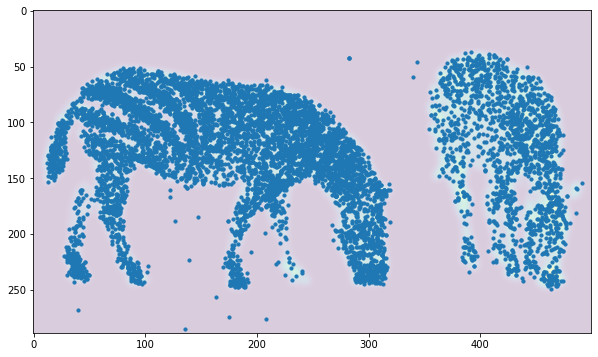

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 10000
k = 40
epsilon = 1

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)
init_sample = sample_from_image_density(1, density, subkey).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/zebra_iter10000_k40_e1.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 1], sampled_outputs[:, :, 0], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 10000
k = 40
epsilon = 0.8

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)
init_sample = sample_from_image_density(1, density, subkey).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/zebra_iter10000_k40_e08.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 1], sampled_outputs[:, :, 0], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

  0%|          | 2/10000 [00:15<21:20:19,  7.68s/it]

Metropolis- Hastings REJECT 0.82681686 2.734685


  0%|          | 6/10000 [00:40<17:33:43,  6.33s/it]

Metropolis- Hastings REJECT 0.39318344 0.655401


  0%|          | 13/10000 [01:22<17:03:01,  6.15s/it]

Metropolis- Hastings REJECT 0.039679814 2.9917774


  0%|          | 15/10000 [01:35<16:59:32,  6.13s/it]

Metropolis- Hastings REJECT 0.07143685 2.29629


  0%|          | 22/10000 [02:17<17:11:59,  6.21s/it]

Metropolis- Hastings REJECT 0.74880546 1.5698243


  0%|          | 23/10000 [02:24<17:06:50,  6.18s/it]

Metropolis- Hastings REJECT 0.74880546 1.1571053


  0%|          | 31/10000 [03:12<17:01:09,  6.15s/it]

Metropolis- Hastings REJECT 0.58625466 0.8192551


  1%|          | 51/10000 [05:13<16:35:33,  6.00s/it]

Metropolis- Hastings REJECT 0.29536265 0.4929281


  1%|          | 59/10000 [06:02<16:45:17,  6.07s/it]

Metropolis- Hastings REJECT 0.037823375 0.44070947


  1%|          | 62/10000 [06:20<16:45:39,  6.07s/it]

Metropolis- Hastings REJECT 0.114306495 0.35646918


  1%|          | 68/10000 [06:56<16:46:37,  6.08s/it]

Metropolis- Hastings REJECT 0.49410772 1.4374855


  1%|          | 69/10000 [07:02<16:51:54,  6.11s/it]

Metropolis- Hastings REJECT 0.49410772 0.94885886


  1%|          | 72/10000 [07:21<16:59:54,  6.16s/it]

Metropolis- Hastings REJECT 0.6363583 1.76882


  1%|          | 75/10000 [07:39<16:57:35,  6.15s/it]

Metropolis- Hastings REJECT 0.2048127 0.3457033


  1%|          | 76/10000 [07:46<17:08:29,  6.22s/it]

Metropolis- Hastings REJECT 0.2048127 0.7668697


  1%|          | 77/10000 [07:52<17:17:38,  6.27s/it]

Metropolis- Hastings REJECT 0.2048127 0.60159004


  1%|          | 91/10000 [09:18<16:56:32,  6.16s/it]

Metropolis- Hastings REJECT 0.6541435 1.220608


  1%|          | 109/10000 [11:07<16:34:03,  6.03s/it]

Metropolis- Hastings REJECT 0.4191332 0.9143537


  1%|▏         | 127/10000 [12:55<16:39:55,  6.08s/it]

Metropolis- Hastings REJECT 0.2507942 0.46499312


  1%|▏         | 137/10000 [13:57<17:00:37,  6.21s/it]

Metropolis- Hastings REJECT 1.906631 3.5344994


  1%|▏         | 145/10000 [14:46<16:44:42,  6.12s/it]

Metropolis- Hastings REJECT 0.5442685 1.7234855


  2%|▏         | 152/10000 [15:29<16:44:44,  6.12s/it]

Metropolis- Hastings REJECT 1.4678106 3.5262756


  2%|▏         | 157/10000 [15:59<16:33:50,  6.06s/it]

Metropolis- Hastings REJECT 0.913813 2.3386436


  2%|▏         | 159/10000 [16:11<16:39:50,  6.10s/it]

Metropolis- Hastings REJECT 0.8133819 3.6082478


  2%|▏         | 163/10000 [16:35<16:39:11,  6.09s/it]

Metropolis- Hastings REJECT 0.47755292 0.5953353


  2%|▏         | 172/10000 [17:29<16:15:46,  5.96s/it]

Metropolis- Hastings REJECT 0.8619153 1.6797359


  2%|▏         | 196/10000 [19:53<16:24:19,  6.02s/it]

Metropolis- Hastings REJECT 0.57179797 1.5026346


  2%|▏         | 201/10000 [20:24<16:29:26,  6.06s/it]

Metropolis- Hastings REJECT 0.5164524 2.3810265


  2%|▏         | 212/10000 [21:30<16:29:36,  6.07s/it]

Metropolis- Hastings REJECT 0.22598319 0.86117536


  2%|▏         | 214/10000 [21:42<16:32:44,  6.09s/it]

Metropolis- Hastings REJECT 0.18744612 0.5079435


  2%|▏         | 215/10000 [21:48<16:26:31,  6.05s/it]

Metropolis- Hastings REJECT 0.18744612 0.8382972


  2%|▏         | 216/10000 [21:54<16:35:28,  6.10s/it]

Metropolis- Hastings REJECT 0.18744612 0.975291


  2%|▏         | 230/10000 [23:18<16:17:43,  6.00s/it]

Metropolis- Hastings REJECT 0.39439973 0.4890678


  2%|▏         | 231/10000 [23:24<16:28:05,  6.07s/it]

Metropolis- Hastings REJECT 0.39439973 0.5758551


  2%|▏         | 244/10000 [24:43<16:20:51,  6.03s/it]

Metropolis- Hastings REJECT 0.1903156 0.6825552


  3%|▎         | 258/10000 [26:08<16:20:51,  6.04s/it]

Metropolis- Hastings REJECT 0.42810717 3.615482


  3%|▎         | 267/10000 [27:02<16:14:09,  6.01s/it]

Metropolis- Hastings REJECT 0.4462673 0.9646023


  3%|▎         | 271/10000 [27:25<16:08:15,  5.97s/it]

Metropolis- Hastings REJECT 0.6560378 3.5885787


  3%|▎         | 298/10000 [30:07<16:10:31,  6.00s/it]

Metropolis- Hastings REJECT 0.7487791 0.9918208


  3%|▎         | 302/10000 [30:32<16:25:03,  6.09s/it]

Metropolis- Hastings REJECT 0.5290812 0.5675168


  3%|▎         | 311/10000 [31:26<16:19:25,  6.07s/it]

Metropolis- Hastings REJECT 0.18107246 1.4930823


  3%|▎         | 314/10000 [31:44<16:21:41,  6.08s/it]

Metropolis- Hastings REJECT 0.48802206 inf


  3%|▎         | 316/10000 [31:57<16:23:12,  6.09s/it]

Metropolis- Hastings REJECT 0.15719755 1.0041218


  3%|▎         | 325/10000 [32:51<16:03:08,  5.97s/it]

Metropolis- Hastings REJECT 0.82783294 0.92216116


  3%|▎         | 342/10000 [34:34<16:28:00,  6.14s/it]

Metropolis- Hastings REJECT 0.47545218 1.0293305


  3%|▎         | 346/10000 [34:58<16:12:38,  6.05s/it]

Metropolis- Hastings REJECT 0.5954627 0.9299228


  3%|▎         | 347/10000 [35:04<16:12:48,  6.05s/it]

Metropolis- Hastings REJECT 0.5954627 1.1309414


  4%|▎         | 357/10000 [36:03<15:49:09,  5.91s/it]

Metropolis- Hastings REJECT 0.43524805 1.062273


  4%|▎         | 372/10000 [37:29<15:30:16,  5.80s/it]

Metropolis- Hastings REJECT 0.3677952 0.6456267


  4%|▎         | 373/10000 [37:35<15:28:14,  5.79s/it]

Metropolis- Hastings REJECT 0.3677952 3.5743024


  4%|▍         | 379/10000 [38:09<15:29:33,  5.80s/it]

Metropolis- Hastings REJECT 0.31560242 0.7683123


  4%|▍         | 387/10000 [38:56<15:47:22,  5.91s/it]

Metropolis- Hastings REJECT 0.5176285 0.8449139


  4%|▍         | 415/10000 [41:37<15:06:07,  5.67s/it]

Metropolis- Hastings REJECT 0.095274545 0.52312


  4%|▍         | 426/10000 [42:38<15:00:44,  5.64s/it]

Metropolis- Hastings REJECT 0.06273782 0.3450854


  4%|▍         | 429/10000 [42:56<15:14:57,  5.74s/it]

Metropolis- Hastings REJECT 0.17514732 0.5202538


  4%|▍         | 444/10000 [44:21<14:58:44,  5.64s/it]

Metropolis- Hastings REJECT 0.031134352 0.37871528


  4%|▍         | 450/10000 [44:55<15:14:18,  5.74s/it]

Metropolis- Hastings REJECT 0.15828061 0.7579888


  5%|▍         | 458/10000 [45:41<15:10:49,  5.73s/it]

Metropolis- Hastings REJECT 0.0524292 0.6027797


  5%|▍         | 473/10000 [47:06<15:03:01,  5.69s/it]

Metropolis- Hastings REJECT 0.54260576 3.2658443


  5%|▍         | 477/10000 [47:29<14:55:25,  5.64s/it]

Metropolis- Hastings REJECT 0.16684432 0.75154245


  5%|▍         | 479/10000 [47:40<14:51:53,  5.62s/it]

Metropolis- Hastings REJECT 0.18223432 0.34840614


  5%|▍         | 480/10000 [47:46<15:03:14,  5.69s/it]

Metropolis- Hastings REJECT 0.18223432 0.5613008


  5%|▍         | 481/10000 [47:52<15:03:34,  5.70s/it]

Metropolis- Hastings REJECT 0.18223432 1.4379238


  5%|▍         | 497/10000 [49:21<14:47:47,  5.61s/it]

Metropolis- Hastings REJECT 0.2119688 0.23986608


  5%|▌         | 500/10000 [49:38<14:49:50,  5.62s/it]

Metropolis- Hastings REJECT 0.43700758 2.2081783


  5%|▌         | 501/10000 [49:43<14:51:14,  5.63s/it]

Metropolis- Hastings REJECT 0.43700758 1.4249328


  5%|▌         | 521/10000 [51:35<14:44:08,  5.60s/it]

Metropolis- Hastings REJECT 0.5532889 0.70360965


  5%|▌         | 528/10000 [52:14<14:29:28,  5.51s/it]

Metropolis- Hastings REJECT 0.57464033 0.8584986


  5%|▌         | 536/10000 [52:59<14:35:57,  5.55s/it]

Metropolis- Hastings REJECT 0.3054497 0.4251935


  5%|▌         | 549/10000 [54:11<14:41:14,  5.59s/it]

Metropolis- Hastings REJECT 0.5800367 0.7090612


  6%|▌         | 563/10000 [55:30<14:41:13,  5.60s/it]

Metropolis- Hastings REJECT 1.0668864 1.6061597


  6%|▌         | 570/10000 [56:09<14:50:30,  5.67s/it]

Metropolis- Hastings REJECT 0.22458671 0.68145907


  6%|▌         | 574/10000 [56:32<14:53:10,  5.69s/it]

Metropolis- Hastings REJECT 0.2933774 0.69931686


  6%|▌         | 575/10000 [56:38<15:02:07,  5.74s/it]

Metropolis- Hastings REJECT 0.2933774 0.65209854


  6%|▌         | 601/10000 [59:03<14:37:26,  5.60s/it]

Metropolis- Hastings REJECT 0.3365837 0.8631002


  6%|▌         | 607/10000 [59:36<14:39:38,  5.62s/it]

Metropolis- Hastings REJECT 0.3849177 0.82107806


  6%|▌         | 617/10000 [1:00:33<14:56:46,  5.73s/it]

Metropolis- Hastings REJECT 0.92951185 3.5529375


  6%|▌         | 621/10000 [1:00:56<14:59:47,  5.76s/it]

Metropolis- Hastings REJECT 0.14526469 1.0673225


  6%|▌         | 622/10000 [1:01:02<14:53:57,  5.72s/it]

Metropolis- Hastings REJECT 0.14526469 0.60321313


  6%|▌         | 623/10000 [1:01:07<14:52:22,  5.71s/it]

Metropolis- Hastings REJECT 0.14526469 0.6224871


  6%|▋         | 626/10000 [1:01:24<14:36:05,  5.61s/it]

Metropolis- Hastings REJECT 0.65134037 1.498897


  6%|▋         | 645/10000 [1:03:11<14:41:42,  5.66s/it]

Metropolis- Hastings REJECT 0.4571484 1.5479263


  7%|▋         | 651/10000 [1:03:45<14:45:23,  5.68s/it]

Metropolis- Hastings REJECT 0.40199408 0.443593


  7%|▋         | 654/10000 [1:04:02<14:52:19,  5.73s/it]

Metropolis- Hastings REJECT 0.27032992 0.4651603


  7%|▋         | 657/10000 [1:04:19<14:51:04,  5.72s/it]

Metropolis- Hastings REJECT 1.083341 2.0888958


  7%|▋         | 658/10000 [1:04:25<14:47:17,  5.70s/it]

Metropolis- Hastings REJECT 1.083341 1.7734668


  7%|▋         | 668/10000 [1:05:21<14:44:23,  5.69s/it]

Metropolis- Hastings REJECT 0.60815996 0.81214017


  7%|▋         | 669/10000 [1:05:27<14:38:00,  5.65s/it]

Metropolis- Hastings REJECT 0.60815996 3.586327


  7%|▋         | 676/10000 [1:06:06<14:32:24,  5.61s/it]

Metropolis- Hastings REJECT 0.13005123 0.708021


  7%|▋         | 688/10000 [1:07:13<14:30:44,  5.61s/it]

Metropolis- Hastings REJECT 0.49840063 2.733283


  7%|▋         | 700/10000 [1:08:21<14:37:03,  5.66s/it]

Metropolis- Hastings REJECT 0.3496528 0.6415599


  7%|▋         | 707/10000 [1:09:00<14:42:30,  5.70s/it]

Metropolis- Hastings REJECT 3.5385406 inf


  7%|▋         | 708/10000 [1:09:06<14:46:19,  5.72s/it]

Metropolis- Hastings REJECT 3.5385406 inf


  7%|▋         | 710/10000 [1:09:17<14:41:37,  5.69s/it]

Metropolis- Hastings REJECT 3.5388925 inf


  7%|▋         | 720/10000 [1:10:14<14:27:20,  5.61s/it]

Metropolis- Hastings REJECT 0.041475646 0.22527735


  7%|▋         | 722/10000 [1:10:25<14:33:59,  5.65s/it]

Metropolis- Hastings REJECT 0.5355241 0.99295974


  7%|▋         | 730/10000 [1:11:11<14:47:49,  5.75s/it]

Metropolis- Hastings REJECT 0.21074171 0.62212163


  7%|▋         | 744/10000 [1:12:29<14:42:39,  5.72s/it]

Metropolis- Hastings REJECT 0.5825346 2.8173547


  8%|▊         | 751/10000 [1:13:09<14:35:38,  5.68s/it]

Metropolis- Hastings REJECT 0.4438333 0.6306559


  8%|▊         | 753/10000 [1:13:21<14:35:56,  5.68s/it]

Metropolis- Hastings REJECT 0.34776428 0.52269155


  8%|▊         | 767/10000 [1:14:38<14:10:54,  5.53s/it]

Metropolis- Hastings REJECT 0.6489969 0.90554345


  8%|▊         | 794/10000 [1:17:11<14:35:06,  5.70s/it]

Metropolis- Hastings REJECT 0.80300844 0.99911046


  8%|▊         | 803/10000 [1:18:01<14:21:11,  5.62s/it]

Metropolis- Hastings REJECT 0.42653558 1.1017953


  8%|▊         | 805/10000 [1:18:12<14:18:52,  5.60s/it]

Metropolis- Hastings REJECT 0.35667634 2.216132


  8%|▊         | 816/10000 [1:19:16<14:57:35,  5.86s/it]

Metropolis- Hastings REJECT 0.5289164 0.9788003


  8%|▊         | 817/10000 [1:19:21<14:55:51,  5.85s/it]

Metropolis- Hastings REJECT 0.5289164 0.5831674


  8%|▊         | 825/10000 [1:20:06<14:19:51,  5.62s/it]

Metropolis- Hastings REJECT 0.29218143 0.5743918


  8%|▊         | 830/10000 [1:20:35<14:35:23,  5.73s/it]

Metropolis- Hastings REJECT 0.41561946 1.02106


  8%|▊         | 831/10000 [1:20:41<14:26:26,  5.67s/it]

Metropolis- Hastings REJECT 0.41561946 0.5771992


  8%|▊         | 834/10000 [1:20:58<14:26:48,  5.67s/it]

Metropolis- Hastings REJECT 0.4573598 1.2313403


  8%|▊         | 835/10000 [1:21:04<14:43:23,  5.78s/it]

Metropolis- Hastings REJECT 0.4573598 1.7545012


  8%|▊         | 837/10000 [1:21:16<15:03:16,  5.91s/it]

Metropolis- Hastings REJECT 0.6984739 1.3154532


  9%|▊         | 852/10000 [1:22:41<14:43:45,  5.80s/it]

Metropolis- Hastings REJECT 0.059862353 0.7513322


  9%|▊         | 855/10000 [1:22:58<14:36:55,  5.75s/it]

Metropolis- Hastings REJECT 0.060930293 1.3872473


  9%|▊         | 856/10000 [1:23:04<14:28:31,  5.70s/it]

Metropolis- Hastings REJECT 0.060930293 1.1983677


  9%|▊         | 861/10000 [1:23:32<14:16:18,  5.62s/it]

Metropolis- Hastings REJECT 0.32366765 1.3452624


  9%|▊         | 866/10000 [1:24:00<13:56:27,  5.49s/it]

Metropolis- Hastings REJECT 0.101544656 0.5606619


  9%|▊         | 868/10000 [1:24:11<13:54:12,  5.48s/it]

Metropolis- Hastings REJECT 0.3329756 3.6454852


  9%|▉         | 886/10000 [1:25:52<14:14:22,  5.62s/it]

Metropolis- Hastings REJECT 0.5605134 0.75153184


  9%|▉         | 887/10000 [1:25:57<14:14:18,  5.62s/it]

Metropolis- Hastings REJECT 0.5605134 1.1872536


  9%|▉         | 888/10000 [1:26:03<14:30:55,  5.73s/it]

Metropolis- Hastings REJECT 0.5605134 3.394405


  9%|▉         | 914/10000 [1:28:31<14:22:07,  5.69s/it]

Metropolis- Hastings REJECT 0.2843923 0.8167999


  9%|▉         | 916/10000 [1:28:42<14:31:21,  5.76s/it]

Metropolis- Hastings REJECT 0.51041836 1.5245806


  9%|▉         | 918/10000 [1:28:53<14:14:46,  5.65s/it]

Metropolis- Hastings REJECT 1.2140969 1.6674607


  9%|▉         | 938/10000 [1:30:46<14:23:39,  5.72s/it]

Metropolis- Hastings REJECT 0.98432434 3.6918159


  9%|▉         | 948/10000 [1:31:42<14:24:07,  5.73s/it]

Metropolis- Hastings REJECT 0.30496013 0.53325284


  9%|▉         | 949/10000 [1:31:48<14:26:45,  5.75s/it]

Metropolis- Hastings REJECT 0.30496013 1.0379021


 10%|▉         | 959/10000 [1:32:44<14:12:03,  5.65s/it]

Metropolis- Hastings REJECT 0.54561496 1.6269106


 10%|▉         | 975/10000 [1:34:14<14:24:29,  5.75s/it]

Metropolis- Hastings REJECT 0.41495717 3.6374078


 10%|▉         | 988/10000 [1:35:27<13:57:24,  5.58s/it]

Metropolis- Hastings REJECT 0.38861147 1.5323651


 10%|▉         | 996/10000 [1:36:11<13:52:35,  5.55s/it]

Metropolis- Hastings REJECT 0.051319283 1.1438698


 10%|▉         | 998/10000 [1:36:22<13:52:47,  5.55s/it]

Metropolis- Hastings REJECT 0.33773205 0.41858116


 10%|█         | 1000/10000 [1:36:34<14:03:59,  5.63s/it]

Metropolis- Hastings REJECT 0.3595459 0.5129631


 10%|█         | 1001/10000 [1:36:40<14:16:33,  5.71s/it]

Metropolis- Hastings REJECT 0.3595459 0.5307785


 10%|█         | 1005/10000 [1:37:03<14:15:21,  5.71s/it]

Metropolis- Hastings REJECT 0.433425 0.7948863


 10%|█         | 1017/10000 [1:38:10<14:00:08,  5.61s/it]

Metropolis- Hastings REJECT 0.63208014 3.575007


 10%|█         | 1022/10000 [1:38:37<13:52:15,  5.56s/it]

Metropolis- Hastings REJECT 0.43626103 0.74126065


 10%|█         | 1033/10000 [1:39:39<14:00:45,  5.63s/it]

Metropolis- Hastings REJECT 0.14972065 1.0269039


 10%|█         | 1035/10000 [1:39:51<14:03:54,  5.65s/it]

Metropolis- Hastings REJECT 0.100147225 1.4333332


 10%|█         | 1037/10000 [1:40:01<13:47:46,  5.54s/it]

Metropolis- Hastings REJECT 0.06720225 0.3843073


 10%|█         | 1039/10000 [1:40:12<13:37:00,  5.47s/it]

Metropolis- Hastings REJECT 0.05040396 1.0313005


 10%|█         | 1042/10000 [1:40:29<13:51:06,  5.57s/it]

Metropolis- Hastings REJECT 0.8310554 1.8179218


 10%|█         | 1047/10000 [1:40:57<13:58:05,  5.62s/it]

Metropolis- Hastings REJECT 0.1095807 0.36731416


 10%|█         | 1048/10000 [1:41:03<13:55:30,  5.60s/it]

Metropolis- Hastings REJECT 0.1095807 0.79738885


 11%|█         | 1062/10000 [1:42:20<13:45:44,  5.54s/it]

Metropolis- Hastings REJECT 0.11423106 0.6815926


 11%|█         | 1063/10000 [1:42:26<13:51:59,  5.59s/it]

Metropolis- Hastings REJECT 0.11423106 1.5338911


 11%|█         | 1077/10000 [1:43:44<13:52:35,  5.60s/it]

Metropolis- Hastings REJECT 0.4088173 3.5476296


 11%|█         | 1084/10000 [1:44:22<13:29:46,  5.45s/it]

Metropolis- Hastings REJECT 0.47596332 0.888855


 11%|█         | 1090/10000 [1:44:55<13:38:45,  5.51s/it]

Metropolis- Hastings REJECT 0.2626785 1.5182617


 11%|█         | 1112/10000 [1:46:57<13:59:59,  5.67s/it]

Metropolis- Hastings REJECT 1.3404242 1.8661714


 11%|█▏        | 1126/10000 [1:48:16<13:43:05,  5.57s/it]

Metropolis- Hastings REJECT 0.6490076 1.0120939


 11%|█▏        | 1147/10000 [1:50:14<13:56:55,  5.67s/it]

Metropolis- Hastings REJECT 0.5497204 1.2257919


 12%|█▏        | 1167/10000 [1:52:05<13:50:04,  5.64s/it]

Metropolis- Hastings REJECT 0.12814486 0.41180182


 12%|█▏        | 1169/10000 [1:52:17<13:59:24,  5.70s/it]

Metropolis- Hastings REJECT 0.009278714 0.22078702


 12%|█▏        | 1173/10000 [1:52:39<13:50:09,  5.64s/it]

Metropolis- Hastings REJECT 0.67788315 3.2536337


 12%|█▏        | 1174/10000 [1:52:45<13:57:33,  5.69s/it]

Metropolis- Hastings REJECT 0.67788315 0.97632444


 12%|█▏        | 1176/10000 [1:52:57<13:54:20,  5.67s/it]

Metropolis- Hastings REJECT 0.18232237 1.4909066


 12%|█▏        | 1177/10000 [1:53:02<13:54:27,  5.67s/it]

Metropolis- Hastings REJECT 0.18232237 1.9449


 12%|█▏        | 1191/10000 [1:54:20<13:31:38,  5.53s/it]

Metropolis- Hastings REJECT 0.36856833 0.96542853


 12%|█▏        | 1198/10000 [1:54:59<13:45:45,  5.63s/it]

Metropolis- Hastings REJECT 0.67021054 1.1071472


 12%|█▏        | 1220/10000 [1:57:03<13:47:18,  5.65s/it]

Metropolis- Hastings REJECT 0.6152582 1.4061531


 12%|█▏        | 1225/10000 [1:57:31<13:47:55,  5.66s/it]

Metropolis- Hastings REJECT 0.49839944 1.8330383


 12%|█▏        | 1228/10000 [1:57:48<13:42:00,  5.62s/it]